# TODO - 17. 4. 2020
- zmínit, že je jedno, že to jsou kryptoměny
- zmínit na Arbitážích, že to je obměna forexu -> je to forex pro kryptoměny
- ocitovat obchodní knihu, jak je stahuju
- ocitovat struktury, kde to a jak to ukládám
- Mastering Bitcoin
- pondělí 25. května
- adresa serveru stary.fit.cvut.cz
- 31.4. 14:00

# TODO - 3. 4. 2020
- napsat 5 nejzajímavějších kryptoměn a zmínit používaný zbytek
- projít všechna data, vypsat základní statistiky (obecný) ke všem a vyselektovat cca 5 nejlepších a u nich se zaměřit na detaily (závislost v čase, na prodaném objemu, na počtu obchodů)
- průměrná doba výskytu trojúhelníku
- napsat k trojúhelníkům denní statistiky výskytu, nejlepších, nejhorších 
- možnost zaměřit se na neefektivitu trhu, zmínit že není regulovaný a proto na něm vznikají arbitráže
- zmínit problémy vytěžitelnosti a jak by to reálně pobíhalo
- průměrný objem nasbíraných dat
- v praktické části popsat strukturu ukládaných dat (csv, json)
- v praktické části se zaměřit na používané algoritmy (jak sbírám order book, do jaké hloubky, jak ho procházím a znovu ukládám) 

In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join, isdir
from typing import Dict, Tuple, Sequence
from copy import deepcopy
import threading
import os
from datetime import datetime

In [2]:
#  Exchange rates from cryptocurrencies to USDT (USD) (Binance.com, 13.4.2020) 
rate = {
    "BTC": 6837.51,
    "LTC": 41,
    "ETH": 156.7,
    "XRP": 0.185965,
    "USDT": 1,
    "BCH": 222.98,
    "BNB": 15.53,
    "EOS": 2.44,
    "XMR": 53.37,
    "TRX": 0.012597
}
title_font_size = 20  # title font size for the charts
label_font_size = 13

In [3]:
def fetch_directories(path: str) -> [str]:
    '''
    Fetches all directories in the given path 
    '''
    directories = []
    try:
        directories = [join(path, f) for f in listdir(path) if isdir(join(path, f))] 
    except:
        print("Trouble opening a directory")
        return directories
    return directories

def fetch_files(path: str) -> [str]:    
    '''
    Fetches all files in the given path 
    '''
    files = []
    try:
        files = [f for f in listdir(path) if isfile(join(path, f))] 
    except:
        print("Trouble opening a directory")
        return files
    return files

In [4]:
class FileHandler:
    def __init__(self, file: str, path: str):
        self.filename = file
        self.total_gain = 0
        self.average_gain = 0
        self.max_gain = 0
        self.best_gains = None
        self.date = file[-15:-5:]
        with open(join(path, file)) as f:
            tmp = json.loads(f.read())
            self.content = tmp["arbitrage_stats"]
            self.arbitrages_count = tmp["arbitrages_count"]
            self.without_fees_count = tmp["without_fees_count"]
            self.all_count = tmp["all_count"]
        self.scores = [x["score"] for x in self.content]
    
    @property
    def filename(self) -> str:
        return self.__filename
    
    @filename.setter
    def filename(self, filename: str):
        self.__filename = filename
        
    @property
    def content(self) -> str:
        return self.__content
    
    @content.setter
    def content(self, content: str):
        self.__content = content
        
    @property
    def total_gain(self) -> float:
        return self.__total_gain
    
    @total_gain.setter
    def total_gain(self, total_gain: float):
        self.__total_gain = total_gain
        
    @property
    def max_gain(self) -> float:
        return self.__max_gain
    
    @max_gain.setter
    def max_gain(self, max_gain: float):
        self.__max_gain = max_gain
        
    @property
    def average_gain(self) -> float:
        return self.__average_gain
    
    @average_gain.setter
    def average_gain(self, average_gain: float):
        self.__average_gain = average_gain
        
    @property
    def scores(self) -> [float]:
        return self.__scores
    
    @scores.setter
    def scores(self, scores: [float]):
        self.__scores = scores
        
    @property
    def arbitrages_count(self) -> int:
        return self.__arbitrages_count
    
    @arbitrages_count.setter
    def arbitrages_count(self, arbitrages_count: int):
        self.__arbitrages_count = arbitrages_count     
        
    @property
    def without_fees_count(self) -> int:
        return self.__without_fees_count
    
    @without_fees_count.setter
    def without_fees_count(self, without_fees_count: int):
        self.__without_fees_count = without_fees_count  
        
    @property
    def all_count(self) -> int:
        return self.__all_count
    
    @all_count.setter
    def all_count(self, all_count: int):
        self.__all_count = all_count  
        
    @property
    def date(self) -> str:
        return self.__date
    
    @date.setter
    def date(self, date: str):
        self.__date = date  
        
    def get_best_indexes_count(self) -> Dict[int, int]:
        indexes = np.array([x['supply_gain_index'] for x in self.content]).ravel()
        tmp = np.array([x['demand_gain_index'] for x in self.content]).ravel()
        indexes = np.array((indexes, tmp)).ravel()
        unique, counts = np.unique(indexes, return_counts = True)
        return dict(zip(unique, counts))
    
    def get_number_of_arbitrages(self) -> int:
        return len(self.scores)
    
    def get_average_score(self) -> float:
        if len(self.scores):
            return sum(self.scores)/len(self.scores)
        return 1
    
    def get_best_score(self) -> float:
        if len(self.scores):
            return max(self.scores)
        return 1
    
    def get_best_gains(self):
        best_gains = np.array([x["supply_gain"] for x in self.content])
        best_gains = np.array((best_gains, [x["supply_gain"] for x in self.content])).ravel()
        best_gains = best_gains[self.best_gains != 0.0]
        self.total_gain = np.sum(best_gains)
        self.average_gain = np.average(best_gains)
        if len(best_gains[0]):
            self.max_gain = np.max(best_gains)
        else:
            self.max_gain = 0
        return best_gains

    def get_first_currency(self) -> str:
        if (self.content):
            return self.content[0]['pairs'][0]['currency'][0:3]
        return ""
    
    def time_distribution_by_hours(self):
        hour_array = [datetime.fromtimestamp(max(x['pairs'][0]['timestamp'], x['pairs'][1]['timestamp'], x['pairs'][2]['timestamp'])).hour for x in self.content]
        counter = Counter()
        for x in hour_array:
            counter[x] += 1
#         display(counter)
        return counter 

In [5]:
class Triangle:
    def __init__(self, files: [str], path: str, triangle_name: str):
        self.__files = []
        self.__index_counts = None
        self.__path = path
        self.__best_gains = None
        self.__name = triangle_name
        for f in files:
            self.__files.append(FileHandler(f, path))
            

    @property
    def path(self) -> str:
        return self.__path
    
    @property
    def name(self) -> str:
        return self.__name
            
    def get_best_indexes_count(self) -> Dict[int, int]:
        if self.__index_counts is None:
            index_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
            for d in np.array([x.get_best_indexes_count() for x in self.__files]):
                for k in d.keys():
                    index_counts[k] += d[k]
            self.__index_counts = index_counts
        return self.__index_counts
    
    def get_daily_number_average_of_arbitrages(self) -> int:
        return sum([x.get_number_of_arbitrages() for x in self.__files])/len(self.__files)
    
    def get_average_score(self) -> float:
        return sum([x.get_average_score() for x in self.__files])/len(self.__files)
    
    def get_best_score(self) -> float:
        return max([x.get_best_score() for x in self.__files])
    
    def get_best_gains(self):
        if self.__best_gains is None:
            self.__best_gains = [x.get_best_gains() for x in self.__files]
        return self.__best_gains
    
    def get_overall_best_gain(self) -> float:
        if self.__best_gains is None:
            self.__best_gains = [x.get_best_gains() for x in self.__files]
        return np.max([x.max_gain for x in self.__files])
    
    def get_average_gain(self) -> float:
        if self.__best_gains is None:
            self.__best_gains = [x.get_best_gains() for x in self.__files]
        return np.average([x.total_gain for x in self.__files])
    
    def get_total_gain(self) -> float:
        if self.__best_gains is None:
            self.__best_gains = [x.get_best_gains() for x in self.__files]
        return np.max([x.total_gain for x in self.__files])
    
    def get_first_currency(self) -> str:
        for f in self.__files:
            tmp = f.get_first_currency()
            if tmp != "":
                return tmp
        return ""
    
    def get_data_length(self) -> int:
        return len(self.__files)
    
    def get_arbitrages_counts(self) -> ([int], [str]):
        return [x.arbitrages_count for x in self.__files], [x.without_fees_count for x in self.__files], [x.all_count for x in self.__files], [x.date for x in self.__files]

    def time_distribution_by_hours(self):
        return sum([x.time_distribution_by_hours() for x in self.__files], Counter())

In [6]:
def basic_stats(t):
    '''
    Gets the main stats from the Triangle class
    '''
    a = t.get_best_indexes_count()
    tmp = {
        "Name": t.name,
        "Days": t.get_data_length(), 
        "Average count": t.get_daily_number_average_of_arbitrages(),
        "Average score": t.get_average_score(),
        "The best score": t.get_best_score(),
        "The best gain": '{:e} {}'.format(t.get_overall_best_gain(), t.get_first_currency()),
        "Total inefficiency": '{:e} {}'.format(t.get_total_gain(), t.get_first_currency()), 
        "Average daily inefficiency": '{:e} {}'.format(t.get_average_gain(), t.get_first_currency()),
        "Average daily inefficiency (USD)": t.get_average_gain() * rate[t.get_first_currency()]
    }
    return tmp

In [7]:
# def basic_stats(t):
#     a = t.get_best_indexes_count()
#     tmp = {
#         "Název": t.name,
#         "Počet dní": t.get_data_length(), 
#         "Průměr počtu arbitráží": t.get_daily_number_average_of_arbitrages(),
#         "Průměrný procentuální zisk": t.get_average_score(),
#         "Nejlepší procentuální zisk": t.get_best_score(),
#         "Celkový výdělek": '{:e} {}'.format(t.get_overall_best_gain(), t.get_first_currency()),
#         "Celková neefektivita trhu": '{:e} {}'.format(t.get_total_gain(), t.get_first_currency()), 
#         "Průměrný denní zisk": '{:e} {}'.format(t.get_average_gain(), t.get_first_currency()),
#         "Průměrný denní zisk (USD)": t.get_average_gain() * rate[t.get_first_currency()]
#     }
#     return tmp

In [8]:
from collections import Counter
main_counter = Counter()
path = "./output_data/"    

stats = []
count = 0
stop = 99
for directory in fetch_directories(path):
    print(count)
    count += 1
    triangle = Triangle(fetch_files(directory), directory, directory[len(path):])
    counter = triangle.time_distribution_by_hours()
    main_counter += counter
    triangle = None
    if count == stop:
        break
display(main_counter)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


Counter({16: 547,
         1: 1202,
         21: 444097,
         18: 483,
         17: 815420,
         4: 1282,
         15: 340,
         10: 125929,
         14: 744331,
         20: 149,
         11: 16695,
         2: 1167,
         6: 232,
         5: 385,
         3: 430291,
         13: 574199,
         9: 467,
         7: 222345,
         8: 412762,
         12: 2941,
         0: 867,
         22: 338,
         23: 152,
         19: 309907})

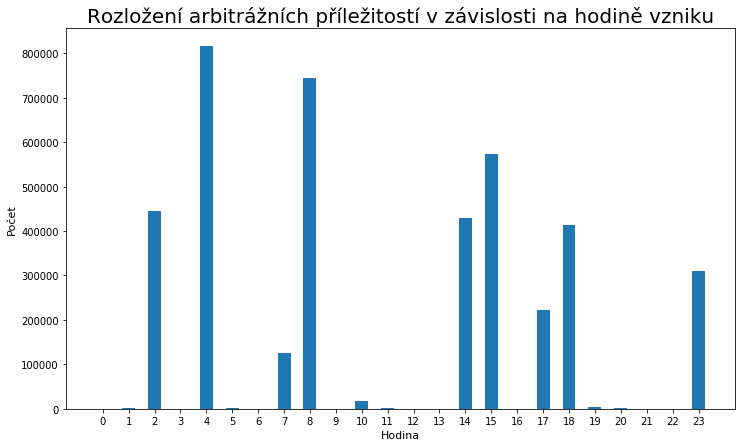

In [9]:
# display(main_counter)
fig, ax = plt.subplots()
ind = np.arange(len(main_counter))
width = 0.5
ax.bar(ind, main_counter.values(), width=width)
fig.set_size_inches(width * len(main_counter.keys()), 7)
ax.set_xticks(ind)
plt.xlabel('Hodina', fontsize=label_font_size-2)
plt.ylabel('Počet', fontsize=label_font_size-2)
plt.title('Rozložení arbitrážních příležitostí v závislosti na hodině vzniku', fontsize=title_font_size)
plt.show()

0


{0: 116786, 1: 40086, 2: 39782, 3: 4875, 4: 4385}

1


{0: 129566, 1: 40086, 2: 39782, 3: 4875, 4: 4385}

2


{0: 177573, 1: 44865, 2: 41150, 3: 5492, 4: 4448}

3


{0: 227873, 1: 49456, 2: 44820, 3: 6451, 4: 4742}

4


{0: 324448, 1: 55323, 2: 56988, 3: 12132, 4: 5057}

5


{0: 658925, 1: 83873, 2: 80027, 3: 27618, 4: 11151}

6


{0: 660525, 1: 83896, 2: 80036, 3: 27624, 4: 11151}

7


{0: 672554, 1: 85201, 2: 80370, 3: 27815, 4: 11266}

8


{0: 680134, 1: 85442, 2: 80431, 3: 27841, 4: 12136}

9


{0: 742562, 1: 90523, 2: 84208, 3: 28877, 4: 12264}

10


{0: 749861, 1: 91649, 2: 84471, 3: 29004, 4: 12401}

11


{0: 814802, 1: 95130, 2: 86200, 3: 29380, 4: 12458}

12


{0: 830817, 1: 98512, 2: 86278, 3: 29392, 4: 12459}

13


{0: 1010248, 1: 121266, 2: 99967, 3: 37061, 4: 18266}

14


{0: 1016349, 1: 121778, 2: 100164, 3: 37173, 4: 18406}

15


{0: 1201228, 1: 152712, 2: 107069, 3: 40230, 4: 38043}

16


{0: 1203392, 1: 152790, 2: 107096, 3: 40251, 4: 38063}

17


{0: 1206709, 1: 152891, 2: 107171, 3: 40259, 4: 38096}

18


{0: 1209271, 1: 153052, 2: 107212, 3: 40289, 4: 38116}

19


{0: 1221668, 1: 154062, 2: 107596, 3: 40500, 4: 38334}

20


{0: 1438013, 1: 165662, 2: 116182, 3: 48193, 4: 45798}

21


{0: 1466182, 1: 167282, 2: 117050, 3: 48702, 4: 46144}

22


{0: 9793300, 1: 1044223, 2: 459509, 3: 413105, 4: 406551}

23


{0: 11220188, 1: 1150303, 2: 567412, 3: 547964, 4: 461403}

24


{0: 12709657, 1: 1199536, 2: 711579, 3: 612915, 4: 522541}

25


{0: 13273805, 1: 1262719, 2: 744165, 3: 642534, 4: 557967}

26


{0: 14804033, 1: 1378468, 2: 874102, 3: 708034, 4: 666037}

27


{0: 16512513, 1: 1384698, 2: 900509, 3: 708124, 4: 678840}

28


{0: 17559987, 1: 1497876, 2: 970202, 3: 764200, 4: 762105}

29


{0: 18665918, 1: 1513070, 2: 1086385, 3: 800723, 4: 780614}

30


{0: 18684427, 1: 1514672, 2: 1086921, 3: 801134, 4: 780892}

31


{0: 18921873, 1: 1564064, 2: 1103462, 3: 812647, 4: 791710}

32


{0: 19035503, 1: 1581439, 2: 1117628, 3: 822741, 4: 791731}

33


{0: 19272668, 1: 1583383, 2: 1155161, 3: 830494, 4: 791778}

34


{0: 19461582, 1: 1599931, 2: 1164928, 3: 839286, 4: 801523}

35


{0: 19712089, 1: 1606958, 2: 1205831, 3: 847614, 4: 801526}

36


{0: 19727823, 1: 1607800, 2: 1206123, 3: 847902, 4: 801668}

37


{0: 19977245, 1: 1630937, 2: 1218689, 3: 857170, 4: 809357}

38


{0: 19985742, 1: 1631587, 2: 1218954, 3: 857363, 4: 809466}

39


{0: 20010267, 1: 1633262, 2: 1219403, 3: 857623, 4: 809623}

40


{0: 20105444, 1: 1637627, 2: 1225231, 3: 861223, 4: 809643}

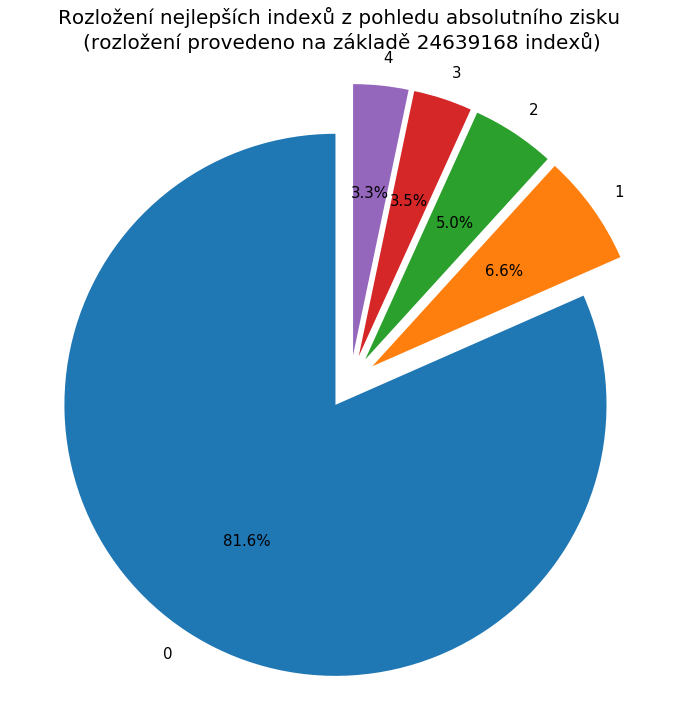

In [12]:
path = "./output_data/"    

indexes = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
count = 0
stop = 99
for directory in fetch_directories(path):
    print(count)
    triangle = Triangle(fetch_files(directory), directory, directory[len(path):])
    ind = triangle.get_best_indexes_count()
    for k in ind.keys():
        indexes[k] += ind[k]
    display(indexes)
    count += 1
    triangle = None
    if count == stop:
        break
        
labels = indexes.keys()
sizes = indexes.values()
explode = (0.1, 0.1, 0.1, 0.1, 0.1)
fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90, textprops={'fontsize': 15})
ax.axis('equal')
fig.set_size_inches(12, 12)
plt.title("Rozložení nejlepších indexů z pohledu absolutního zisku \n(rozložení provedeno na základě " 
              + str(sum(indexes.values())) + " indexů)", fontsize=title_font_size)

plt.savefig(os.path.join('images/index_distribution.png'), dpi=300, format='png')
    
plt.show()

In [10]:
path = "./output_data/"    

stats = []
count = 0
stop = 99
for directory in fetch_directories(path):
    print(count)
    count += 1
    triangle = Triangle(fetch_files(directory), directory, directory[len(path):])
    stats.append(basic_stats(triangle))
    triangle = None
    if count == stop:
        break

0


D:\School\Anaconda\lib\site-packages\numpy\lib\function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
D:\School\Anaconda\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


In [11]:
pd.options.display.float_format = "{:e}".format
stats_table = pd.DataFrame(stats)
stats_table

Name  Days  Average count  Average score  The best score  \
0    BTCBCHBNB    31   1.107065e+03   1.001732e+00    1.039020e+00   
1    BTCBNBTRX    31   6.870968e+01   1.000476e+00    1.007800e+00   
2    BTCBNBXMR    31   2.948065e+02   1.001385e+00    1.006420e+00   
3    BTCEOSBNB    31   3.215806e+02   1.000723e+00    1.025380e+00   
4    BTCETHBNB    31   6.484194e+02   1.000710e+00    1.006210e+00   
5    BTCETHEOS    31   2.191645e+03   1.000526e+00    1.012260e+00   
6    BTCETHTRX    49   5.571429e+00   1.000435e+00    1.019190e+00   
7    BTCETHXMR    49   4.753061e+01   1.001140e+00    1.017280e+00   
8    BTCETHXRP    49   2.985714e+01   1.000657e+00    1.022920e+00   
9    BTCLTCBNB    31   3.895161e+02   1.000942e+00    1.007070e+00   
10   BTCLTCETH    49   3.044898e+01   1.000555e+00    1.022520e+00   
11   BTCXRPBNB    31   3.794839e+02   1.000704e+00    1.006400e+00   
12   BTCXRPTRX    49   6.628571e+01   1.001062e+00    1.023790e+00   
13   ETHBNBTRX    31   1.233065e+03   1.000328e+00    1.014520e+00   
14   ETHBNBXMR    49   2.402041e+01   1.000540e+00    1.045810e+00   
15   ETHEOSBNB    31   1.319419e+03   1.000569e+00    1.020280e+00   
16   ETHXRPBNB    49   7.857143e+00   1.000350e+00    1.033420e+00   
17   ETHXRPTRX    49   1.202041e+01   1.000519e+00    1.014140e+00   
18   LTCETHBNB    49   9.571429e+00   1.000492e+00    1.026660e+00   
19  USDTBCHBNB    49   4.836735e+01   1.002764e+00    1.114940e+00   
20  USDTBNBTRX    31   1.353161e+03   1.002199e+00    1.014850e+00   
21  USDTBNBXMR    49   1.071837e+02   1.002802e+00    1.142000e+00   
22  USDTBTCBCH    31   5.522219e+04   1.004794e+00    1.049500e+00   
23  USDTBTCBNB    31   9.841839e+03   1.003708e+00    1.036980e+00   
24  USDTBTCEOS    50   6.029860e+03   1.003837e+00    1.101560e+00   
25  USDTBTCETH    31   3.897645e+03   1.002301e+00    1.031450e+00   
26  USDTBTCLTC    49   6.630898e+03   1.003595e+00    1.060710e+00   
27  USDTBTCTRX    49   5.966020e+03   1.002628e+00    1.085550e+00   
28  USDTBTCXMR    49   4.658796e+03   1.003522e+00    1.063980e+00   
29  USDTBTCXRP    49   4.395714e+03   1.003554e+00    1.060900e+00   
30  USDTEOSBNB    49   7.257143e+01   1.002775e+00    1.104790e+00   
31  USDTETHBNB    31   1.751129e+03   1.001853e+00    1.030900e+00   
32  USDTETHEOS    31   8.348710e+02   1.001241e+00    1.022300e+00   
33  USDTETHTRX    31   1.529258e+03   1.001262e+00    1.029200e+00   
34  USDTETHXMR    31   1.256806e+03   1.001539e+00    1.028470e+00   
35  USDTETHXRP    31   1.649290e+03   1.000928e+00    1.028720e+00   
36  USDTLTCBNB    49   5.883673e+01   1.002606e+00    1.104170e+00   
37  USDTLTCETH    31   1.624097e+03   1.001347e+00    1.030510e+00   
38  USDTXRPBNB    49   3.304082e+01   1.002836e+00    1.111370e+00   
39  USDTXRPTRX    49   9.206122e+01   1.002000e+00    1.074050e+00   
40   XRPBNBTRX    31   5.859677e+02   1.000754e+00    1.013270e+00   

       The best gain Total inefficiency Average daily inefficiency  \
0   1.528940e-03 BCH   2.748139e+01 BCH           8.865920e-01 BCH   
1   1.286360e-13 TRX   2.572720e-13 TRX           9.475361e-15 TRX   
2   4.975940e-06 XMR   4.669594e-03 XMR           1.525292e-04 XMR   
3   6.440760e-07 EOS   5.593003e-04 EOS           1.854688e-05 EOS   
4   4.179320e-07 BNB   1.560732e-03 BNB           5.039569e-05 BNB   
5   8.940850e-08 EOS   1.656258e-03 EOS           5.343325e-05 EOS   
6   7.042350e-12 TRX   8.167343e-11 TRX           3.109653e-12 TRX   
7   2.275100e-06 XMR   6.313177e-05 XMR           1.822771e-06 XMR   
8   4.160390e-10 XRP   4.707160e-07 XRP           9.650683e-09 XRP   
9   1.995000e-05 LTC   2.666775e-02 LTC           8.676611e-04 LTC   
10  2.306770e-05 LTC   3.733013e-04 LTC           8.150426e-06 LTC   
11  5.459300e-09 XRP   9.123745e-06 XRP           2.943502e-07 XRP   
12  9.040310e-09 TRX   3.757080e-07 TRX           1.298209e-08 TRX   
13  1.059450e-11 TRX   4.769612e-11 TRX           1.538585e-12 TRX   
14  8.770460e-04 XM

In [17]:
asvsd = stats_table['Average daily inefficiency (USD)'] > 1
stats_table[asvsd]

Name  Days  Average count  Average score  The best score  \
0    BTCBCHBNB    31   1.107065e+03   1.001732e+00    1.039020e+00   
19  USDTBCHBNB    49   4.836735e+01   1.002764e+00    1.114940e+00   
21  USDTBNBXMR    49   1.071837e+02   1.002802e+00    1.142000e+00   
22  USDTBTCBCH    31   5.522219e+04   1.004794e+00    1.049500e+00   
23  USDTBTCBNB    31   9.841839e+03   1.003708e+00    1.036980e+00   
24  USDTBTCEOS    50   6.029860e+03   1.003837e+00    1.101560e+00   
25  USDTBTCETH    31   3.897645e+03   1.002301e+00    1.031450e+00   
26  USDTBTCLTC    49   6.630898e+03   1.003595e+00    1.060710e+00   
28  USDTBTCXMR    49   4.658796e+03   1.003522e+00    1.063980e+00   
30  USDTEOSBNB    49   7.257143e+01   1.002775e+00    1.104790e+00   
31  USDTETHBNB    31   1.751129e+03   1.001853e+00    1.030900e+00   
32  USDTETHEOS    31   8.348710e+02   1.001241e+00    1.022300e+00   
34  USDTETHXMR    31   1.256806e+03   1.001539e+00    1.028470e+00   
36  USDTLTCBNB    49   5.883673e+01   1.002606e+00    1.104170e+00   
37  USDTLTCETH    31   1.624097e+03   1.001347e+00    1.030510e+00   

       The best gain Total inefficiency Average daily inefficiency  \
0   1.528940e-03 BCH   2.748139e+01 BCH           8.865920e-01 BCH   
19  1.559690e+00 BCH   1.287343e+02 BCH           2.873353e+00 BCH   
21  6.383220e-01 XMR   2.420542e+01 XMR           6.951717e-01 XMR   
22  4.539970e-01 BCH   4.911041e+03 BCH           3.056546e+02 BCH   
23  1.186430e-02 BNB   4.127759e+02 BNB           1.526766e+01 BNB   
24  2.546930e-02 EOS   3.657324e+01 EOS           8.738539e-01 EOS   
25  2.187630e-01 ETH   5.135635e+02 ETH           2.186222e+01 ETH   
26  1.934550e-01 LTC   8.902319e+02 LTC           3.559963e+01 LTC   
28  5.499750e-02 XMR   8.391050e+02 XMR           2.173520e+01 XMR   
30  8.431420e+00 EOS   1.543821e+03 EOS           3.267172e+01 EOS   
31  5.996860e-01 BNB   7.174545e+02 BNB           2.315602e+01 BNB   
32  2.011900e-02 EOS   1.748418e+02 EOS           5.656742e+00 EOS   
34  2.919710e-01 XMR   5.809490e+02 XMR           1.874938e+01 XMR   
36  5.287220e+00 LTC   2.991813e+02 LTC           6.521414e+00 LTC   
37  3.753490e-01 LTC   9.837944e+02 LTC           3.174686e+01 LTC   

    Average daily inefficiency (USD)  
0                       1.976923e+02  
19                      6.407002e+02  
21                      3.710132e+01  
22                      6.815486e+04  
23                      2.371068e+02  
24                      2.132203e+00  
25                      3.425809e+03  
26                      1.459585e+03  
28                      1.160008e+03  
30                      7.971899e+01  
31                      3.596129e+02  
32                      1.380245e+01  
34                      1.000654e+03  
36                      2.673780e+02  
37                      1.301621e+03

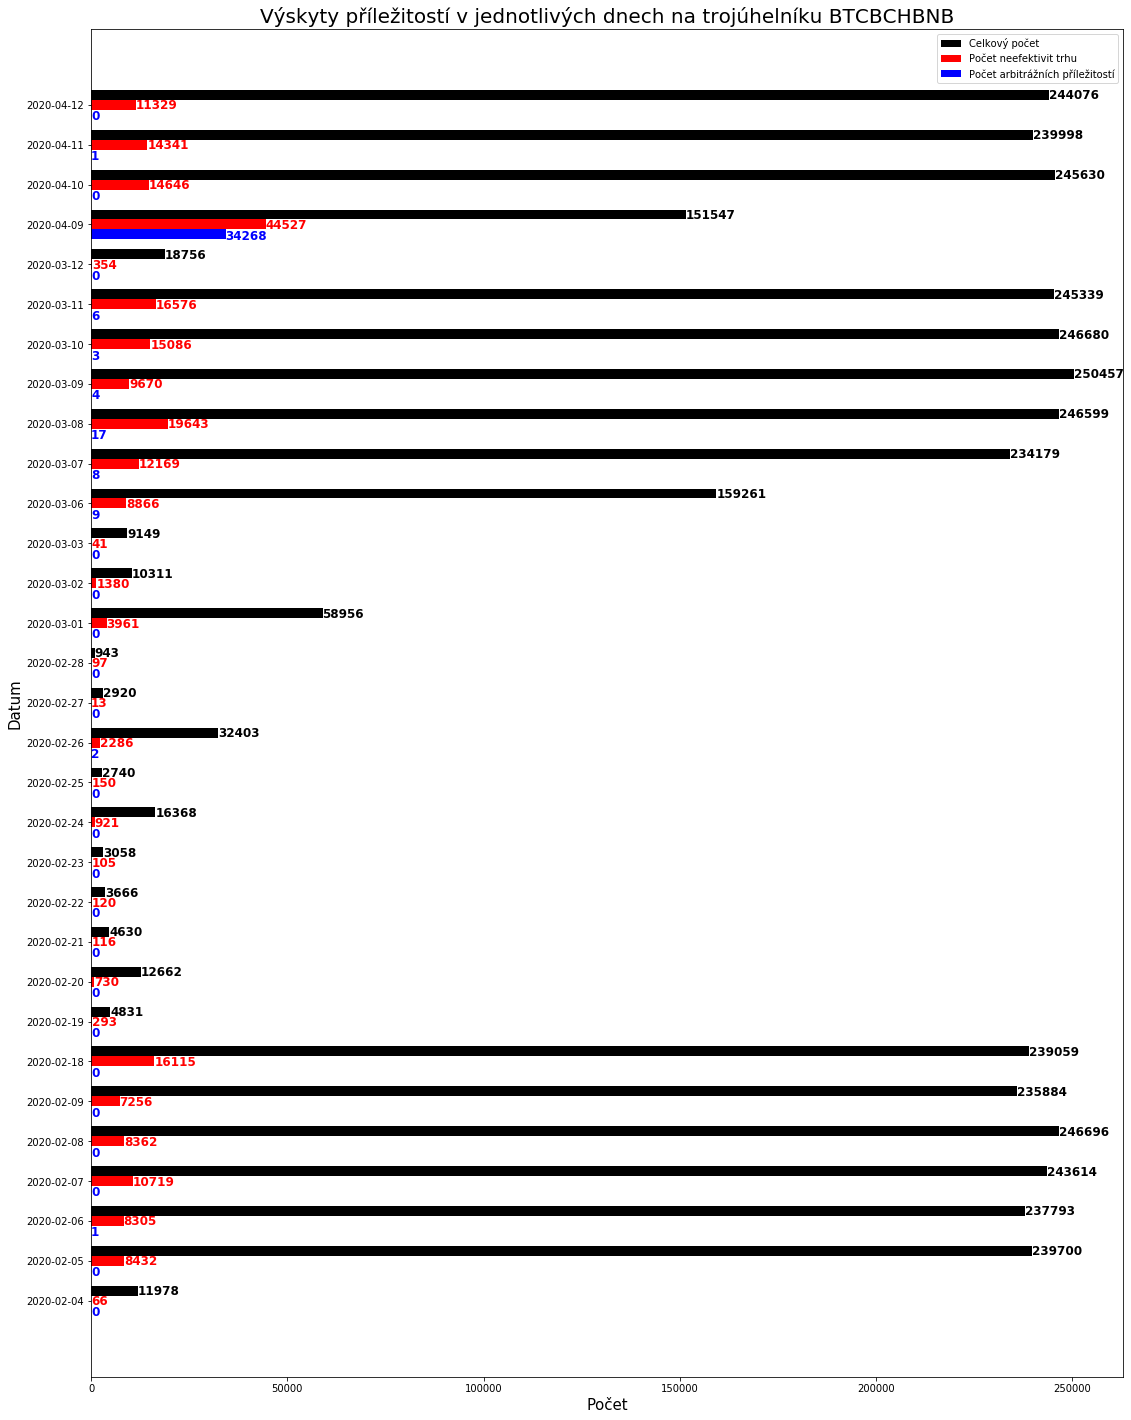

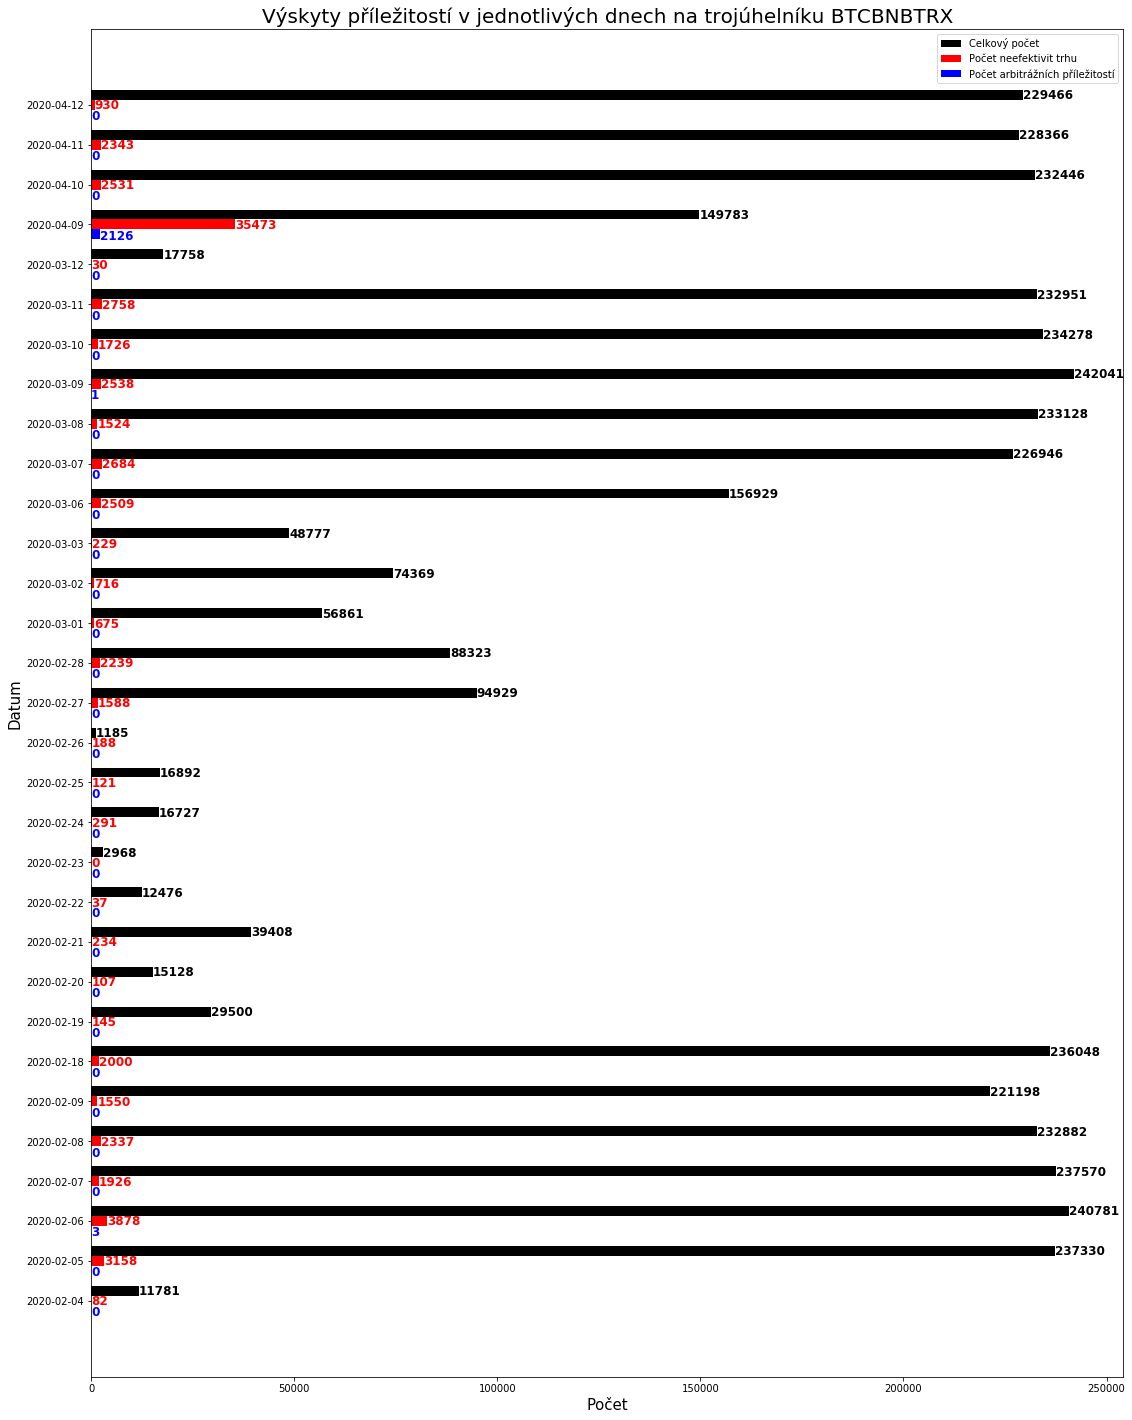

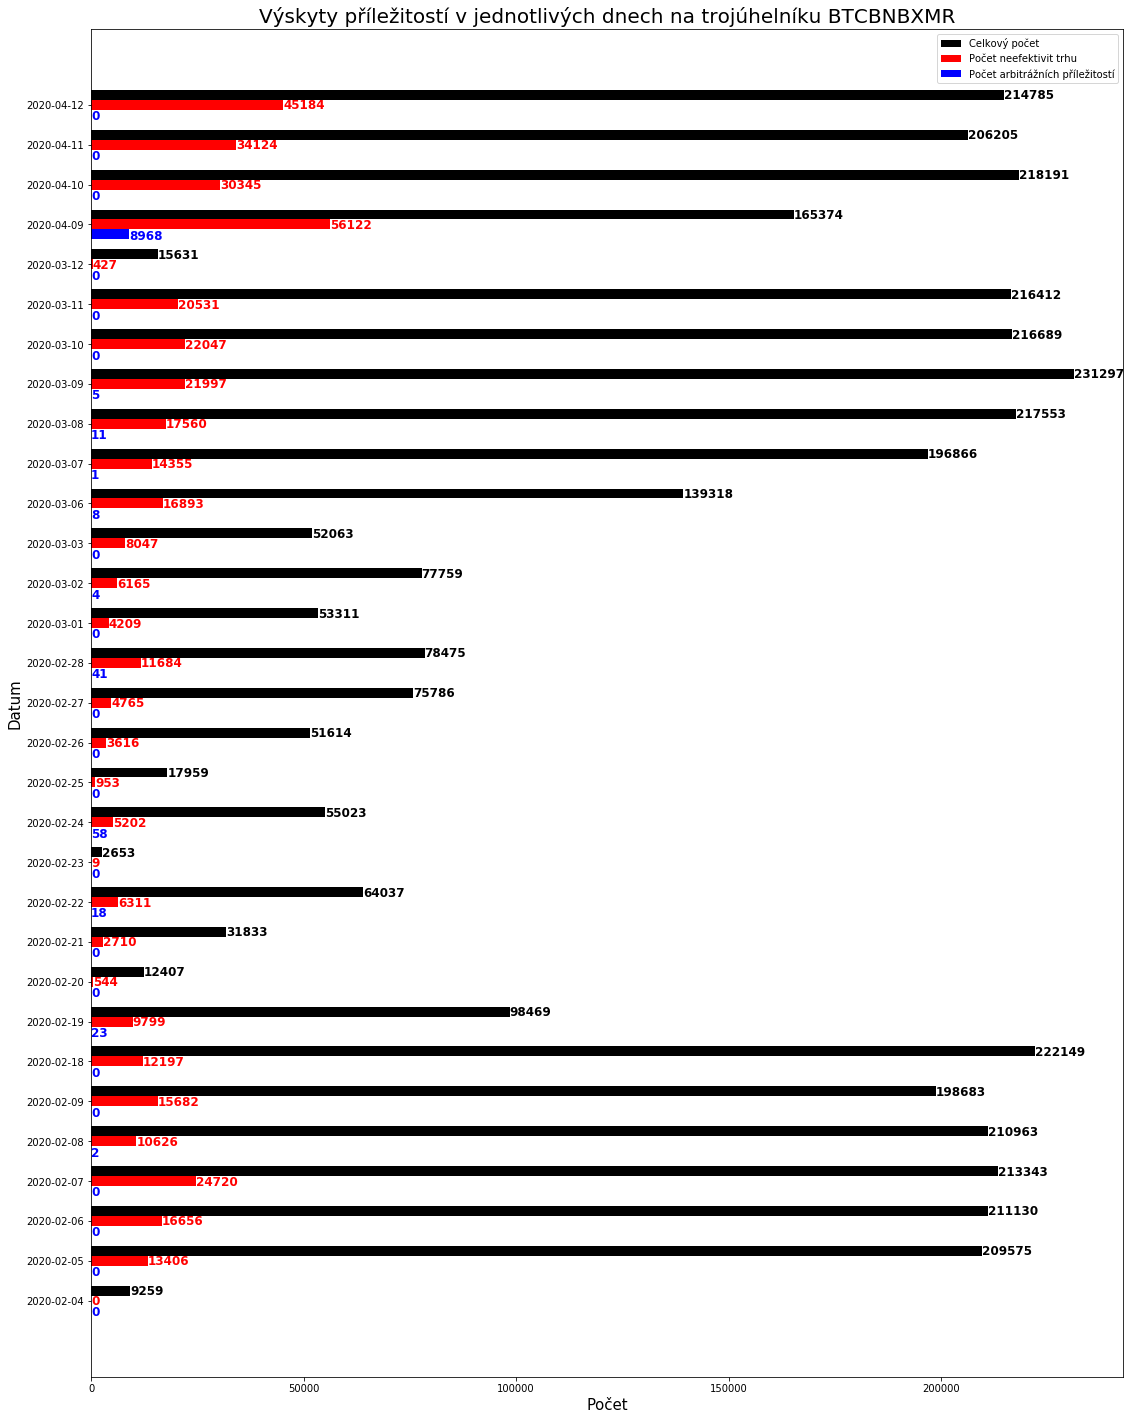

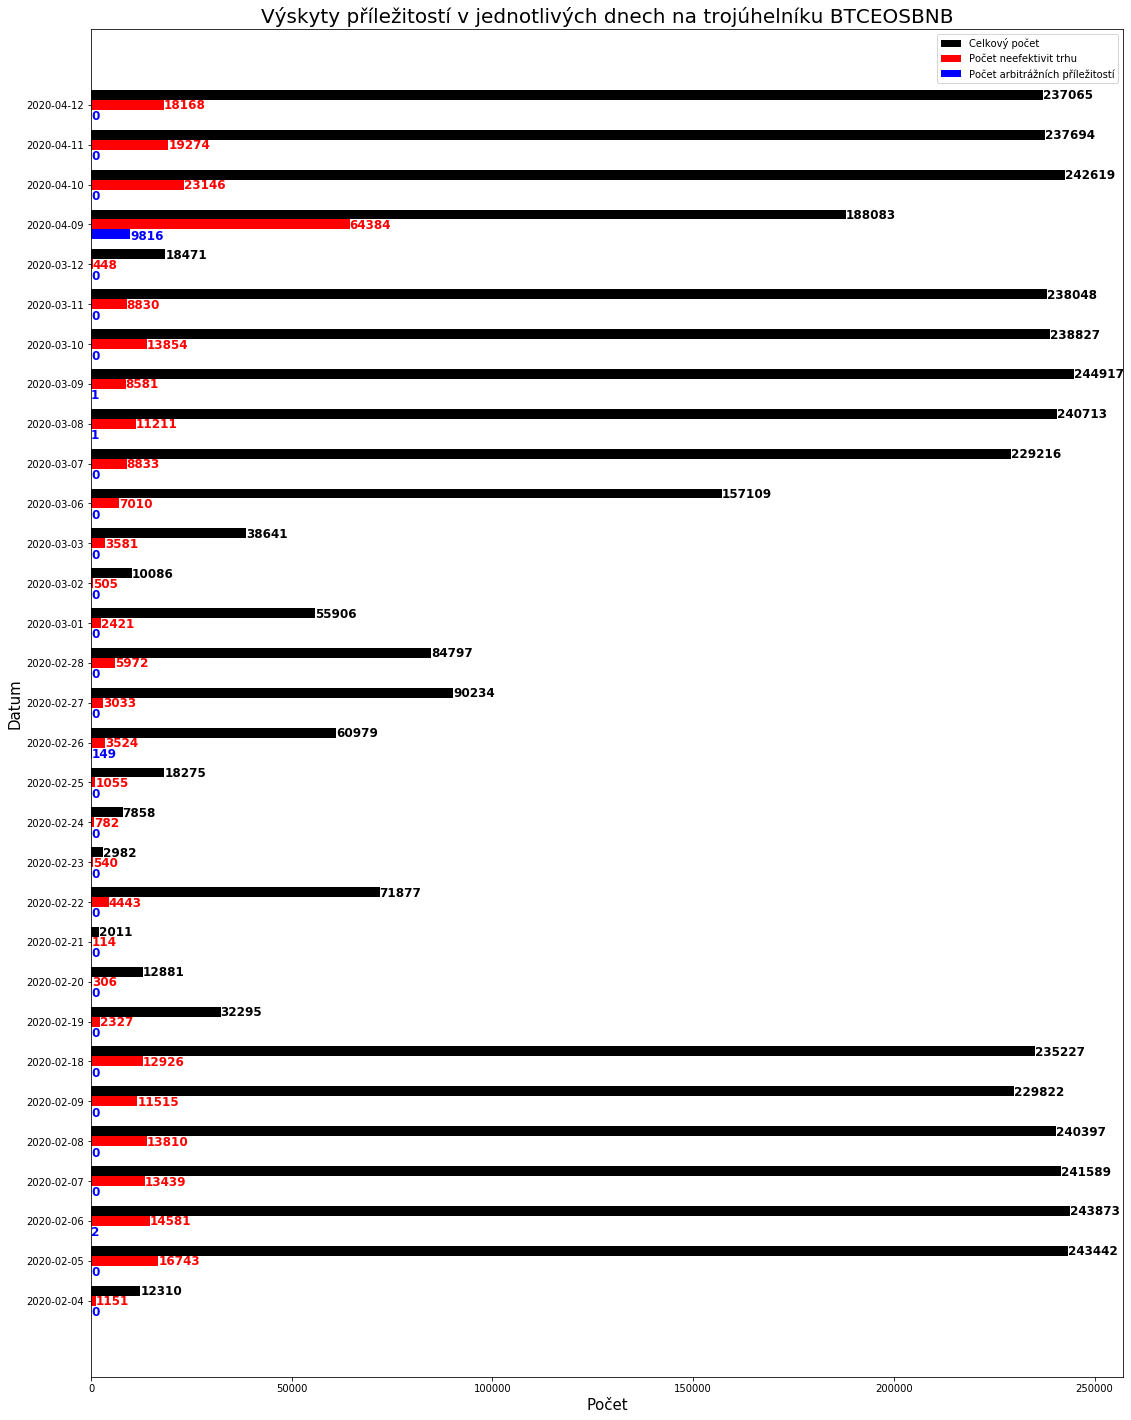

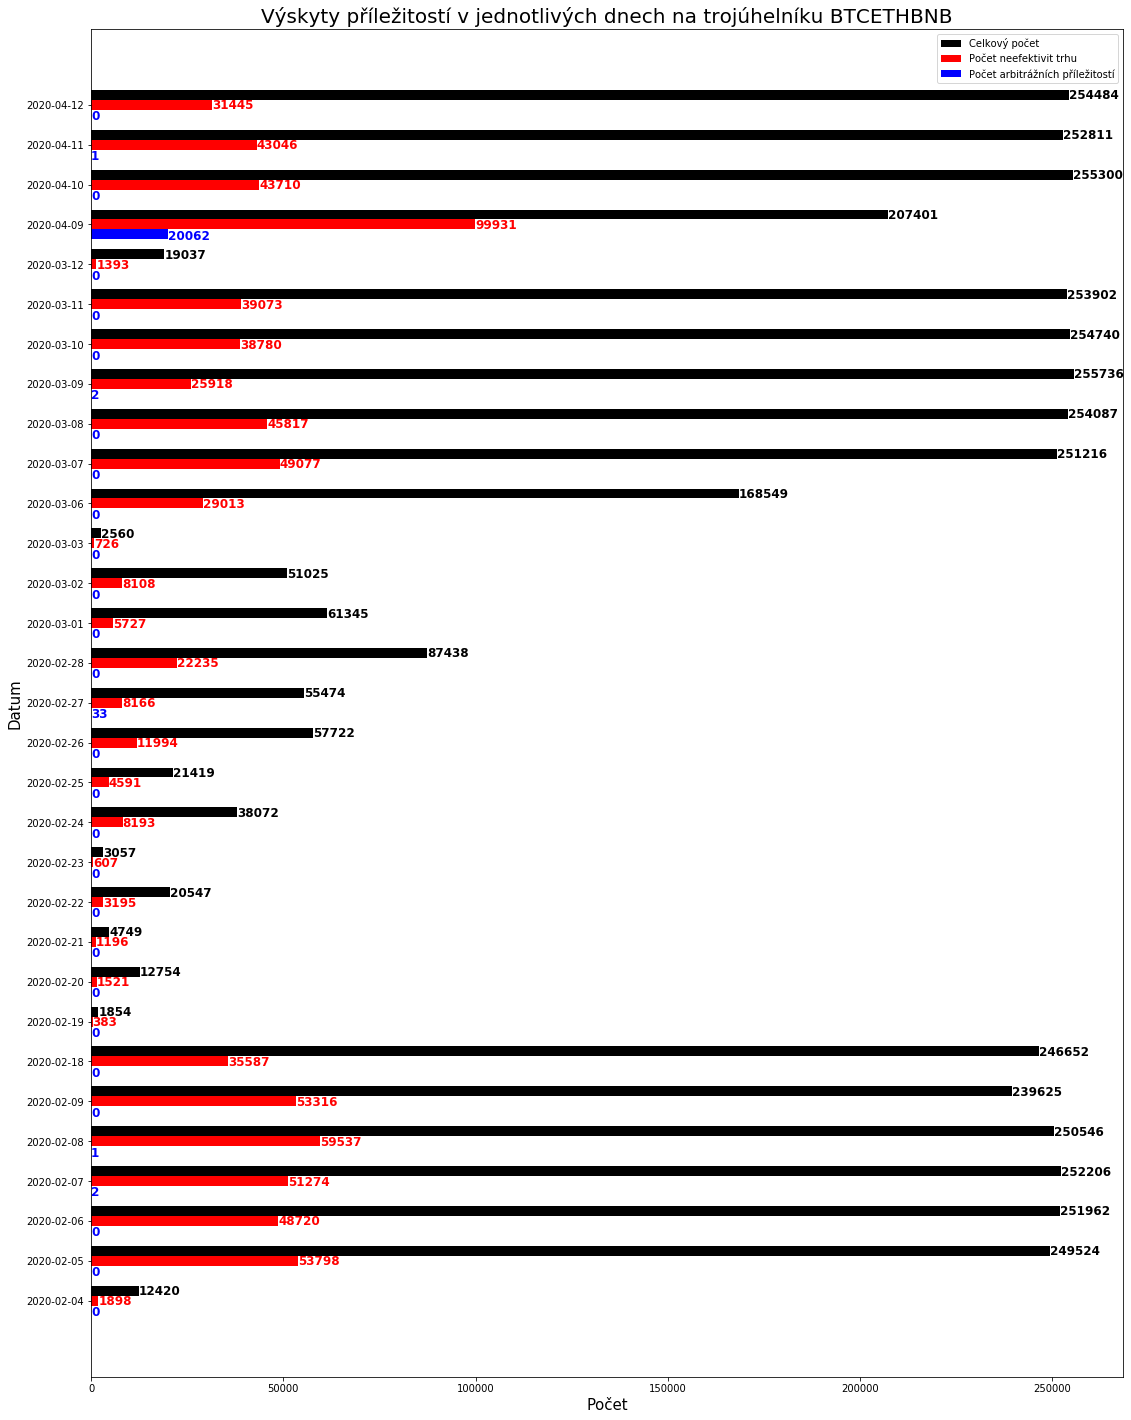

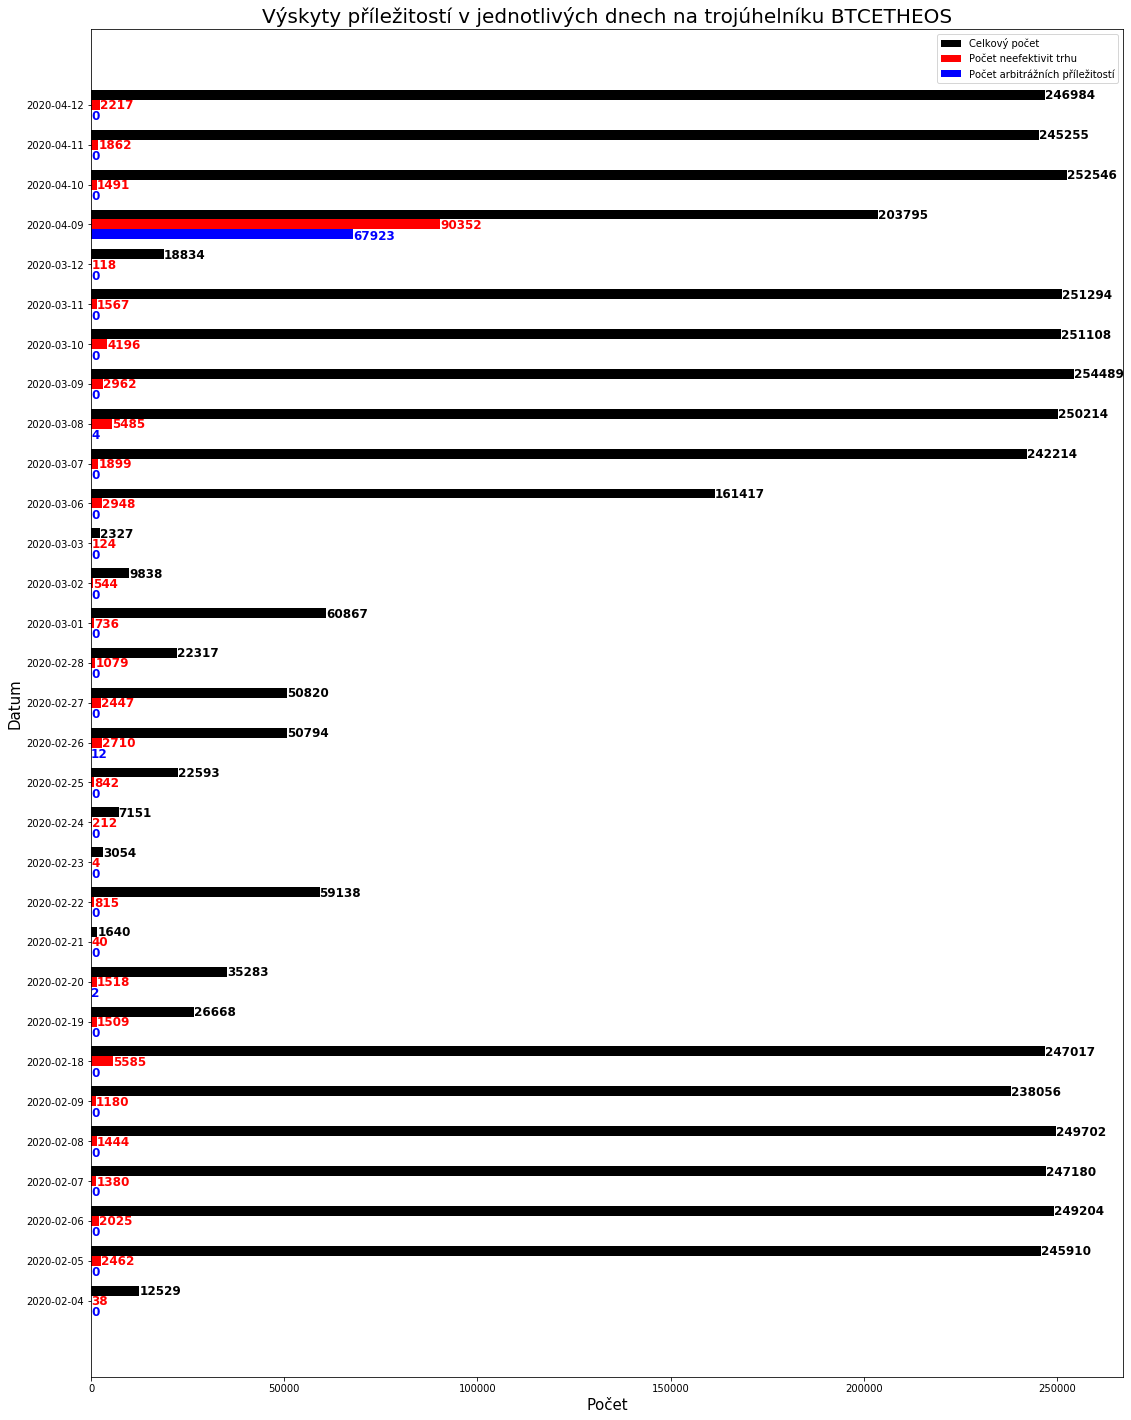

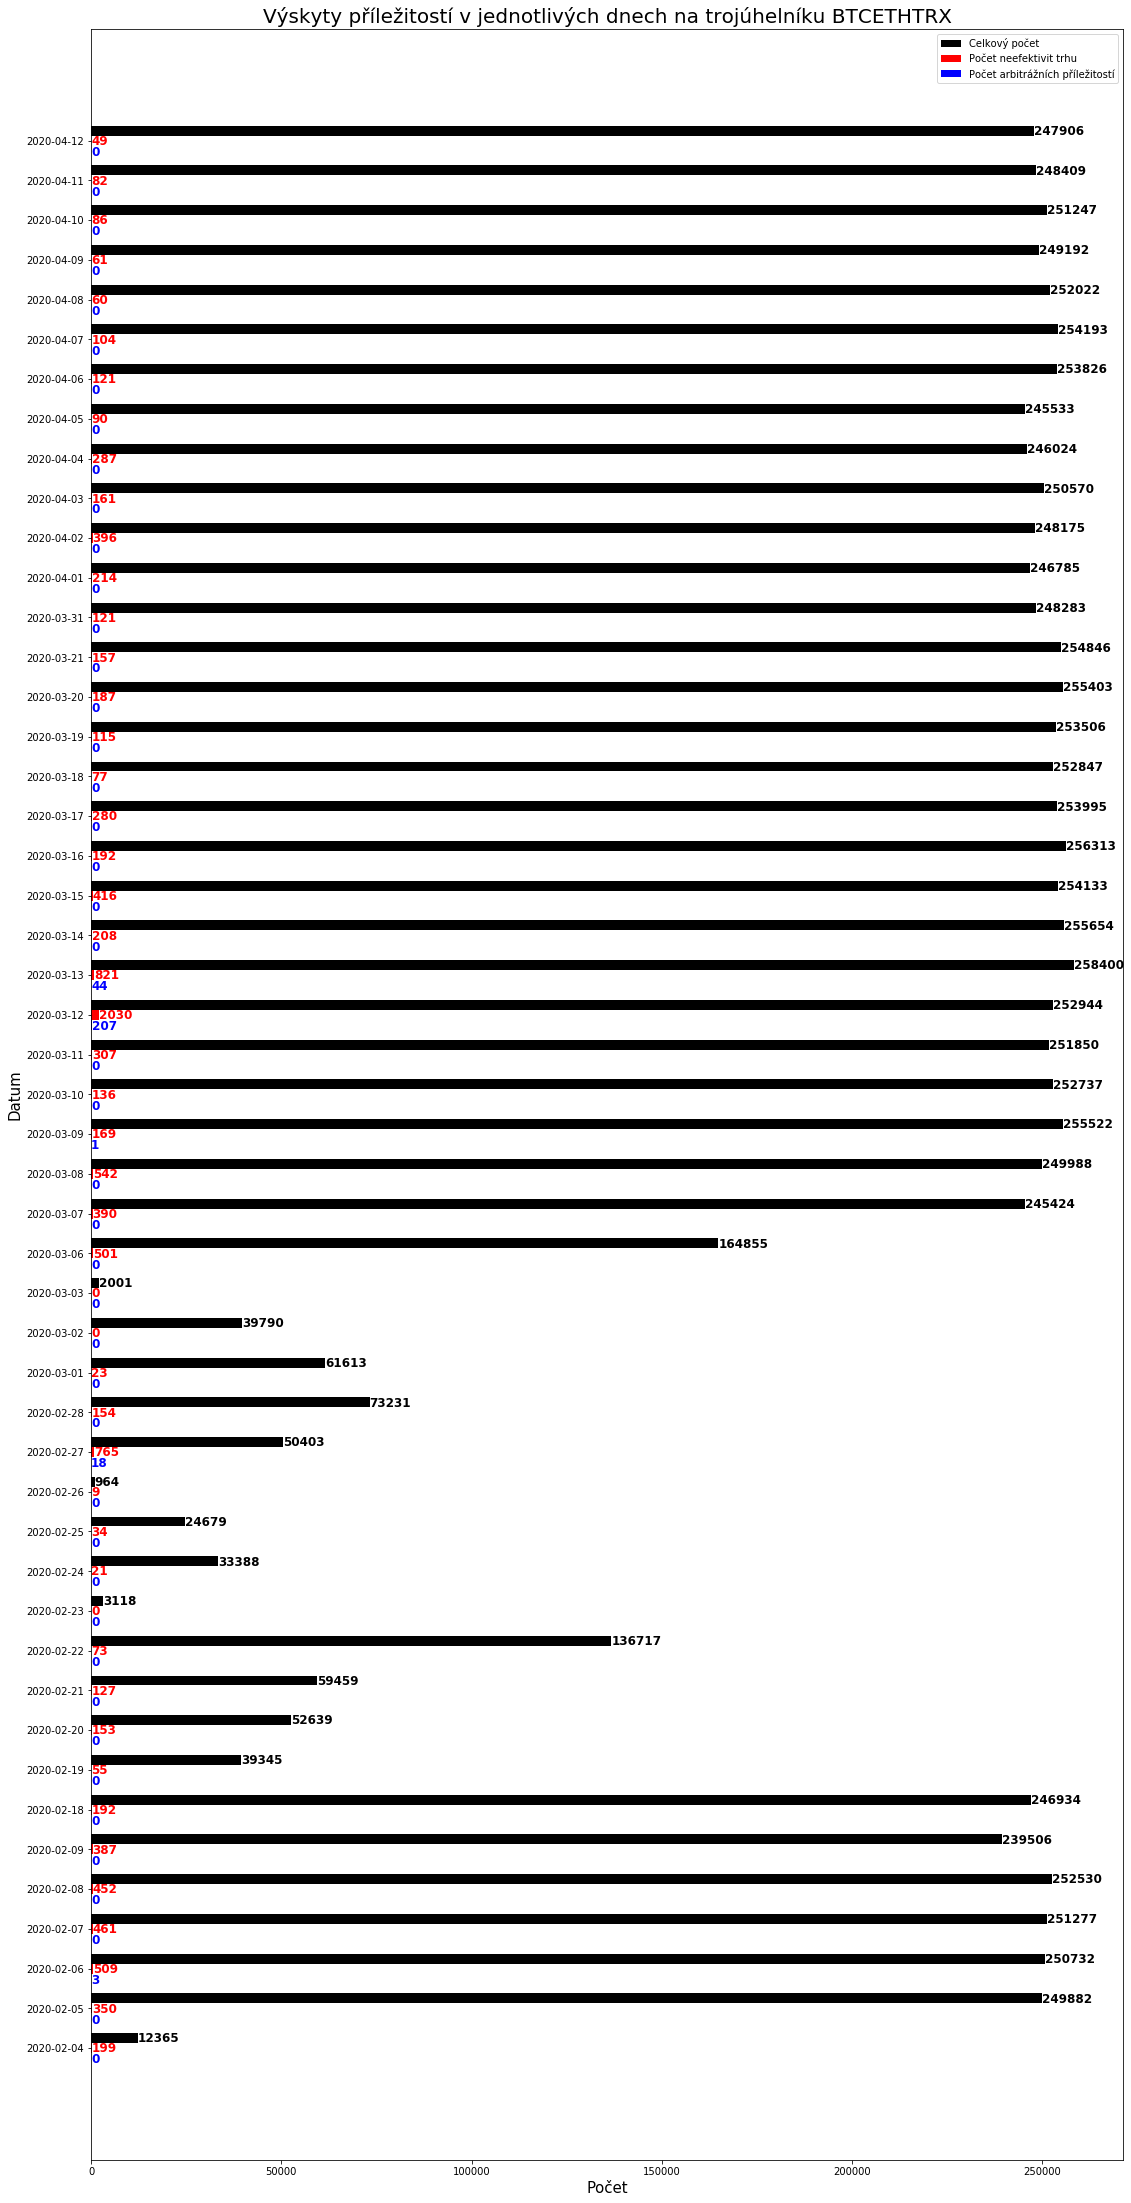

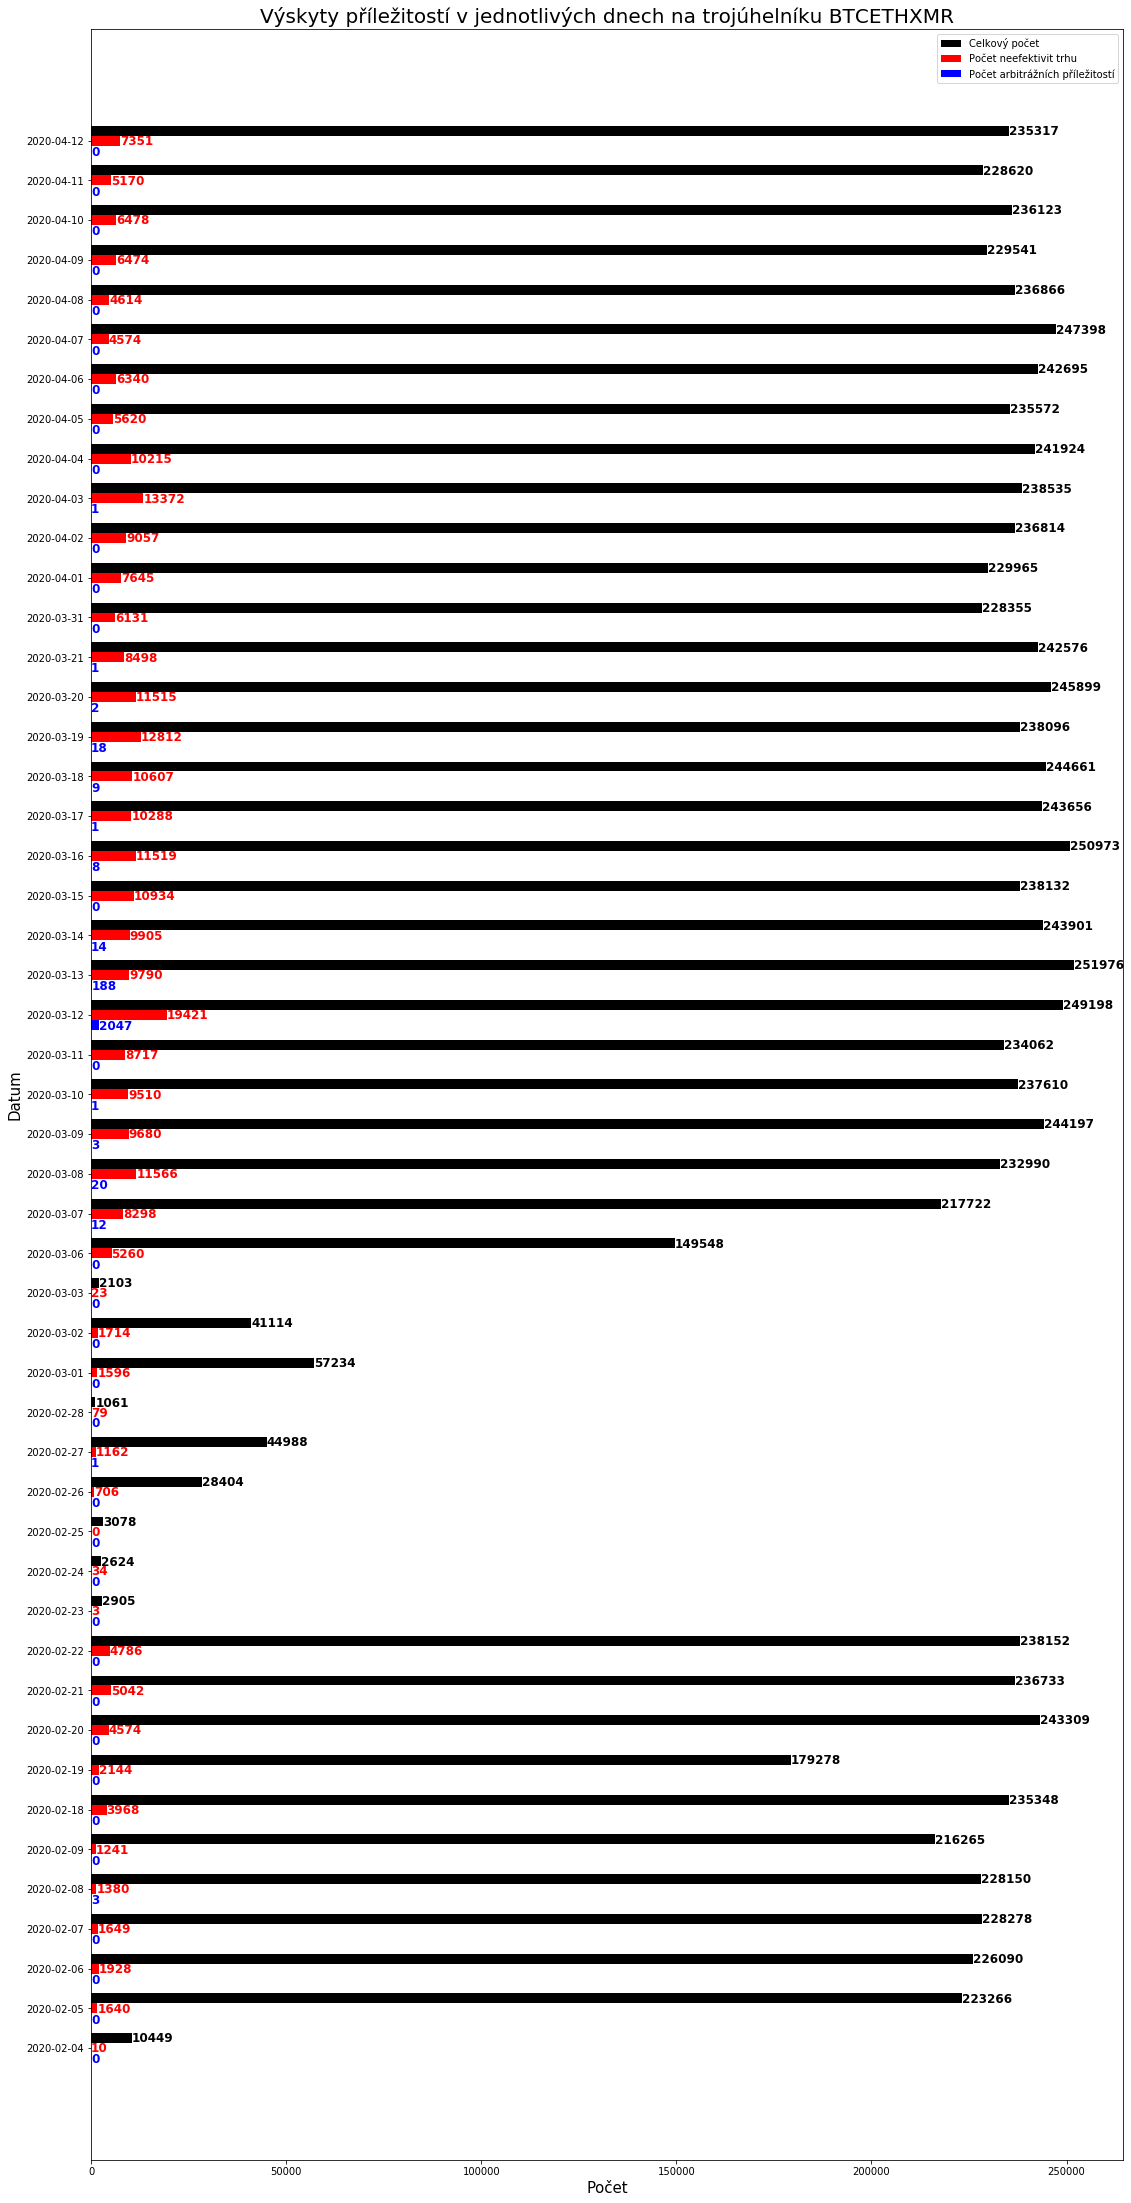

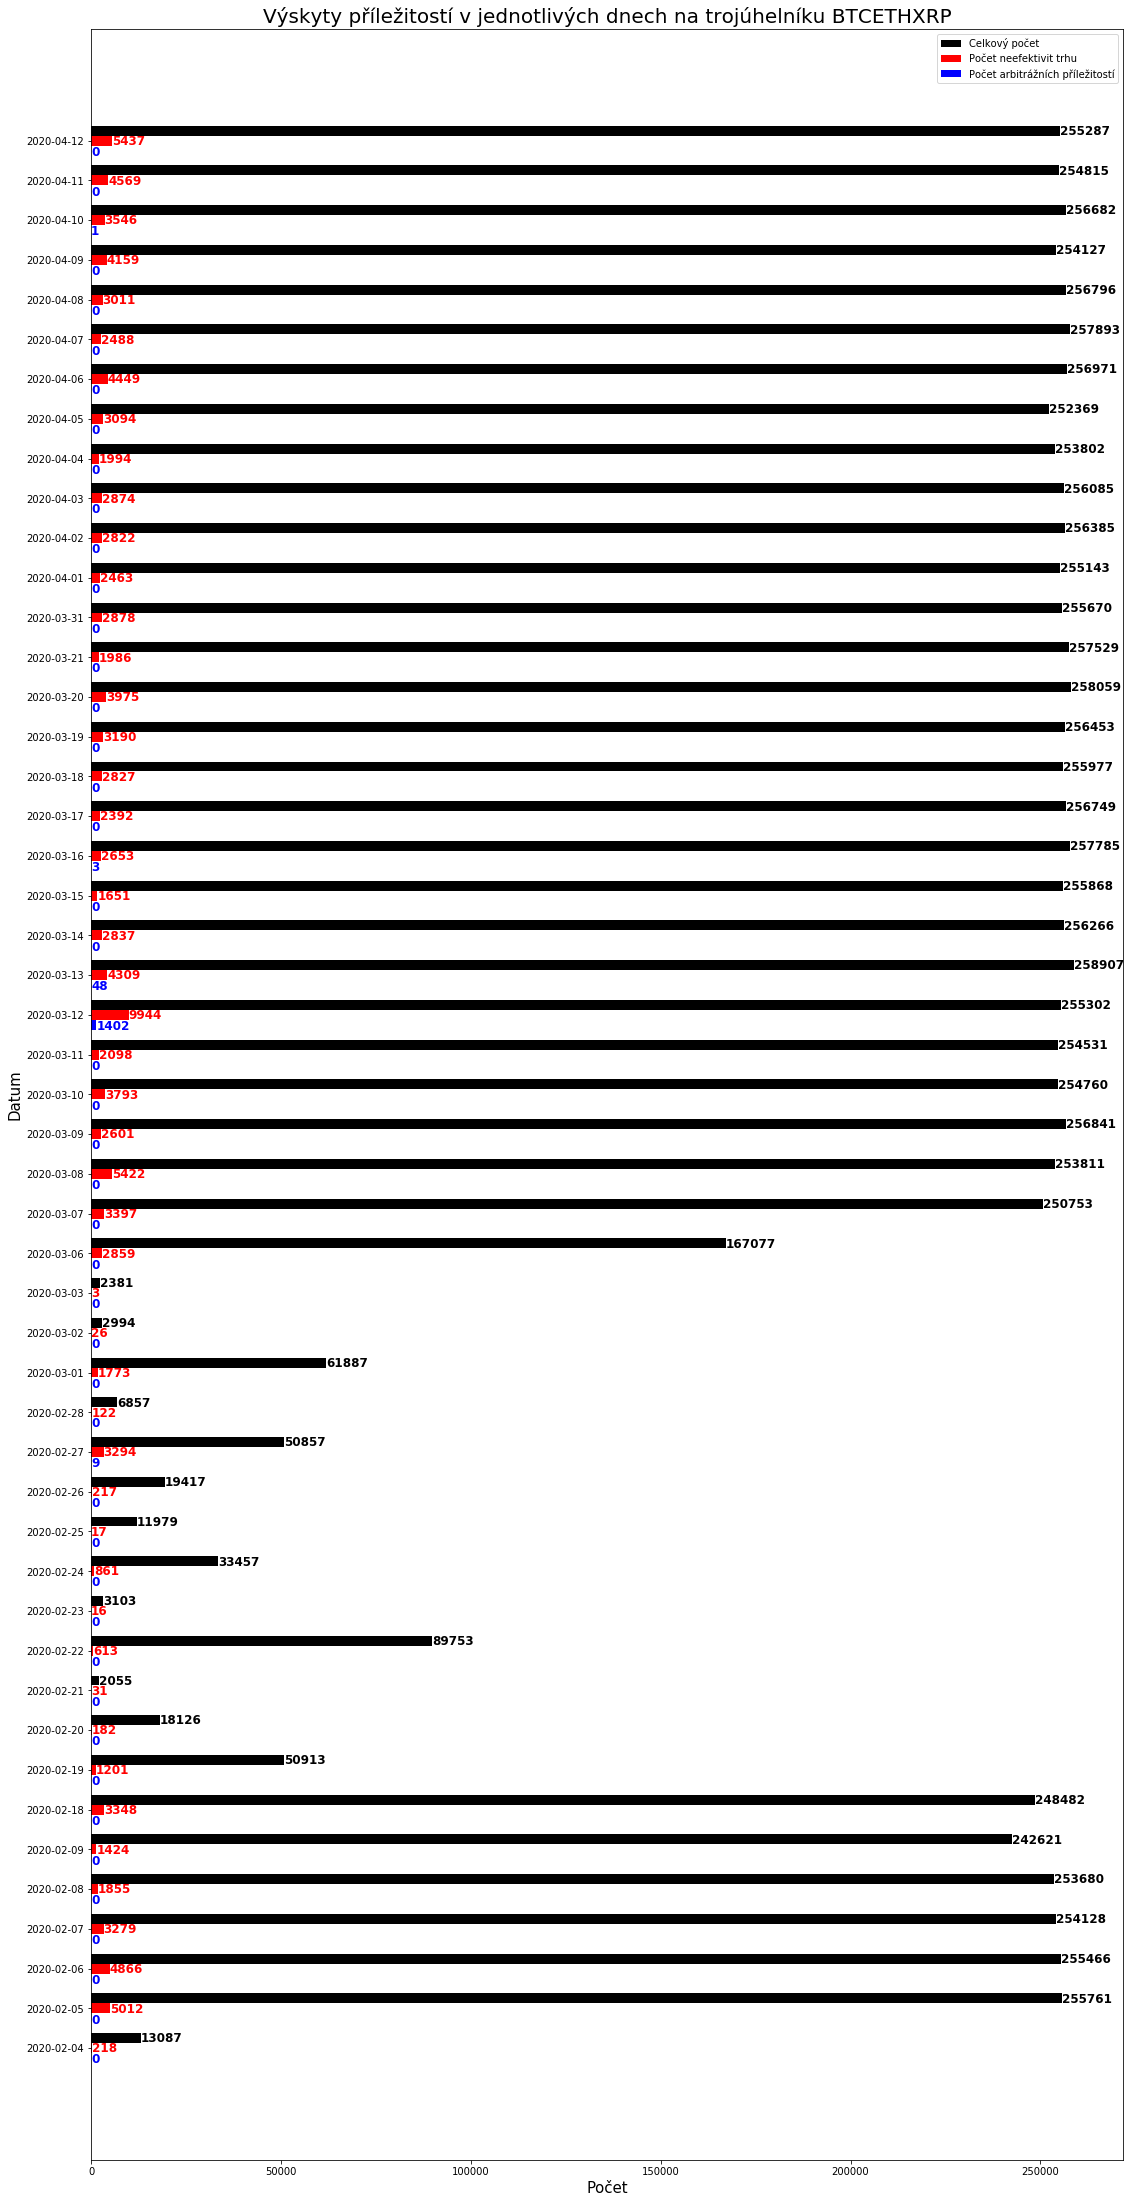

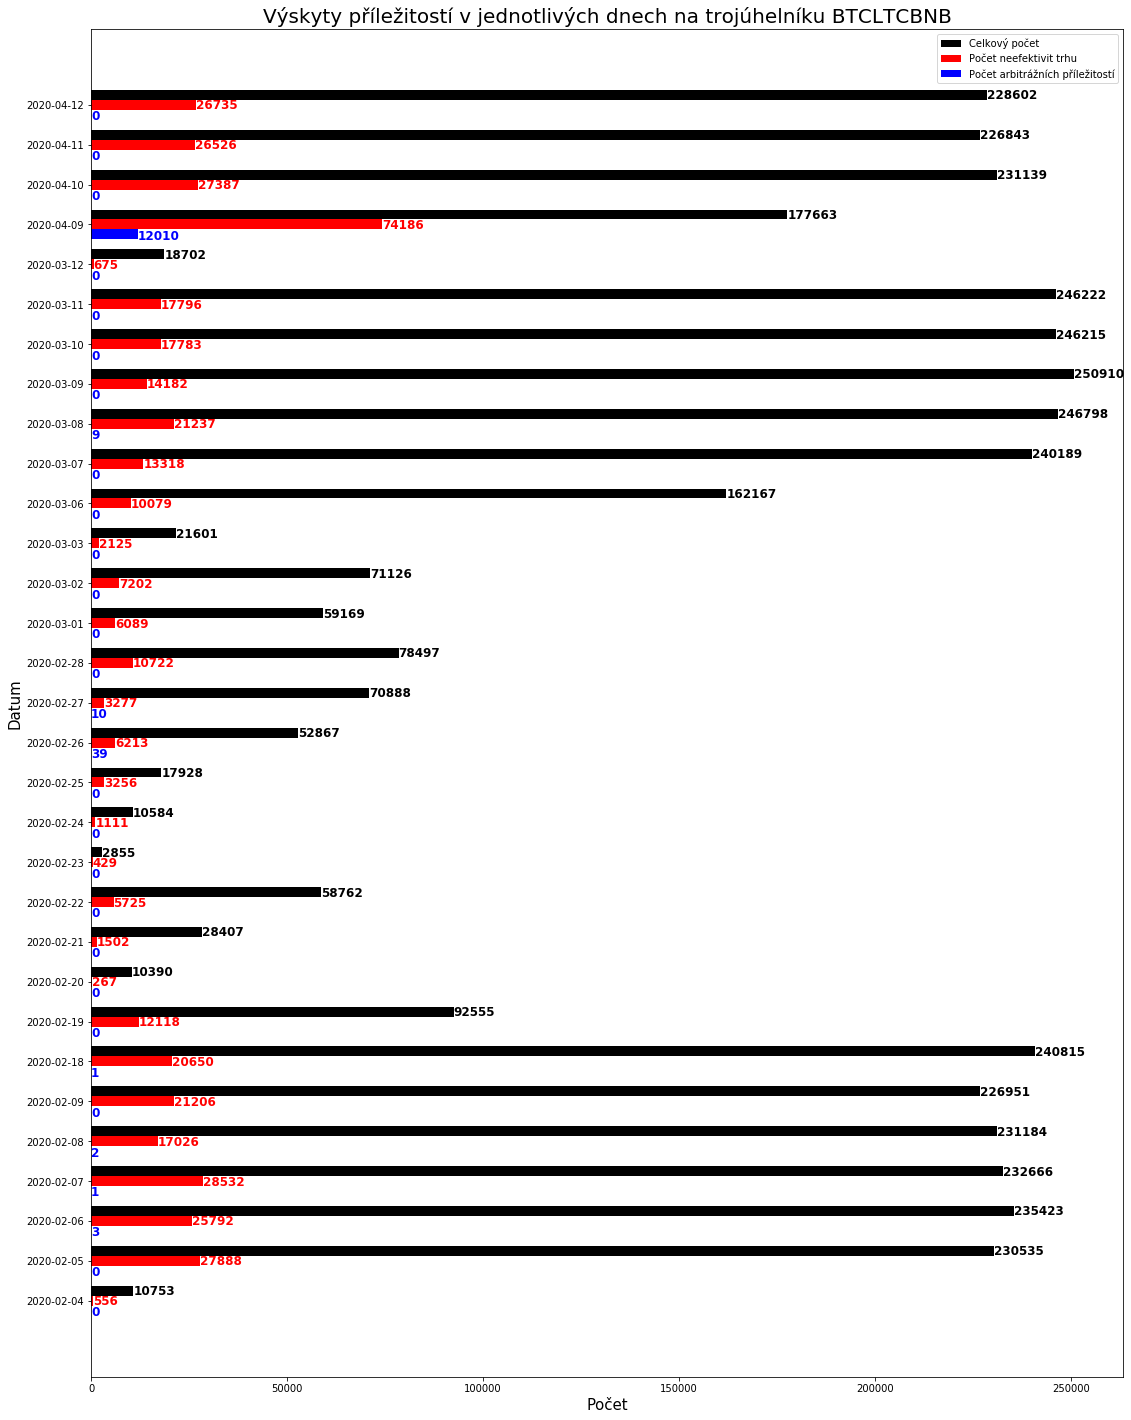

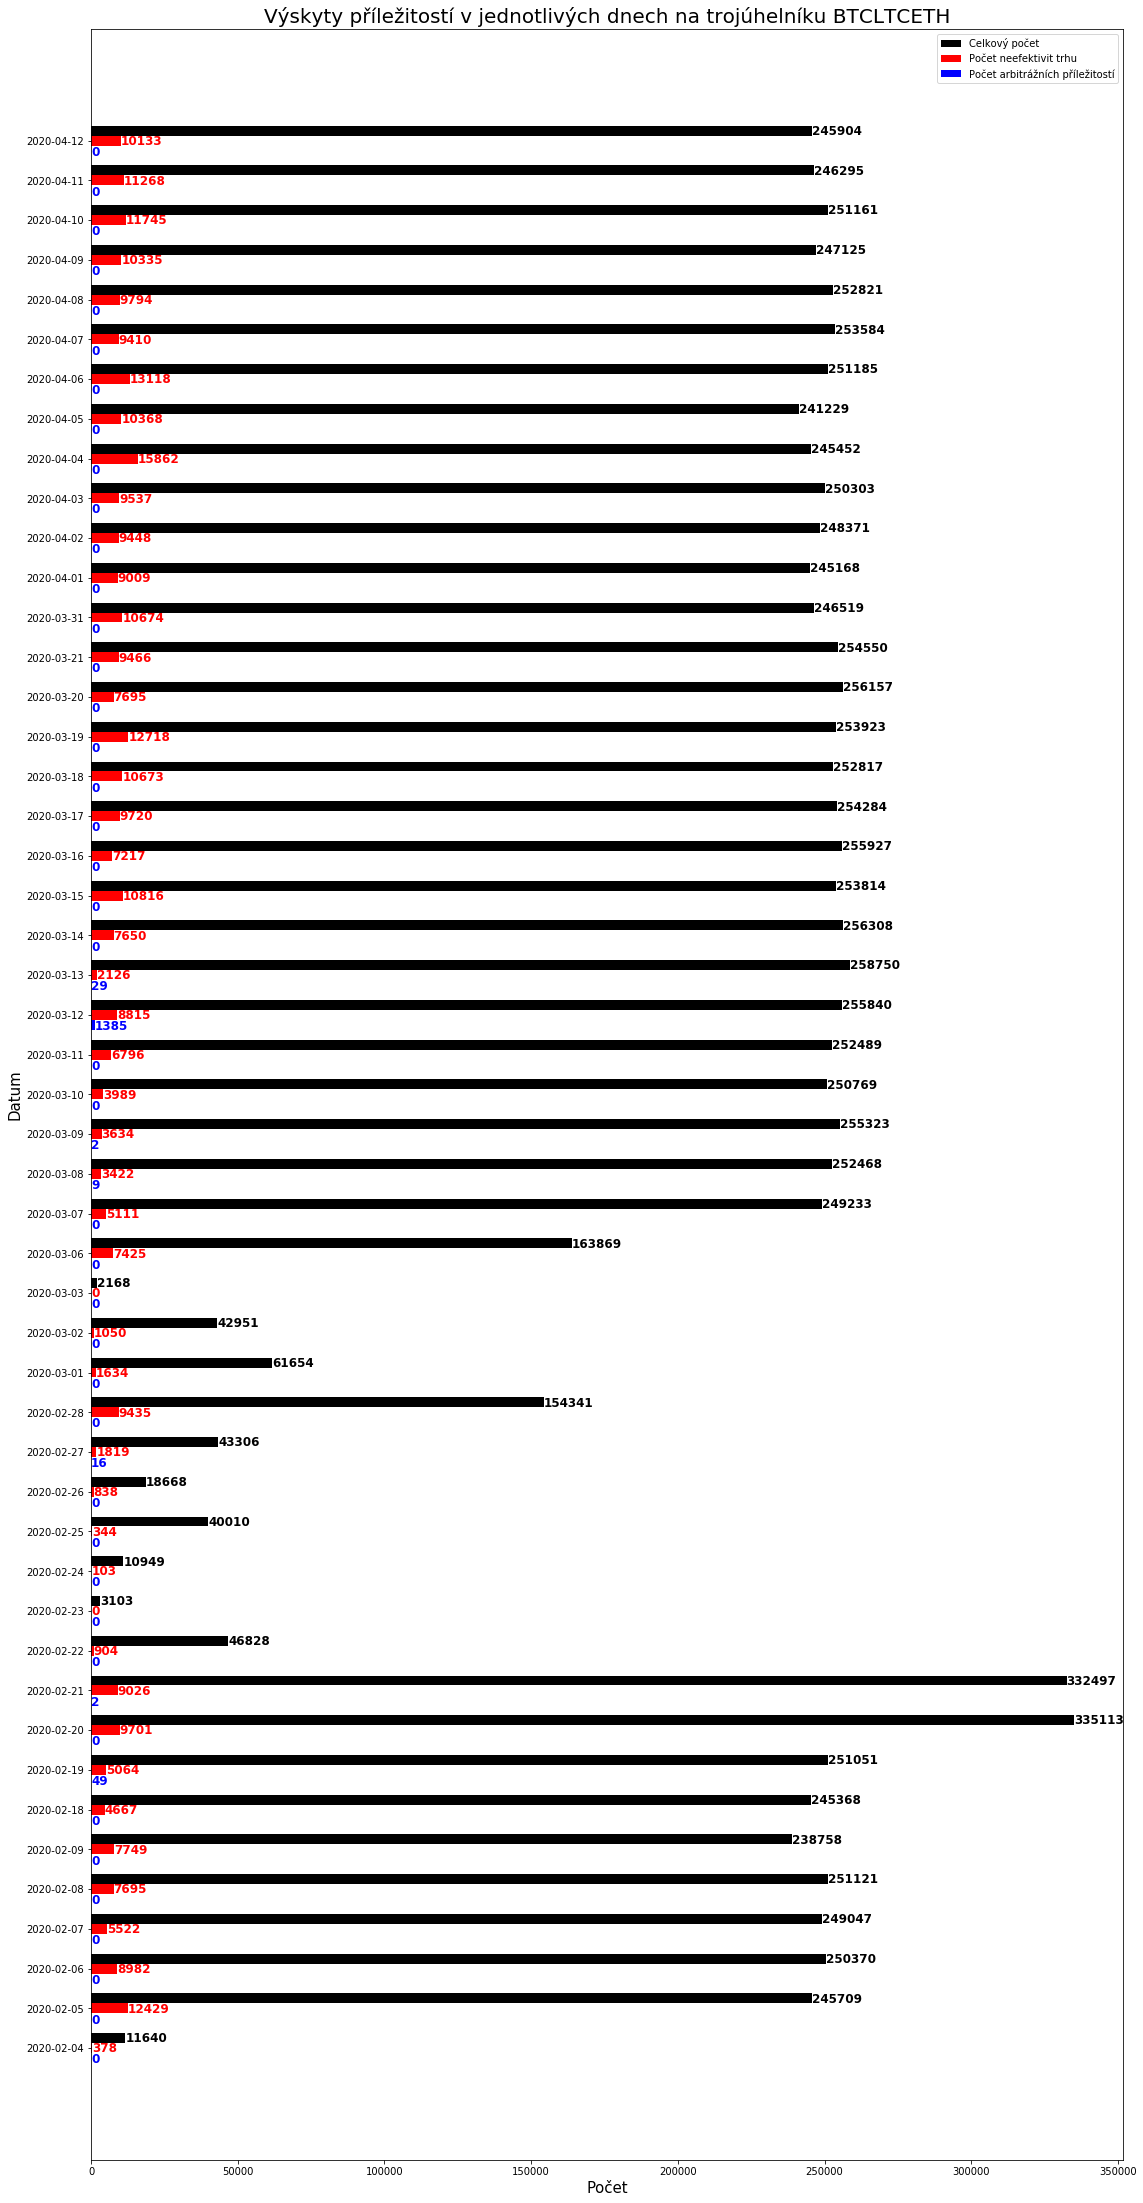

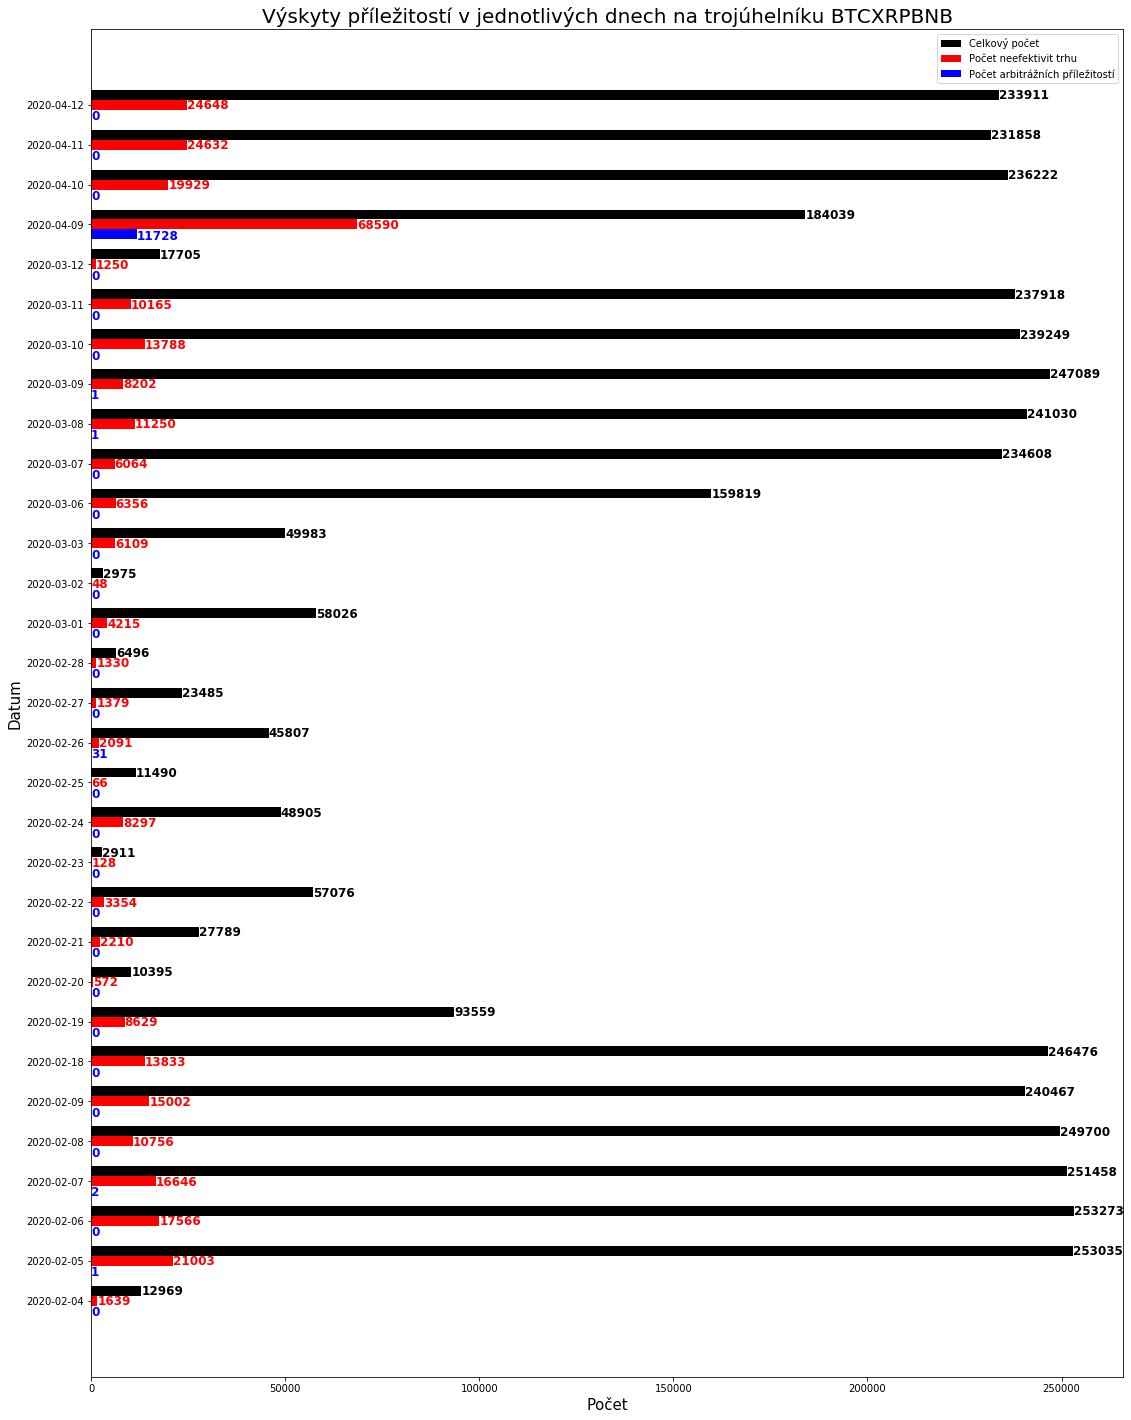

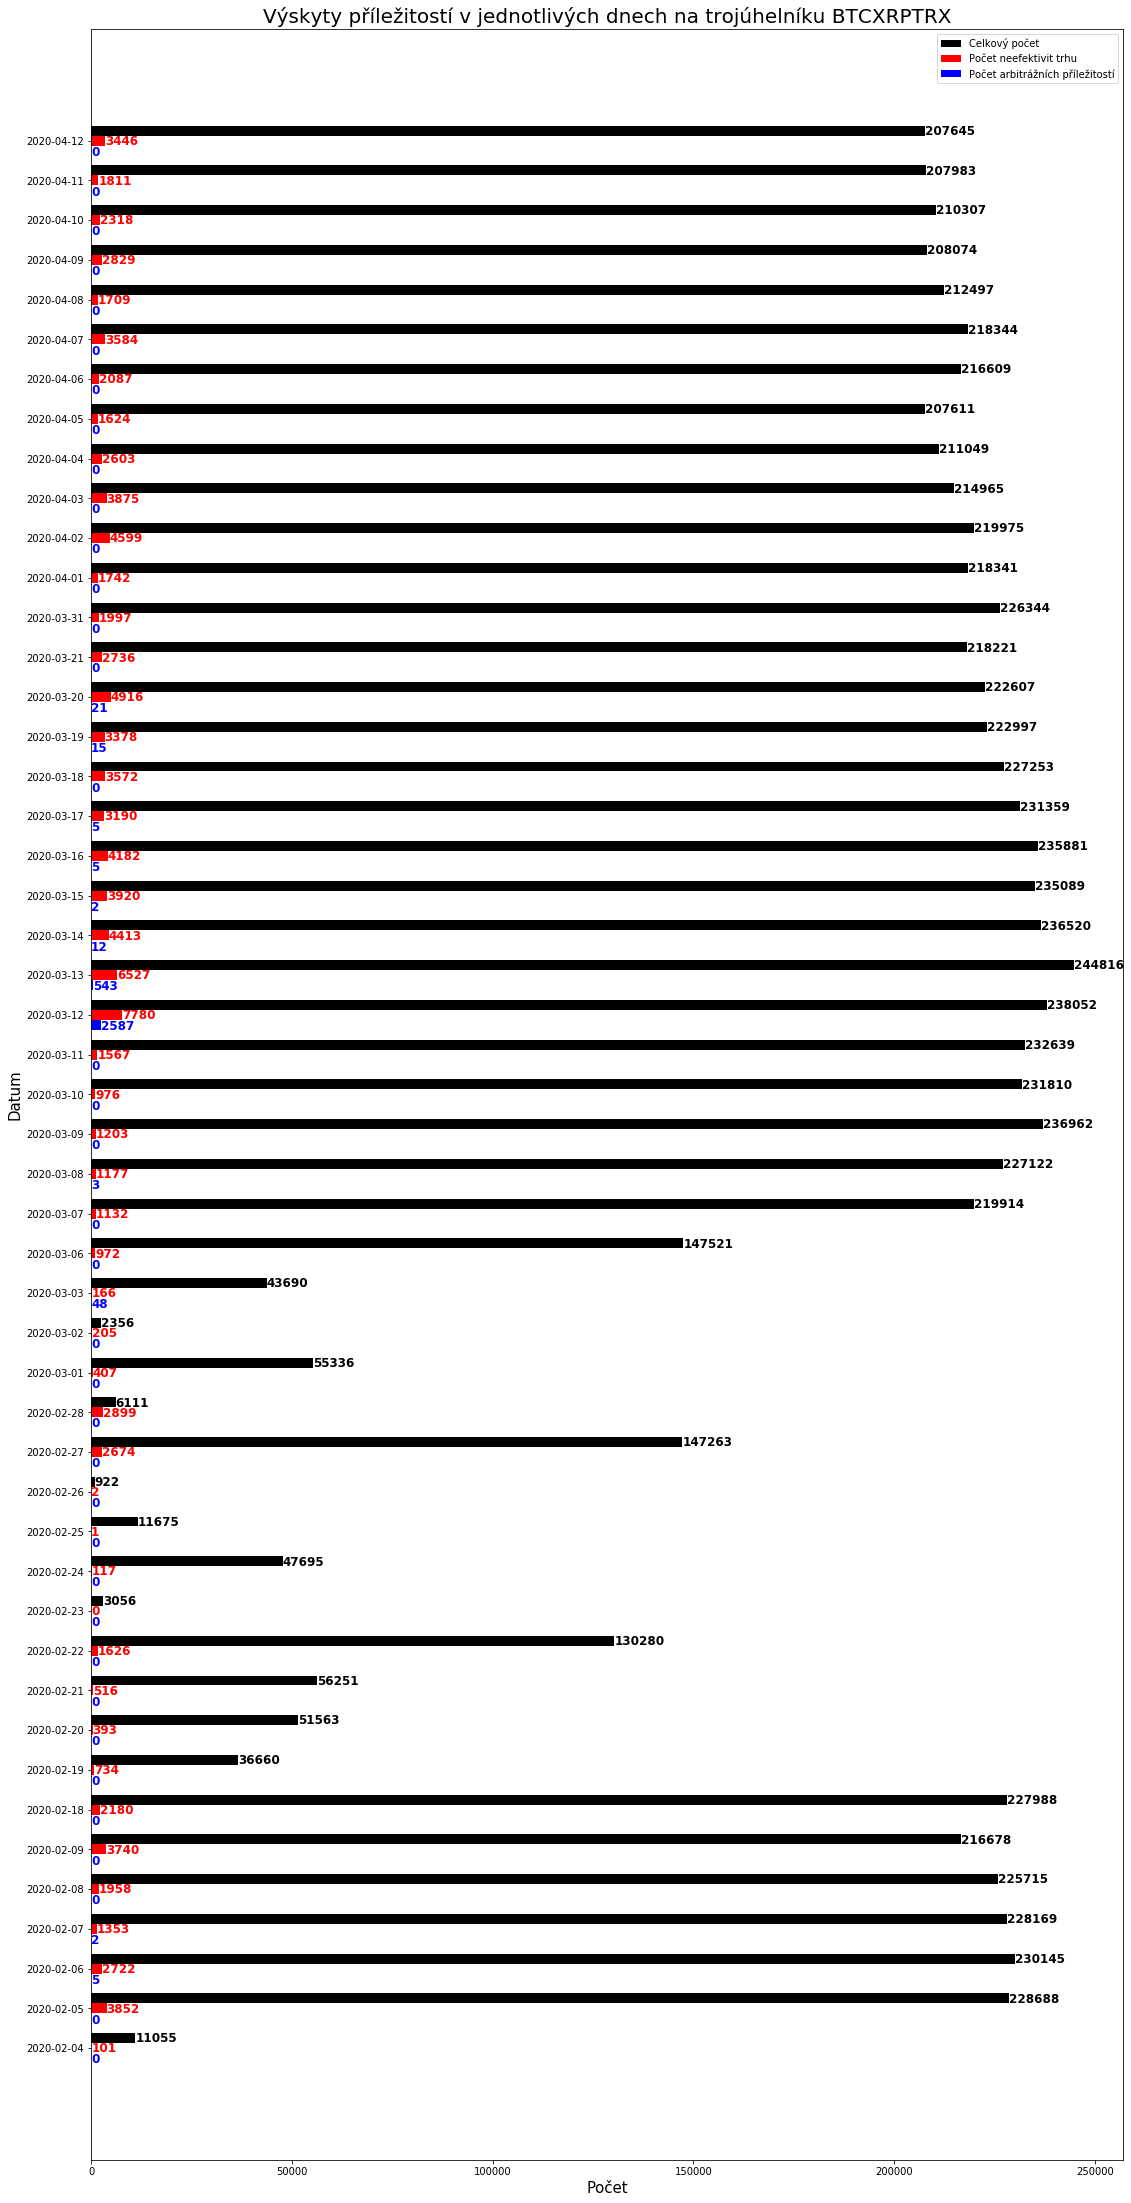

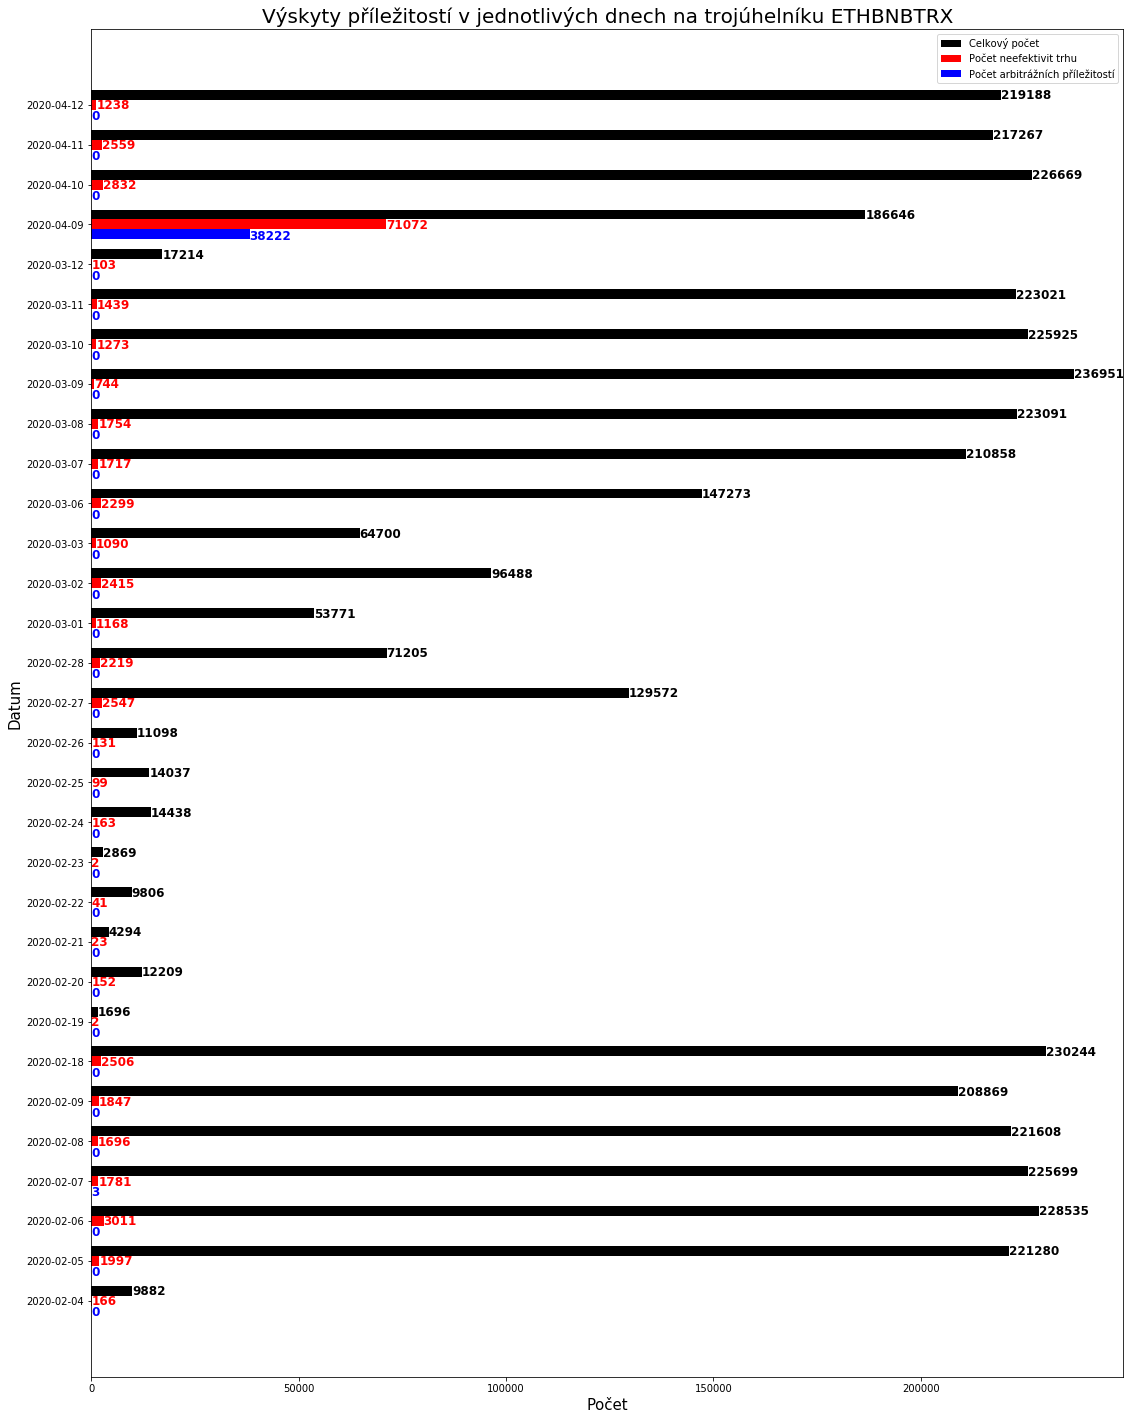

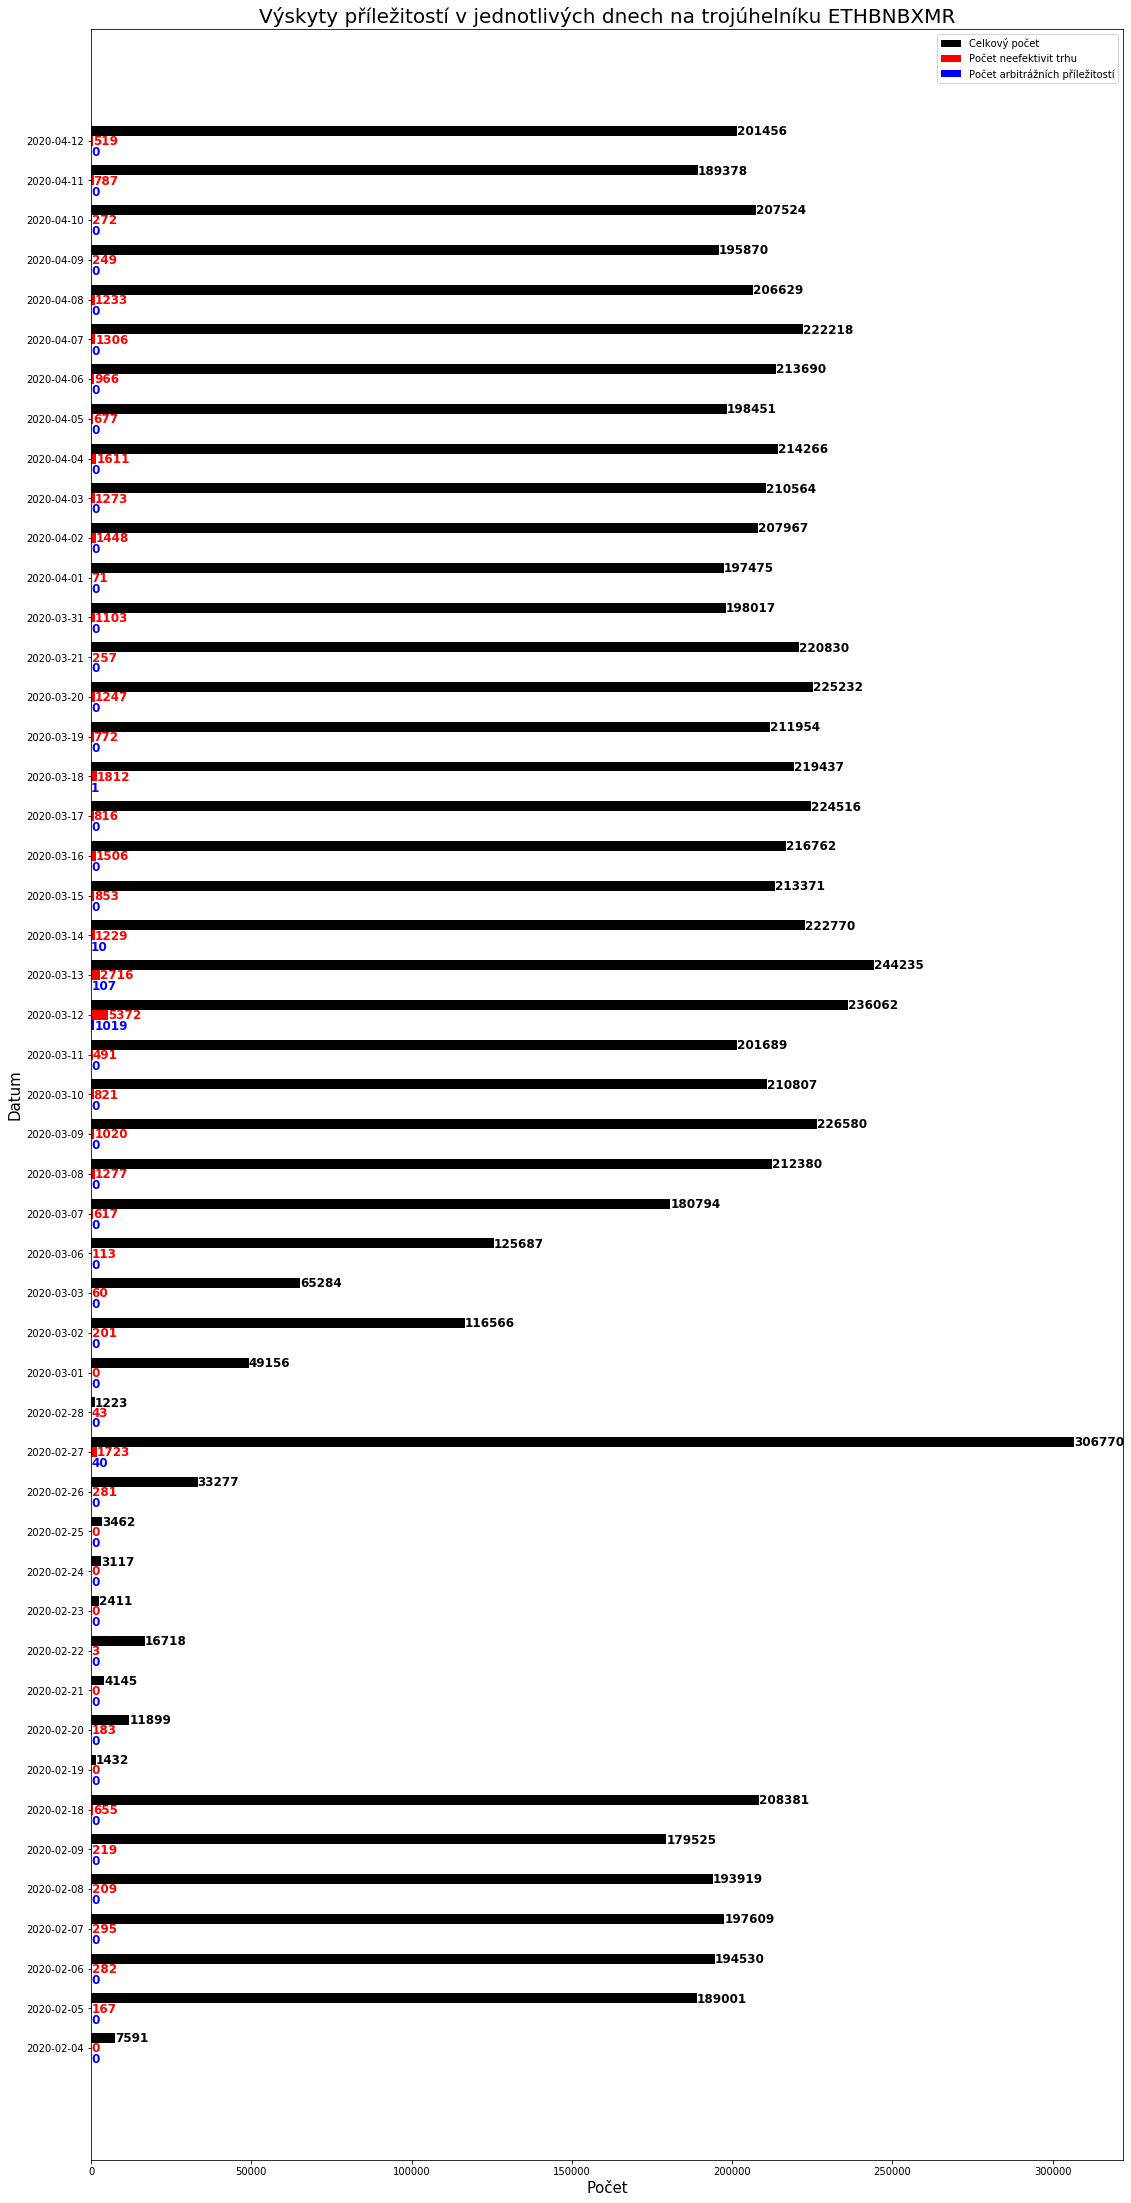

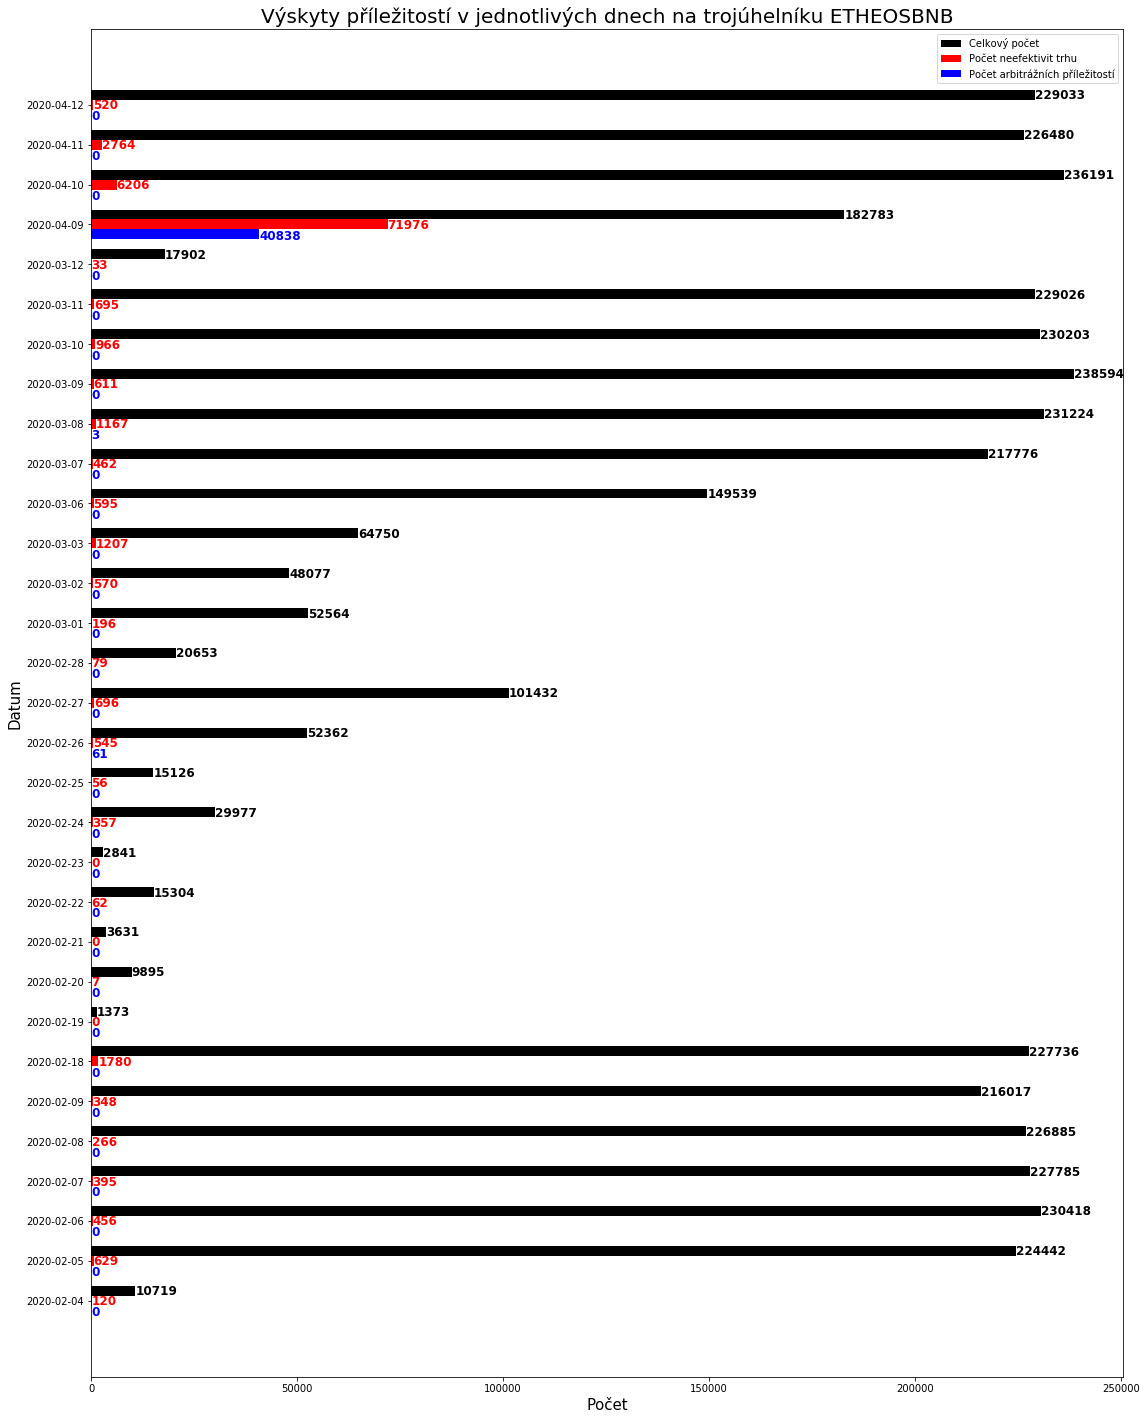

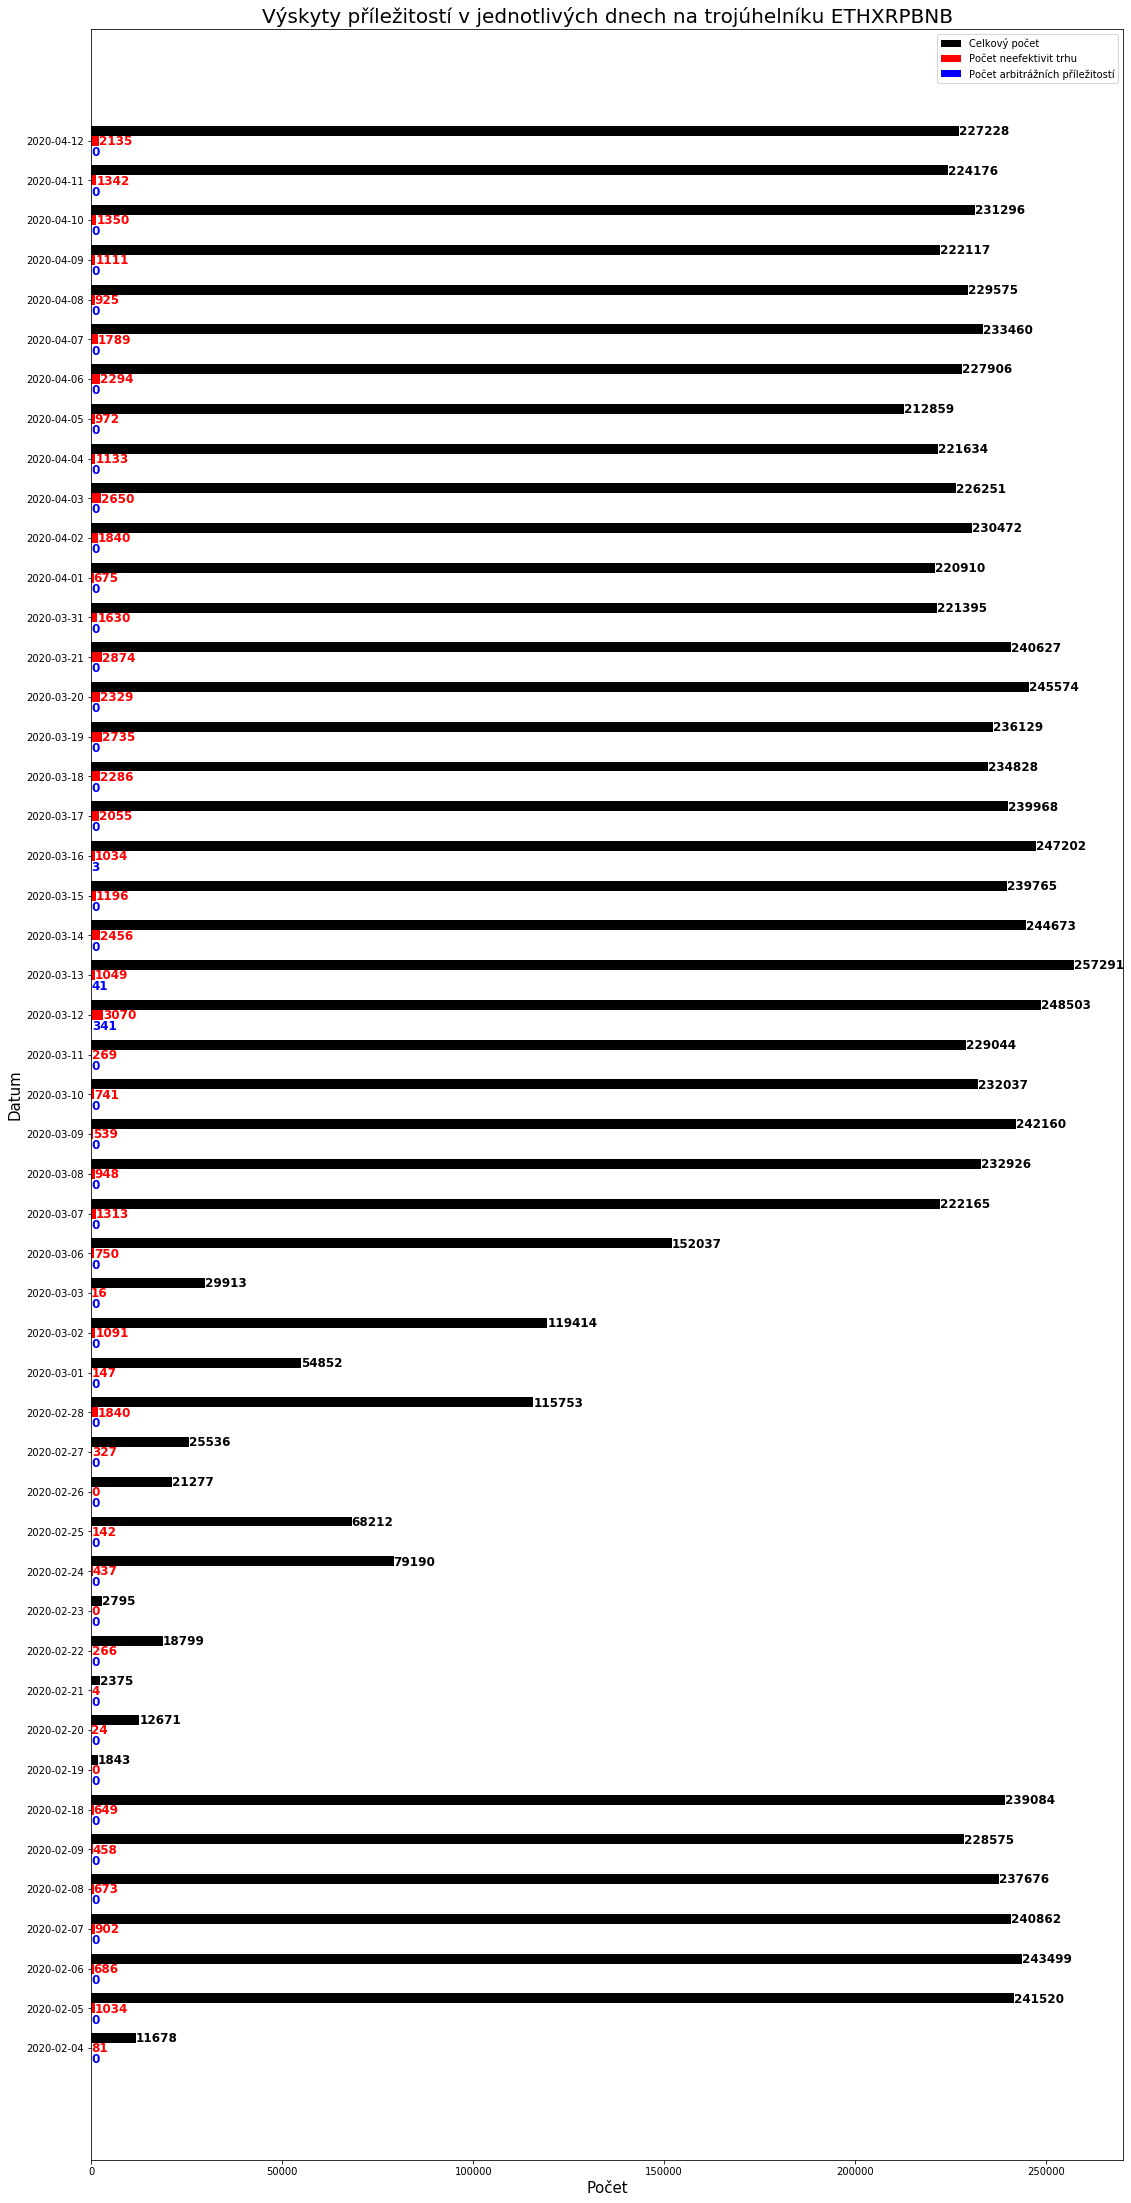

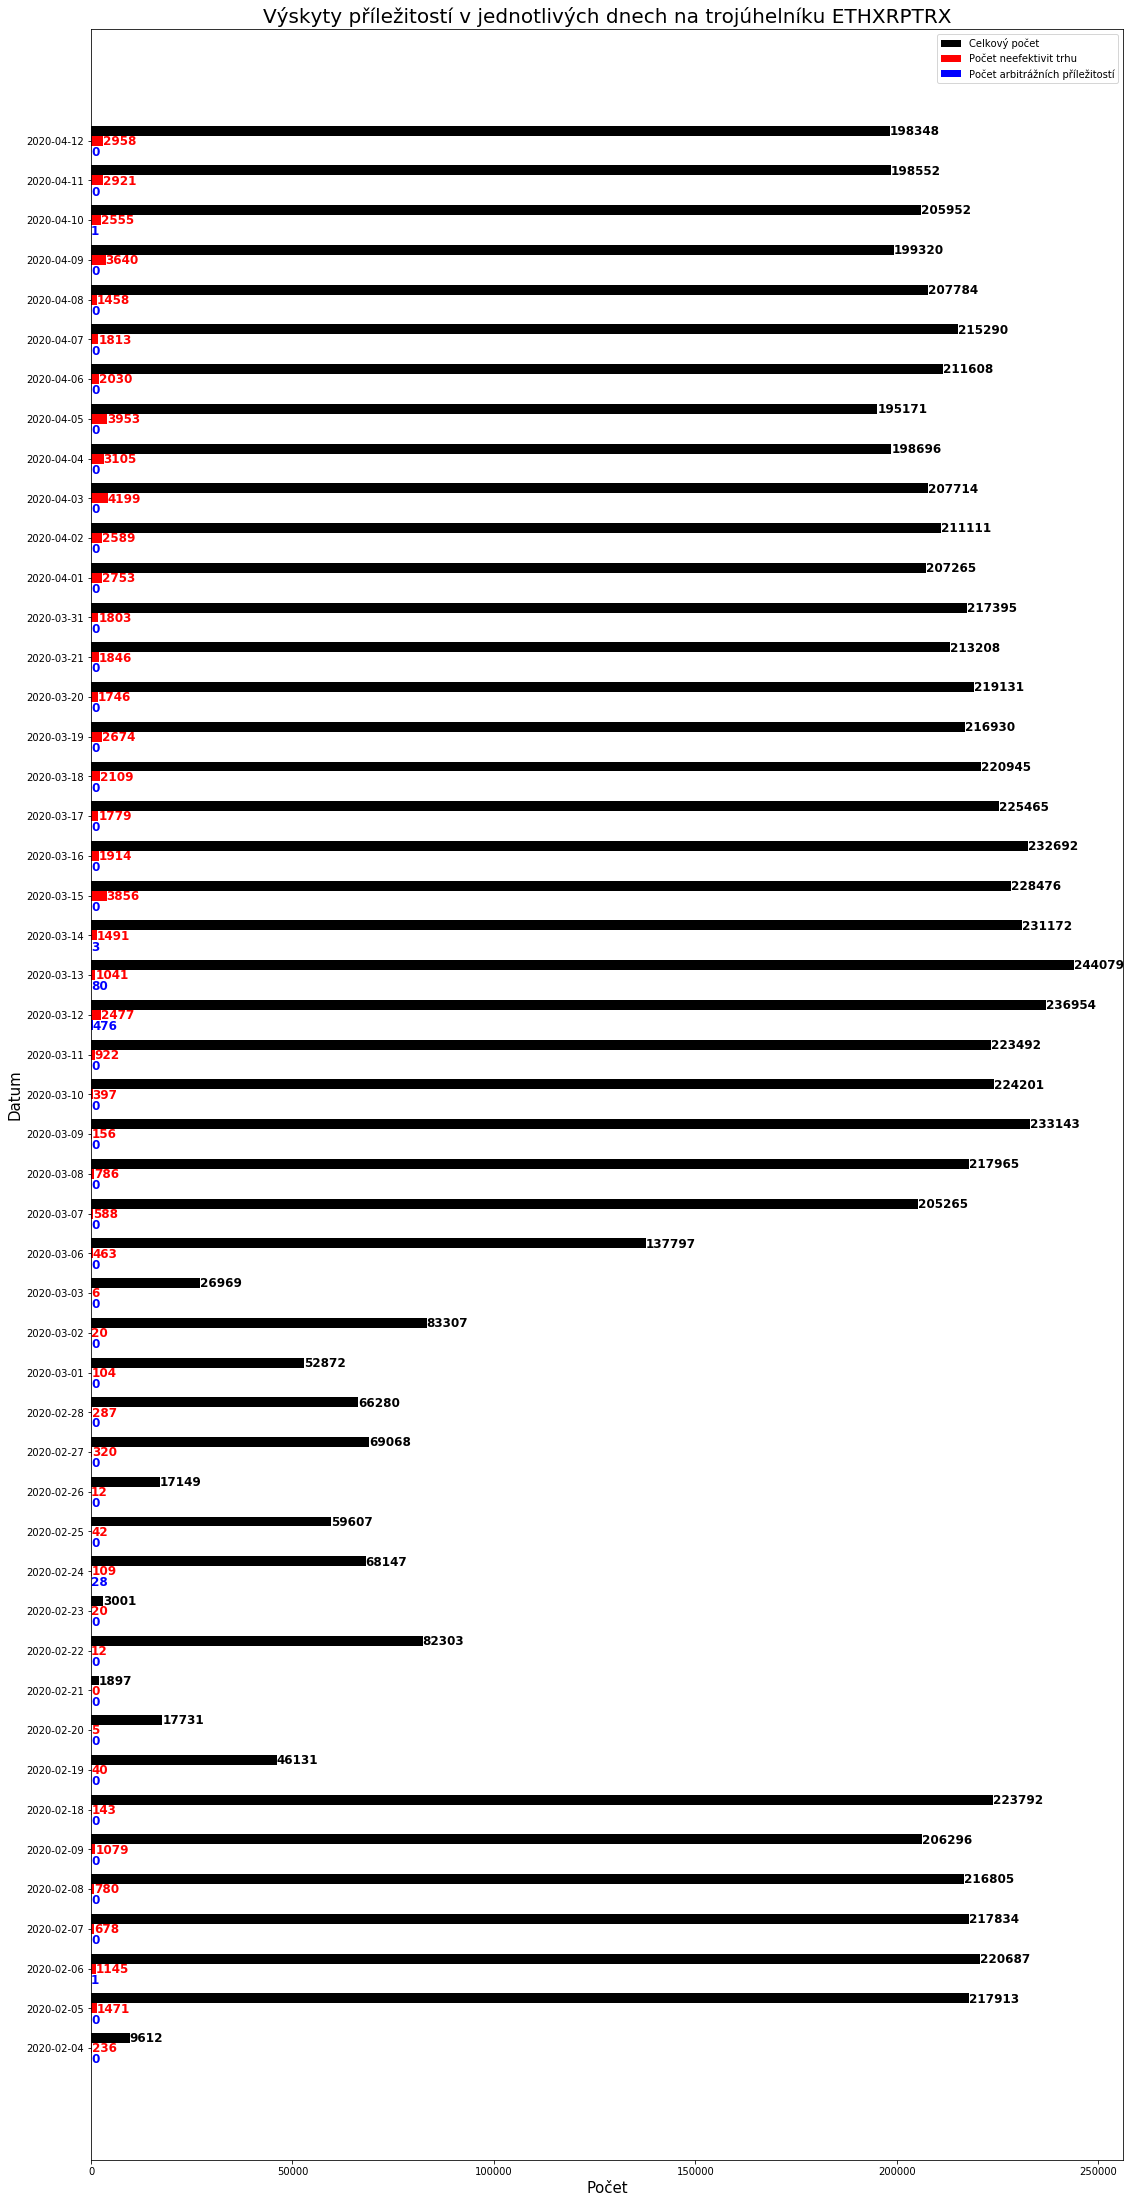

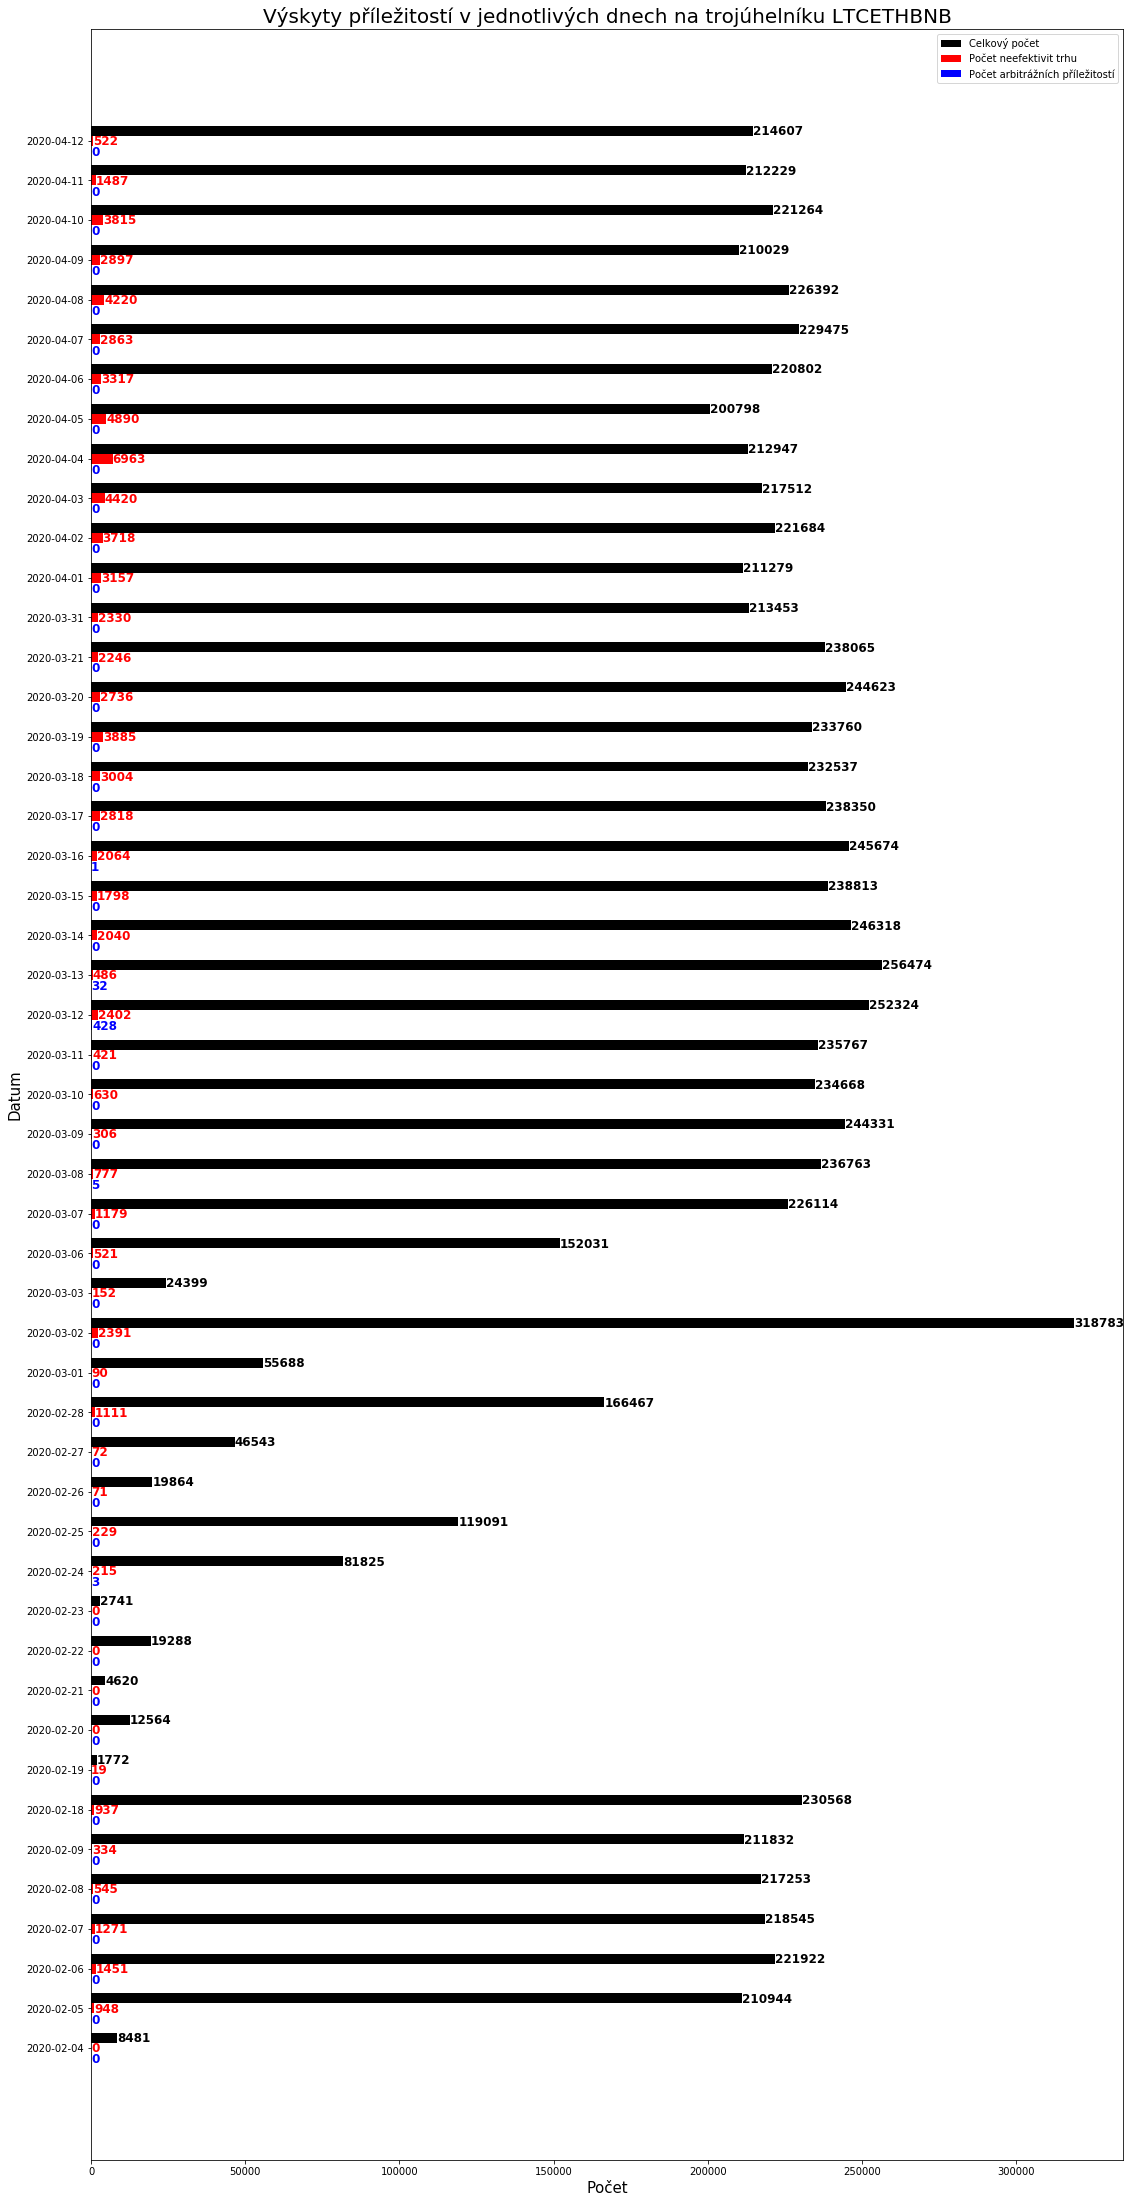

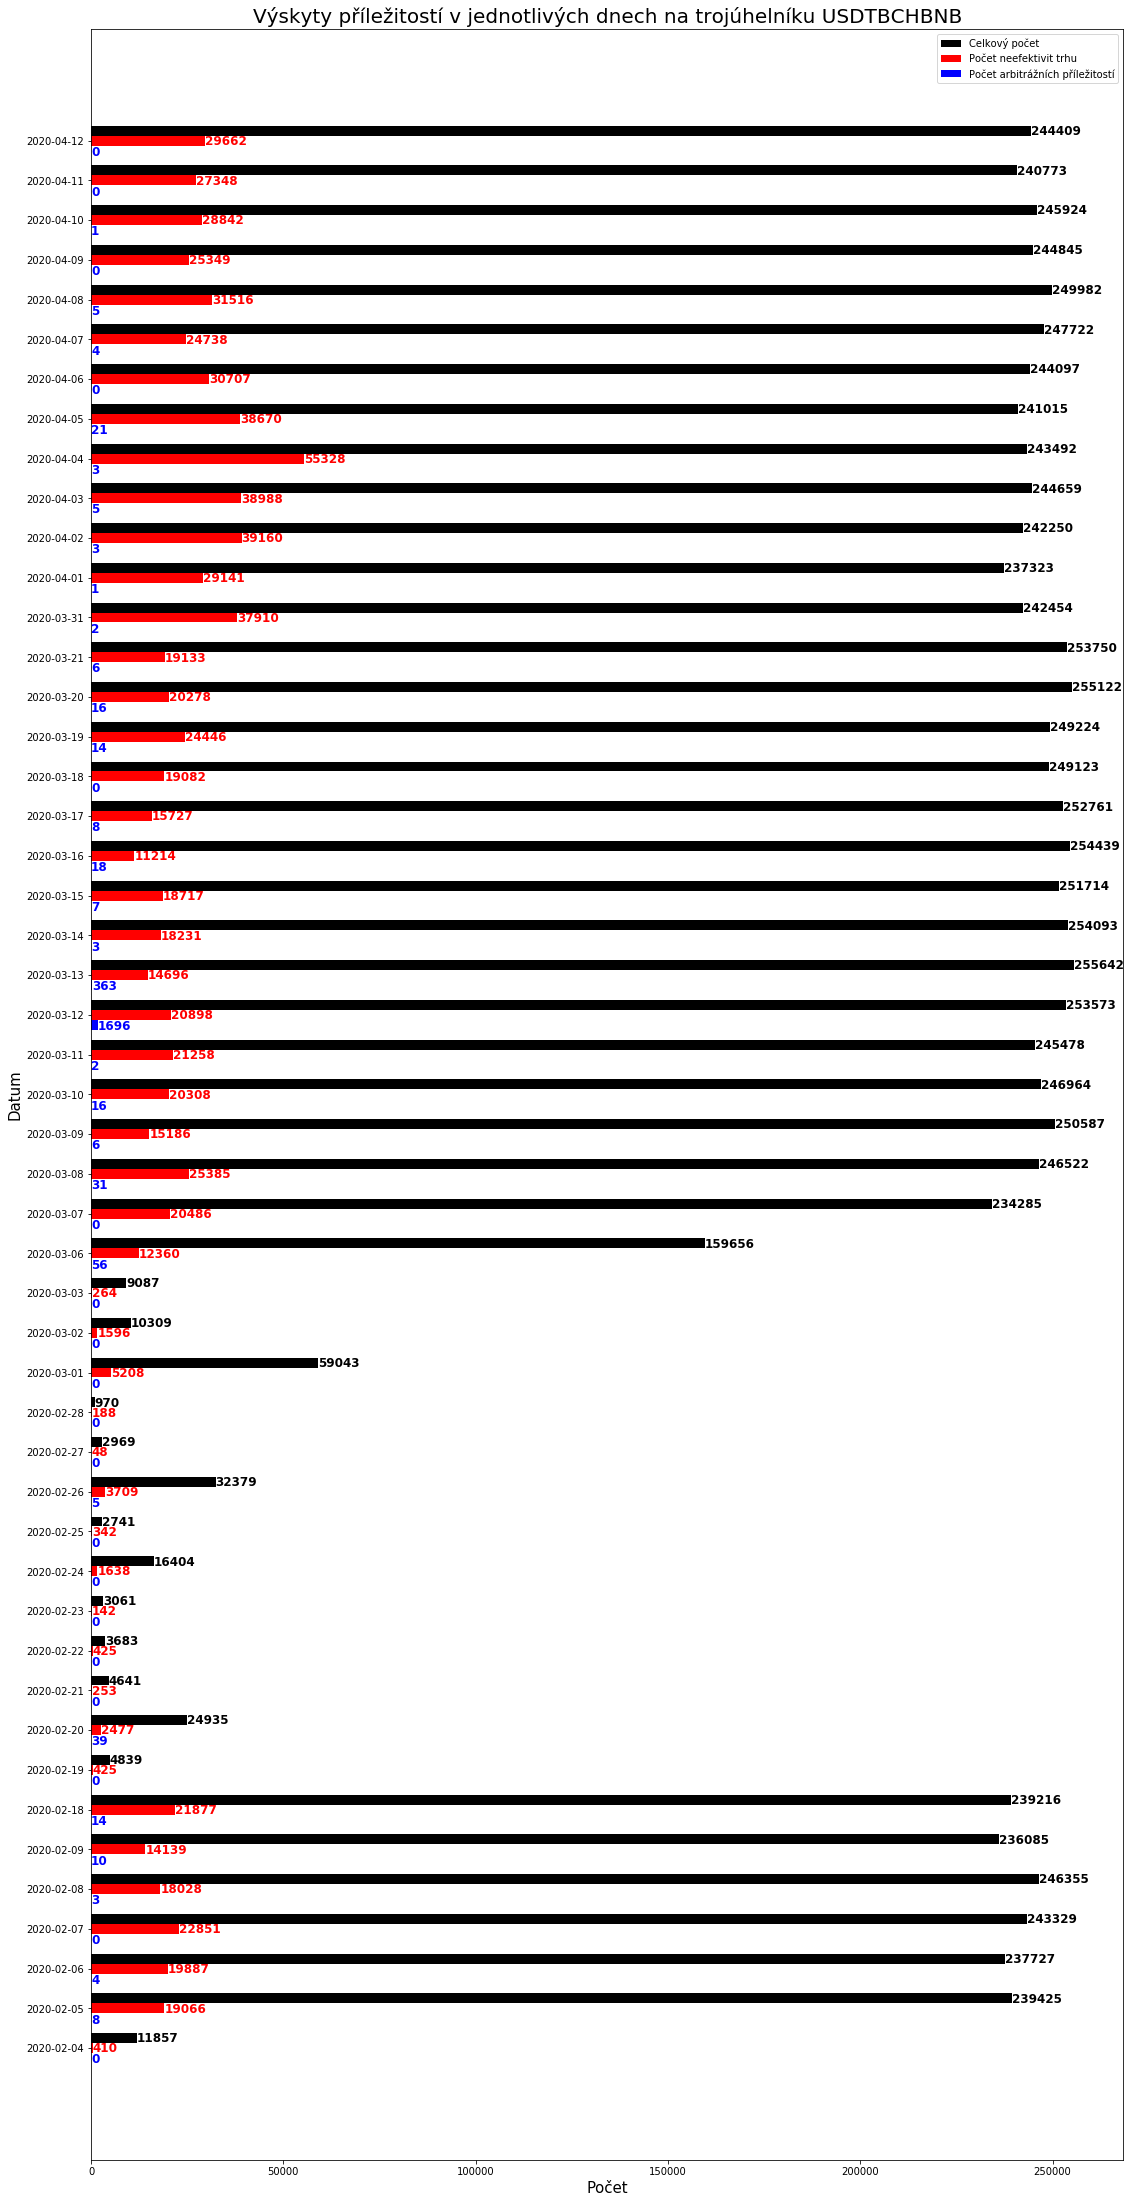

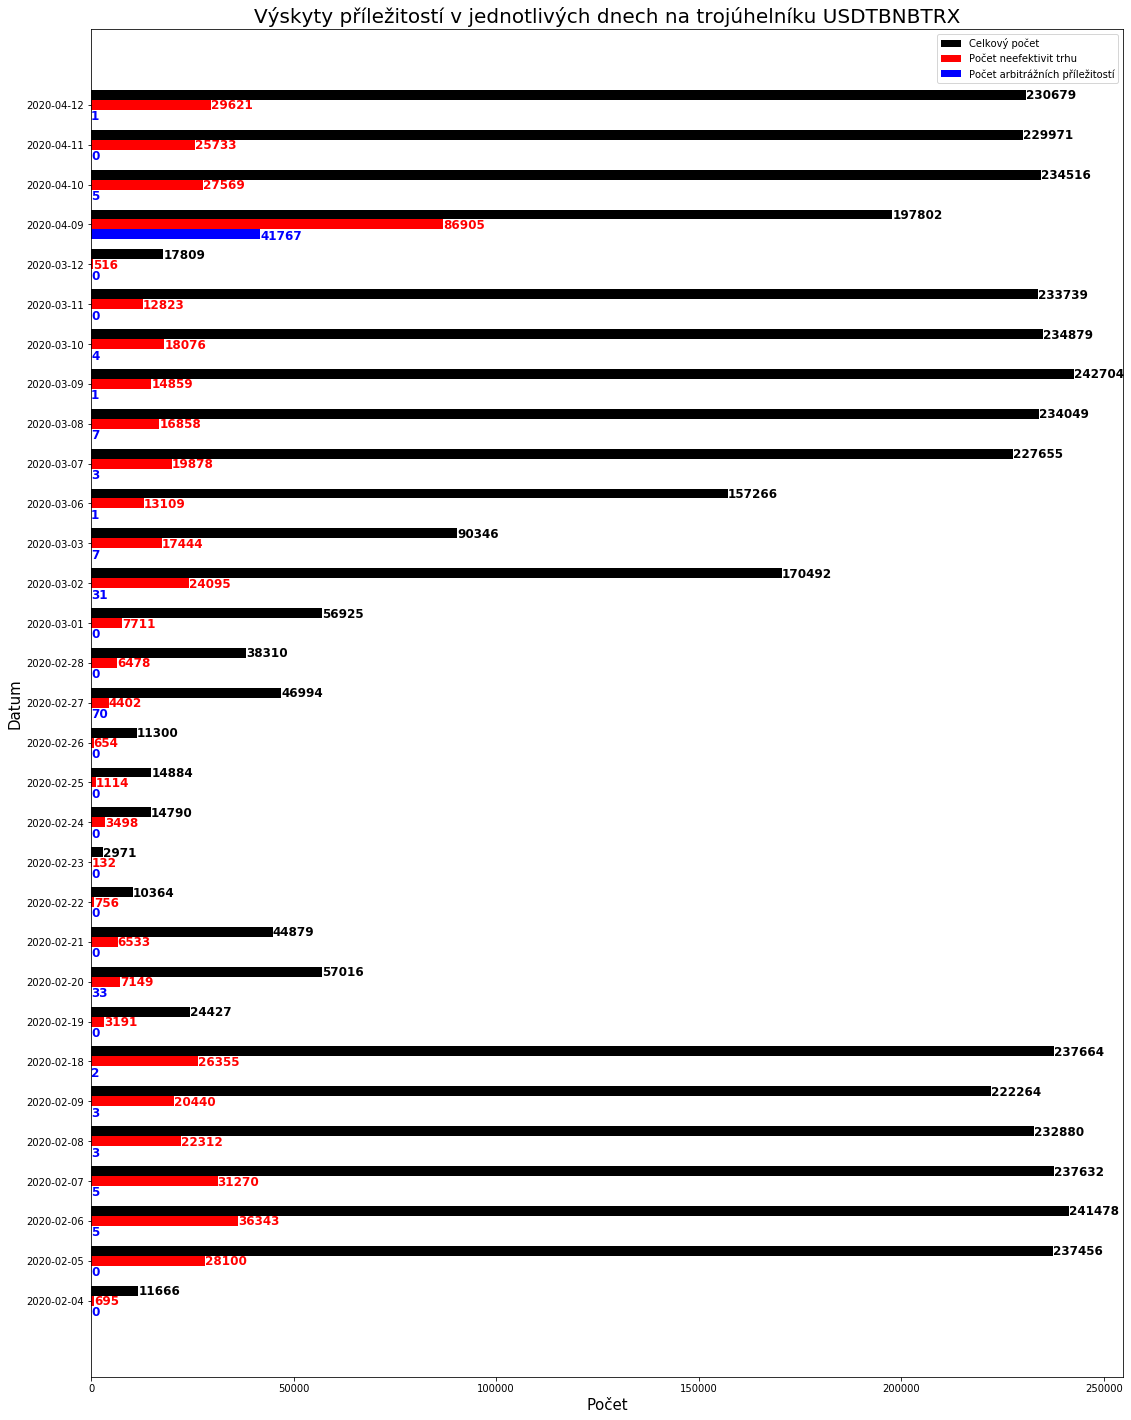

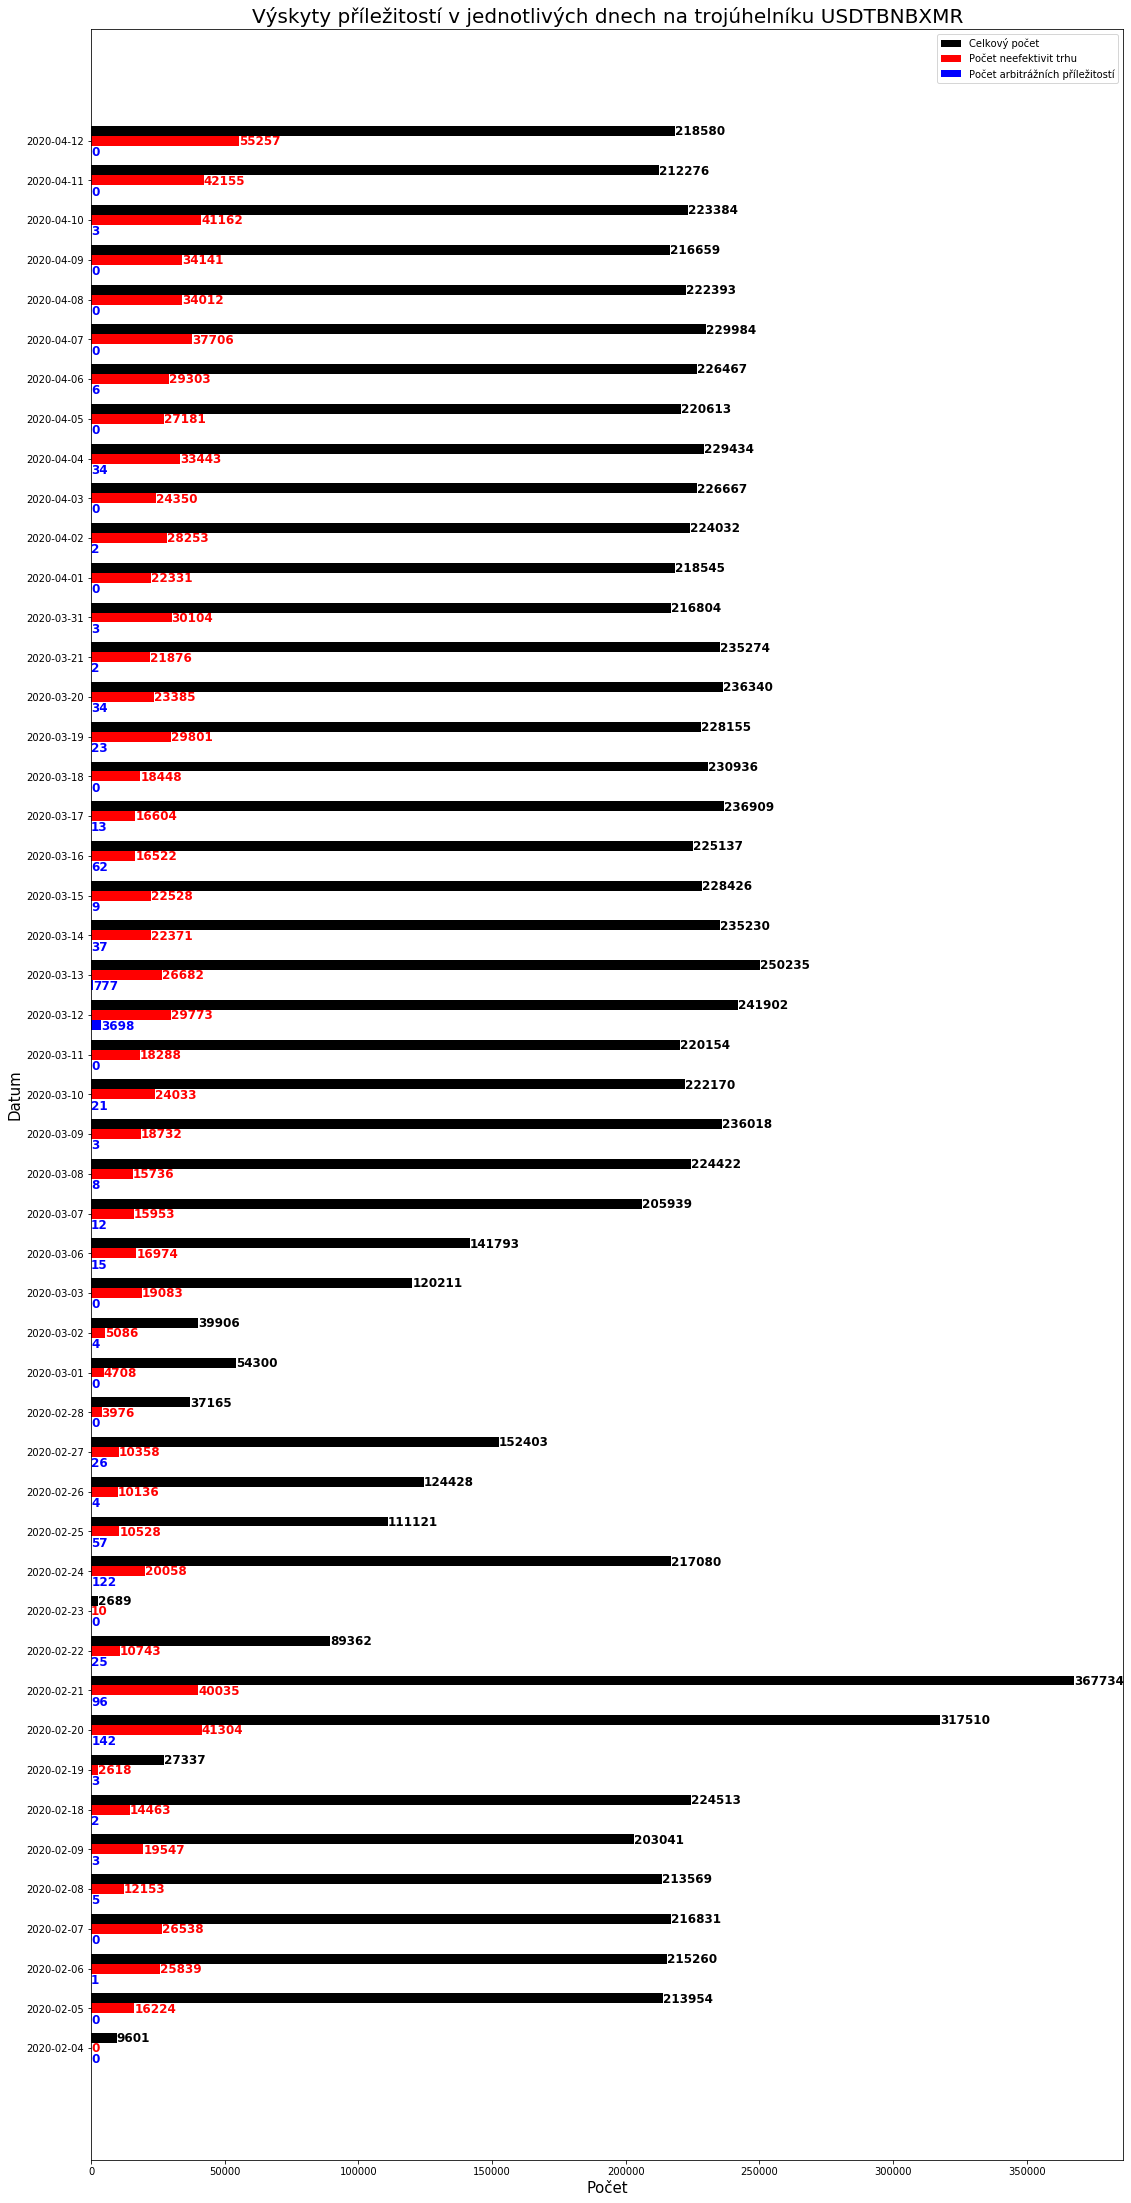

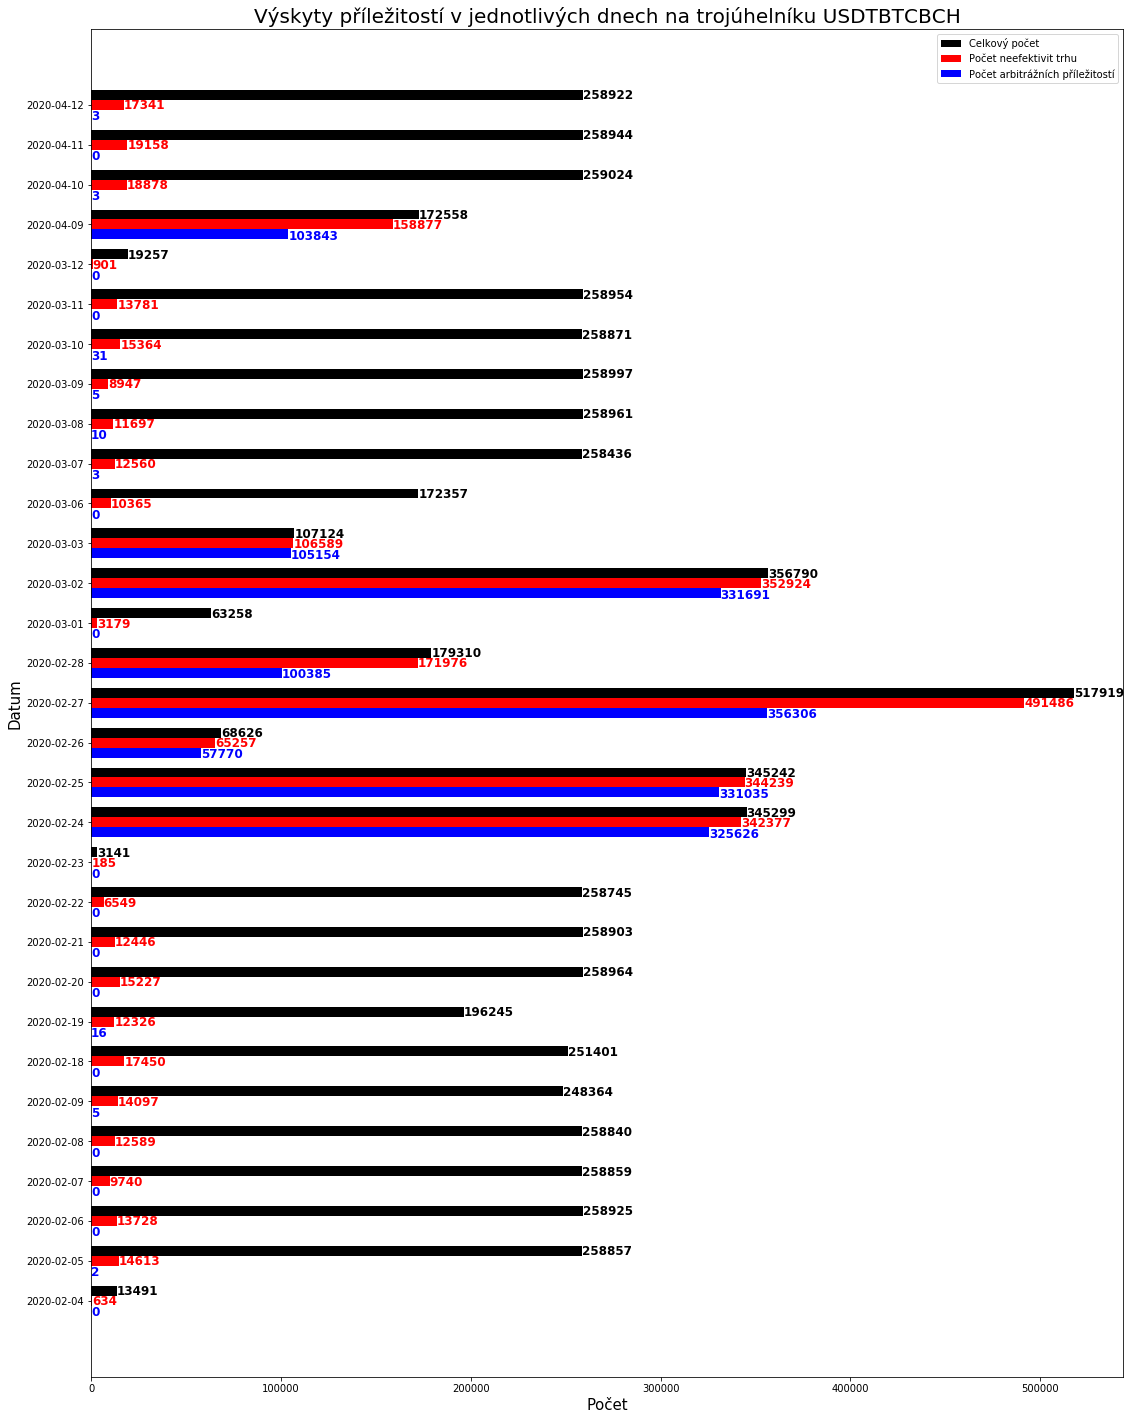

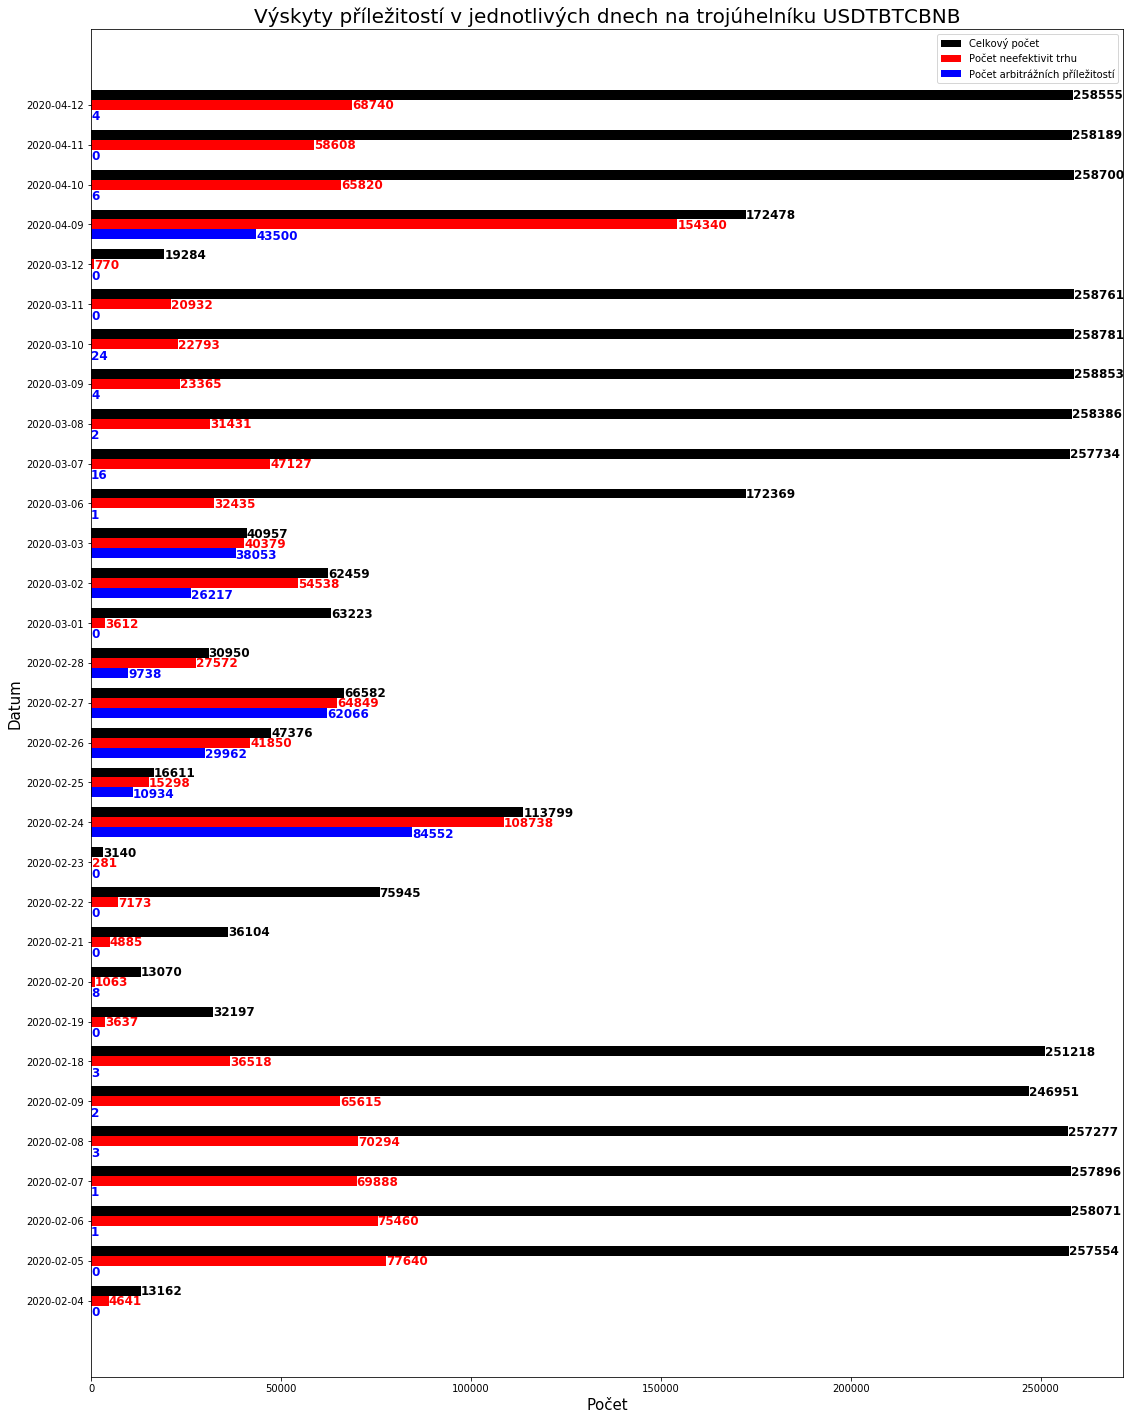

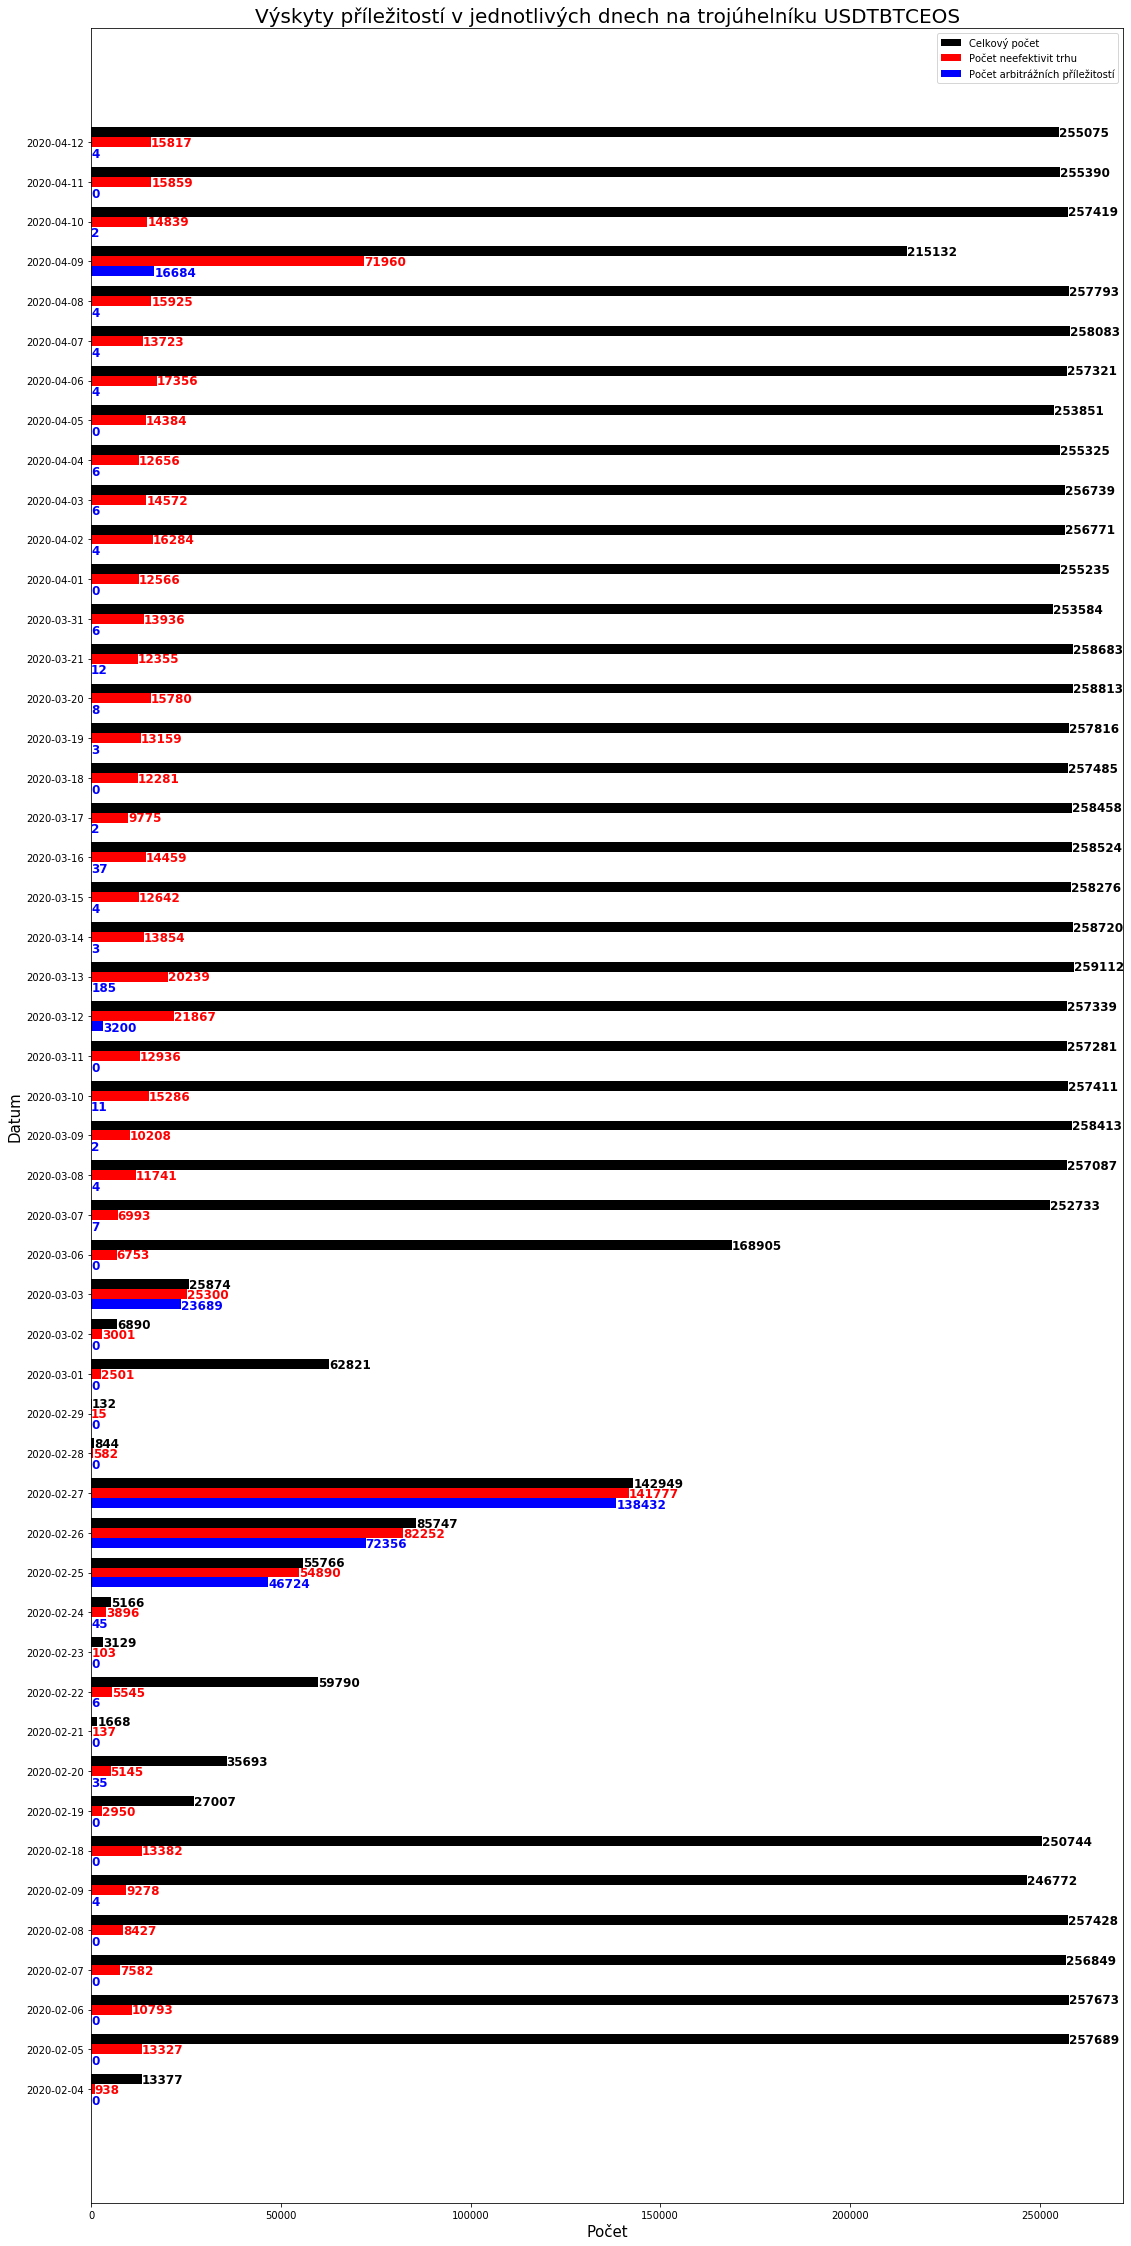

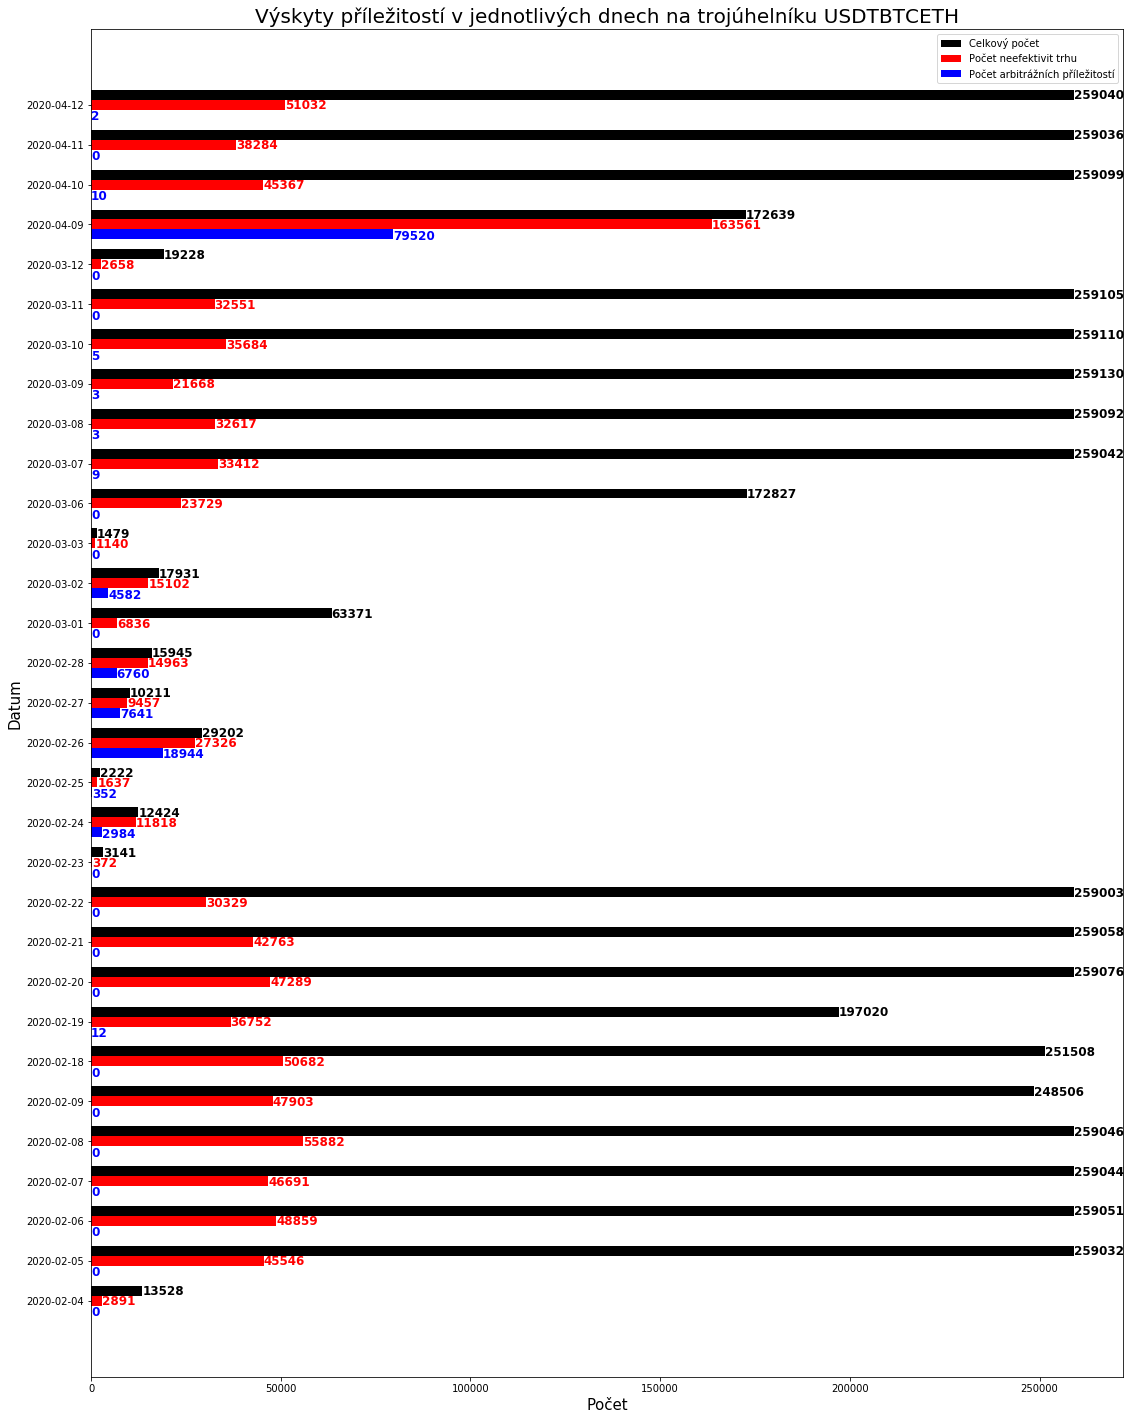

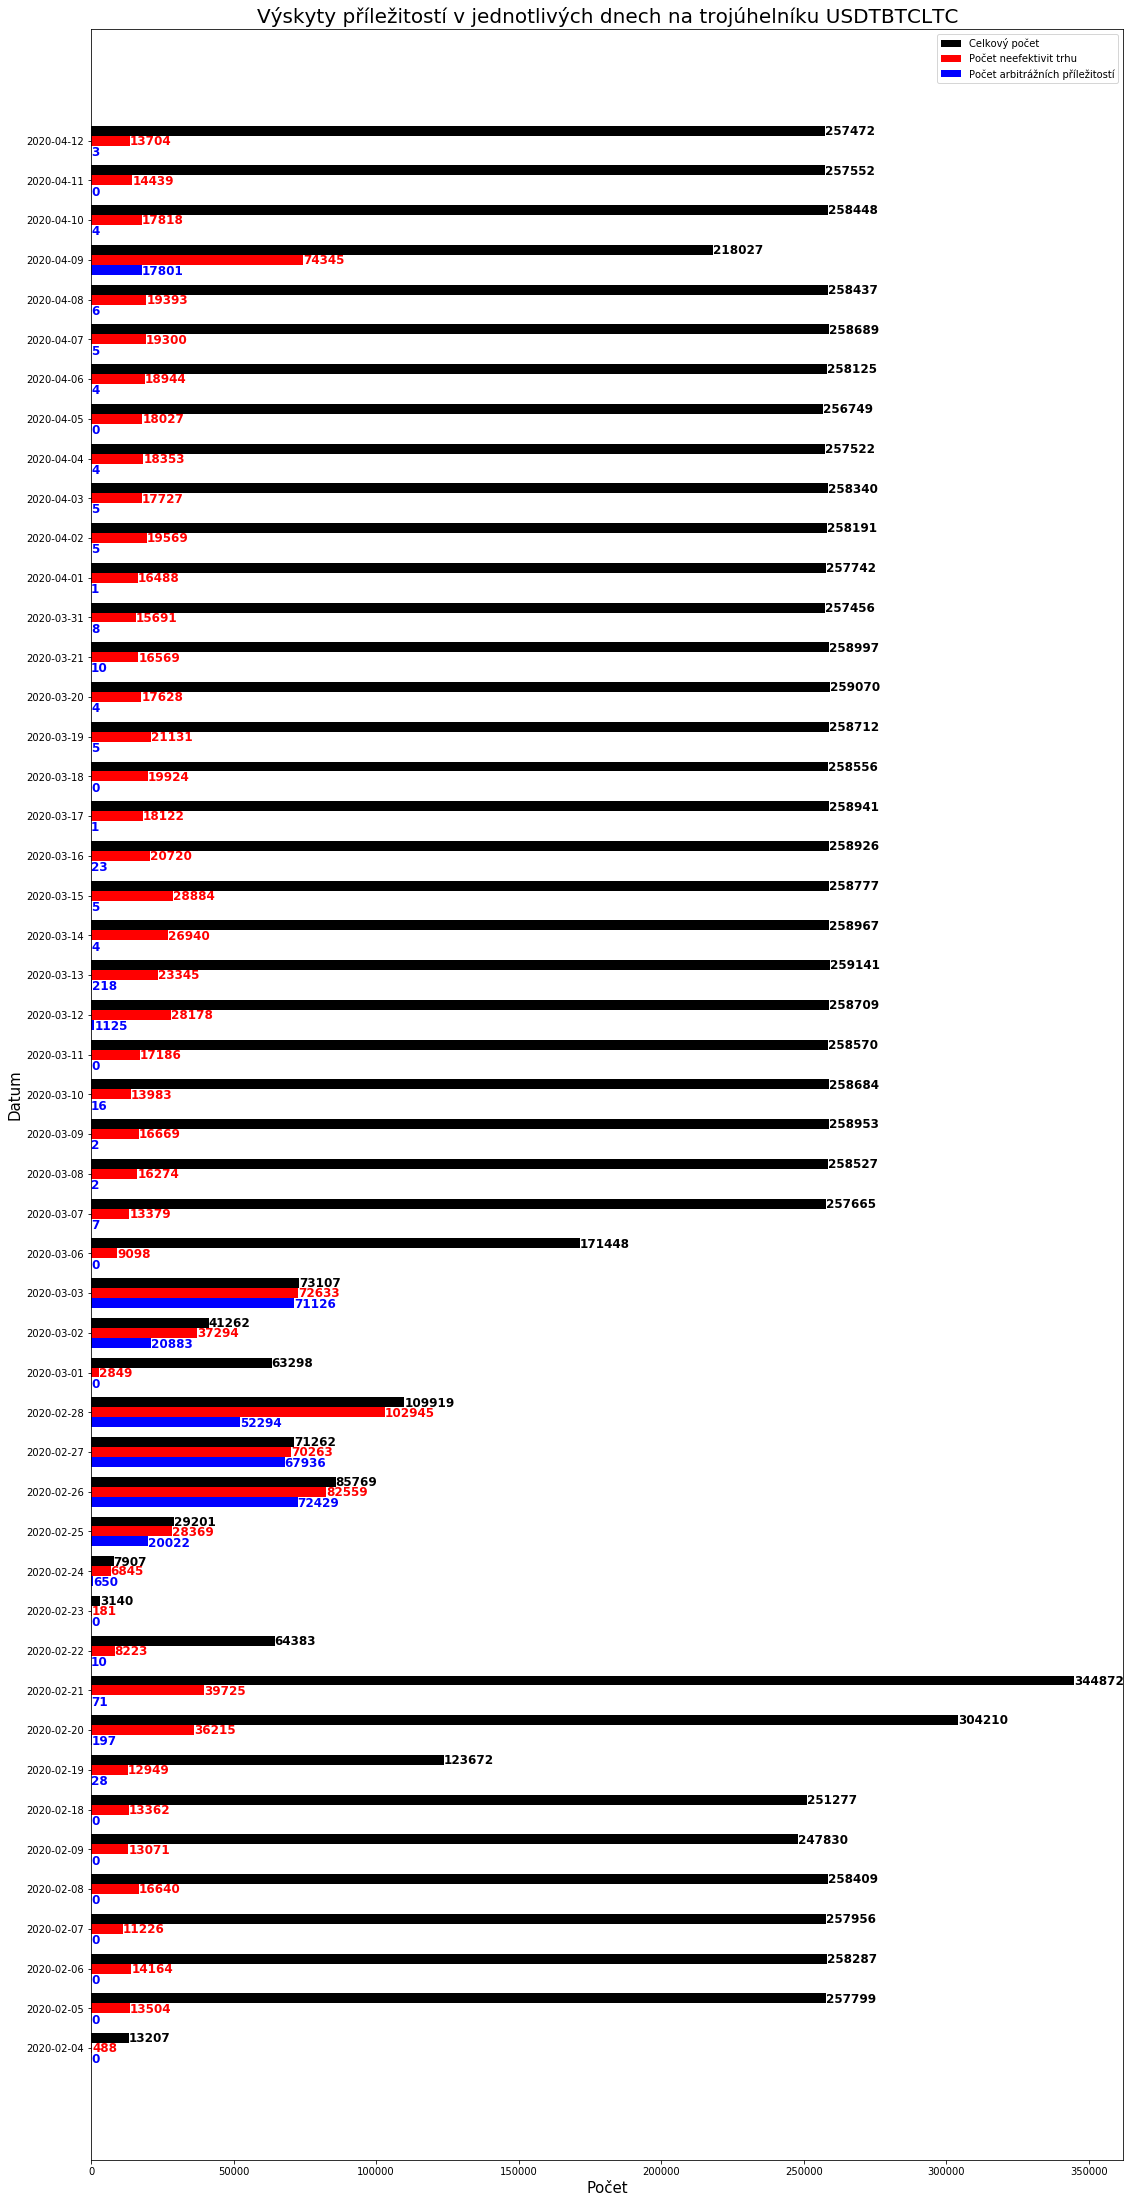

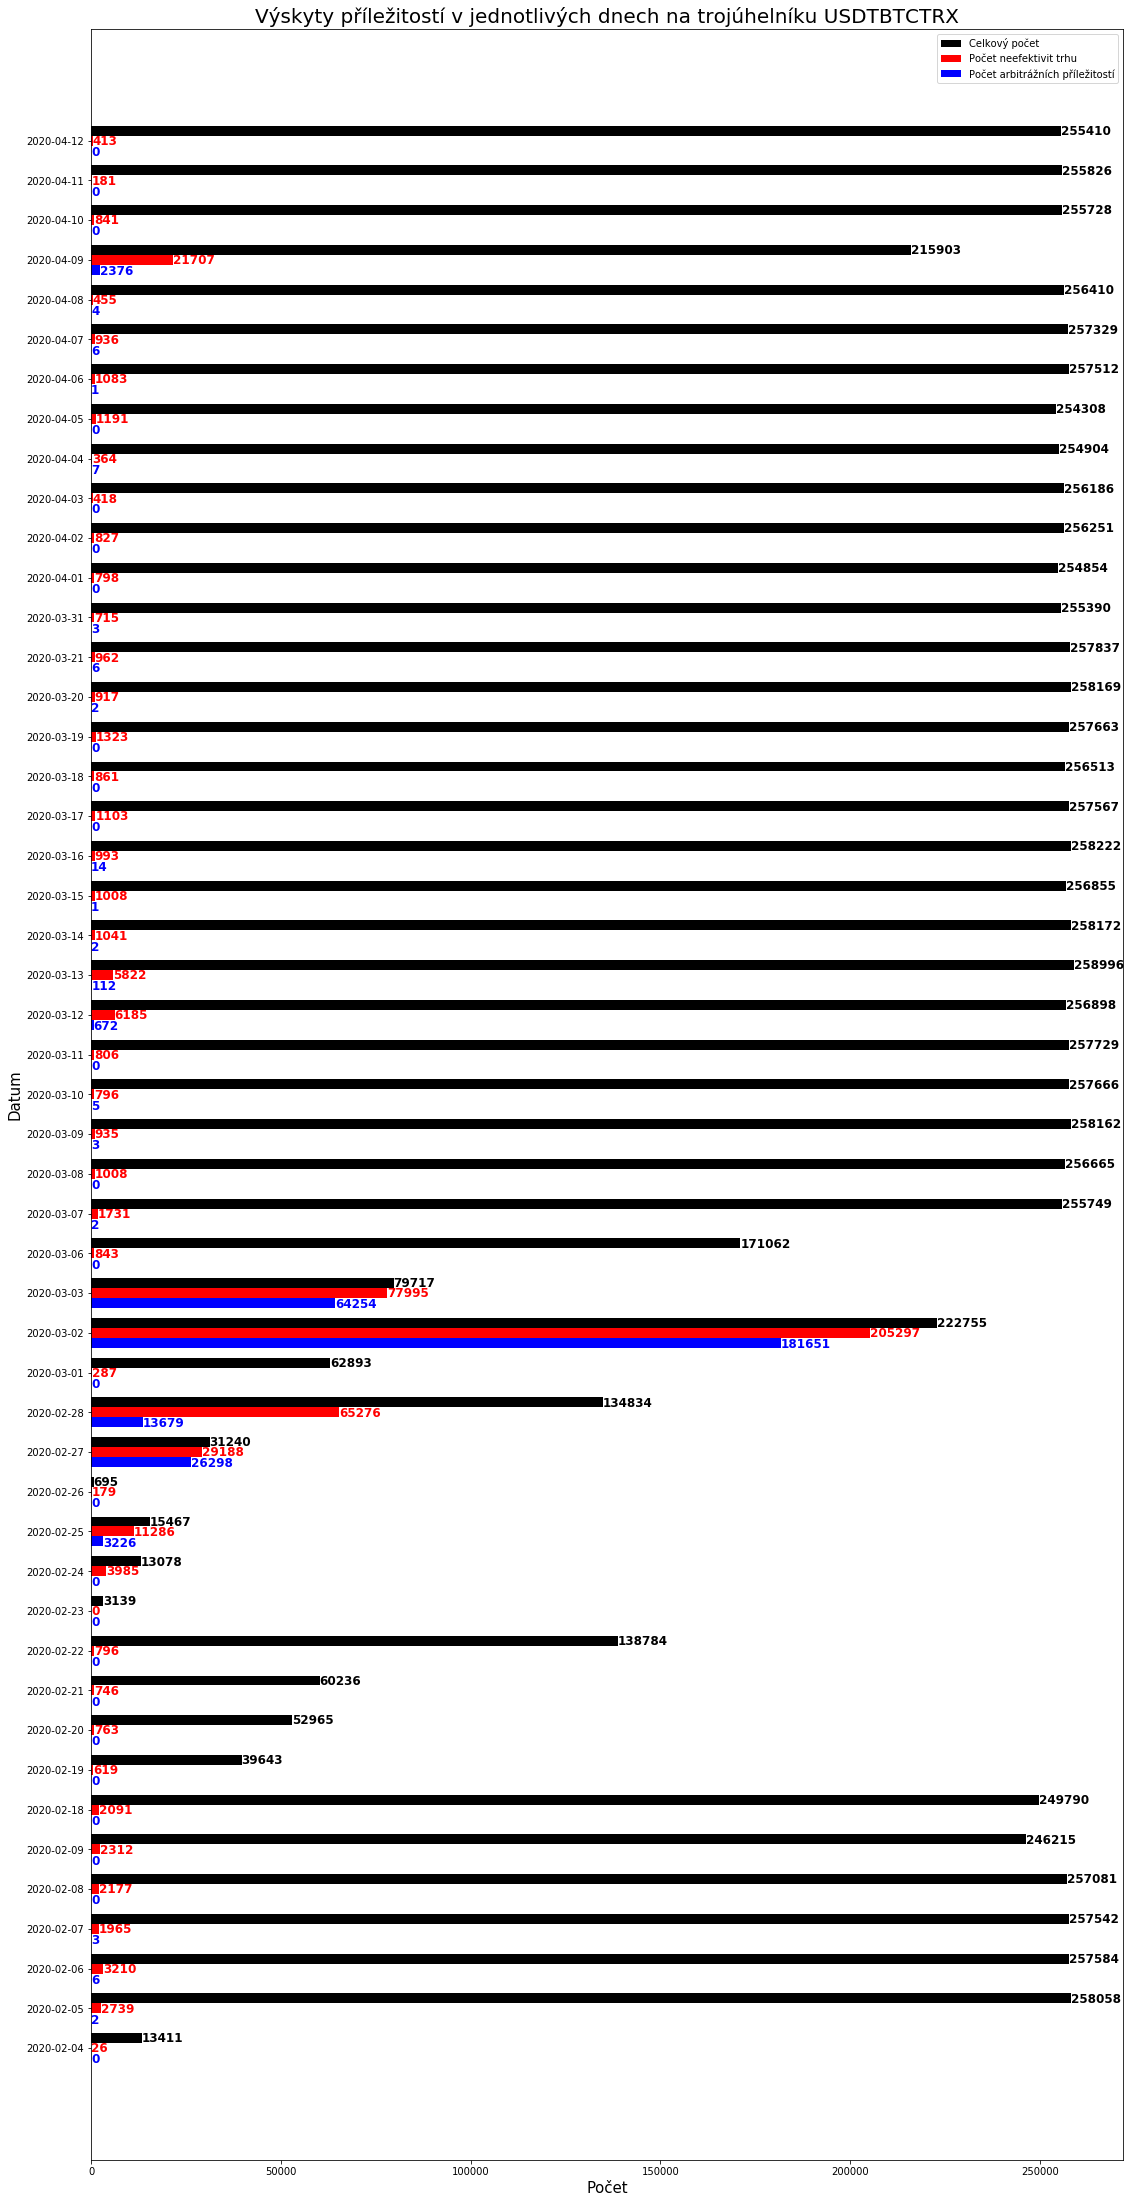

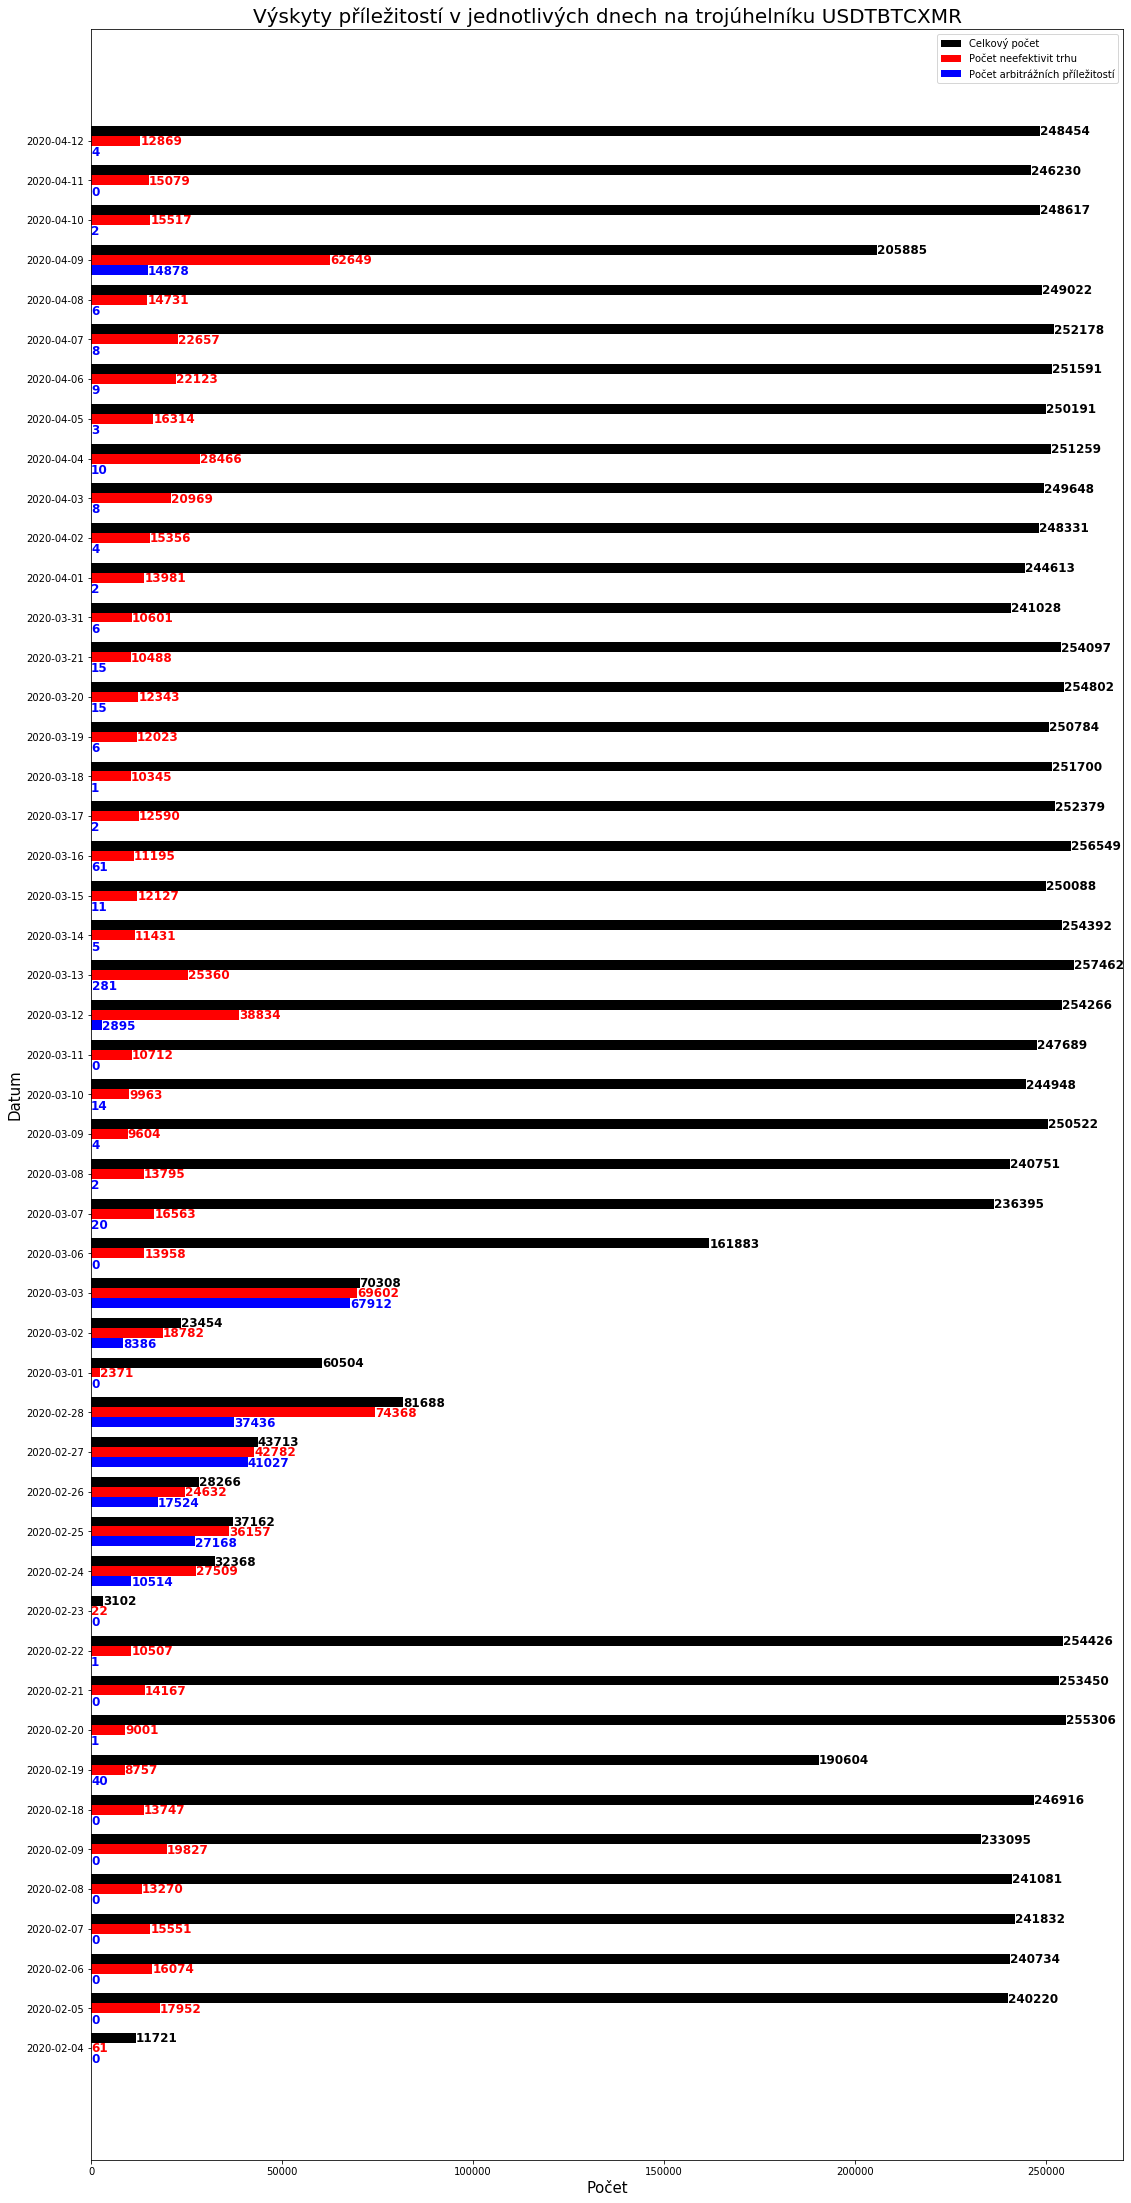

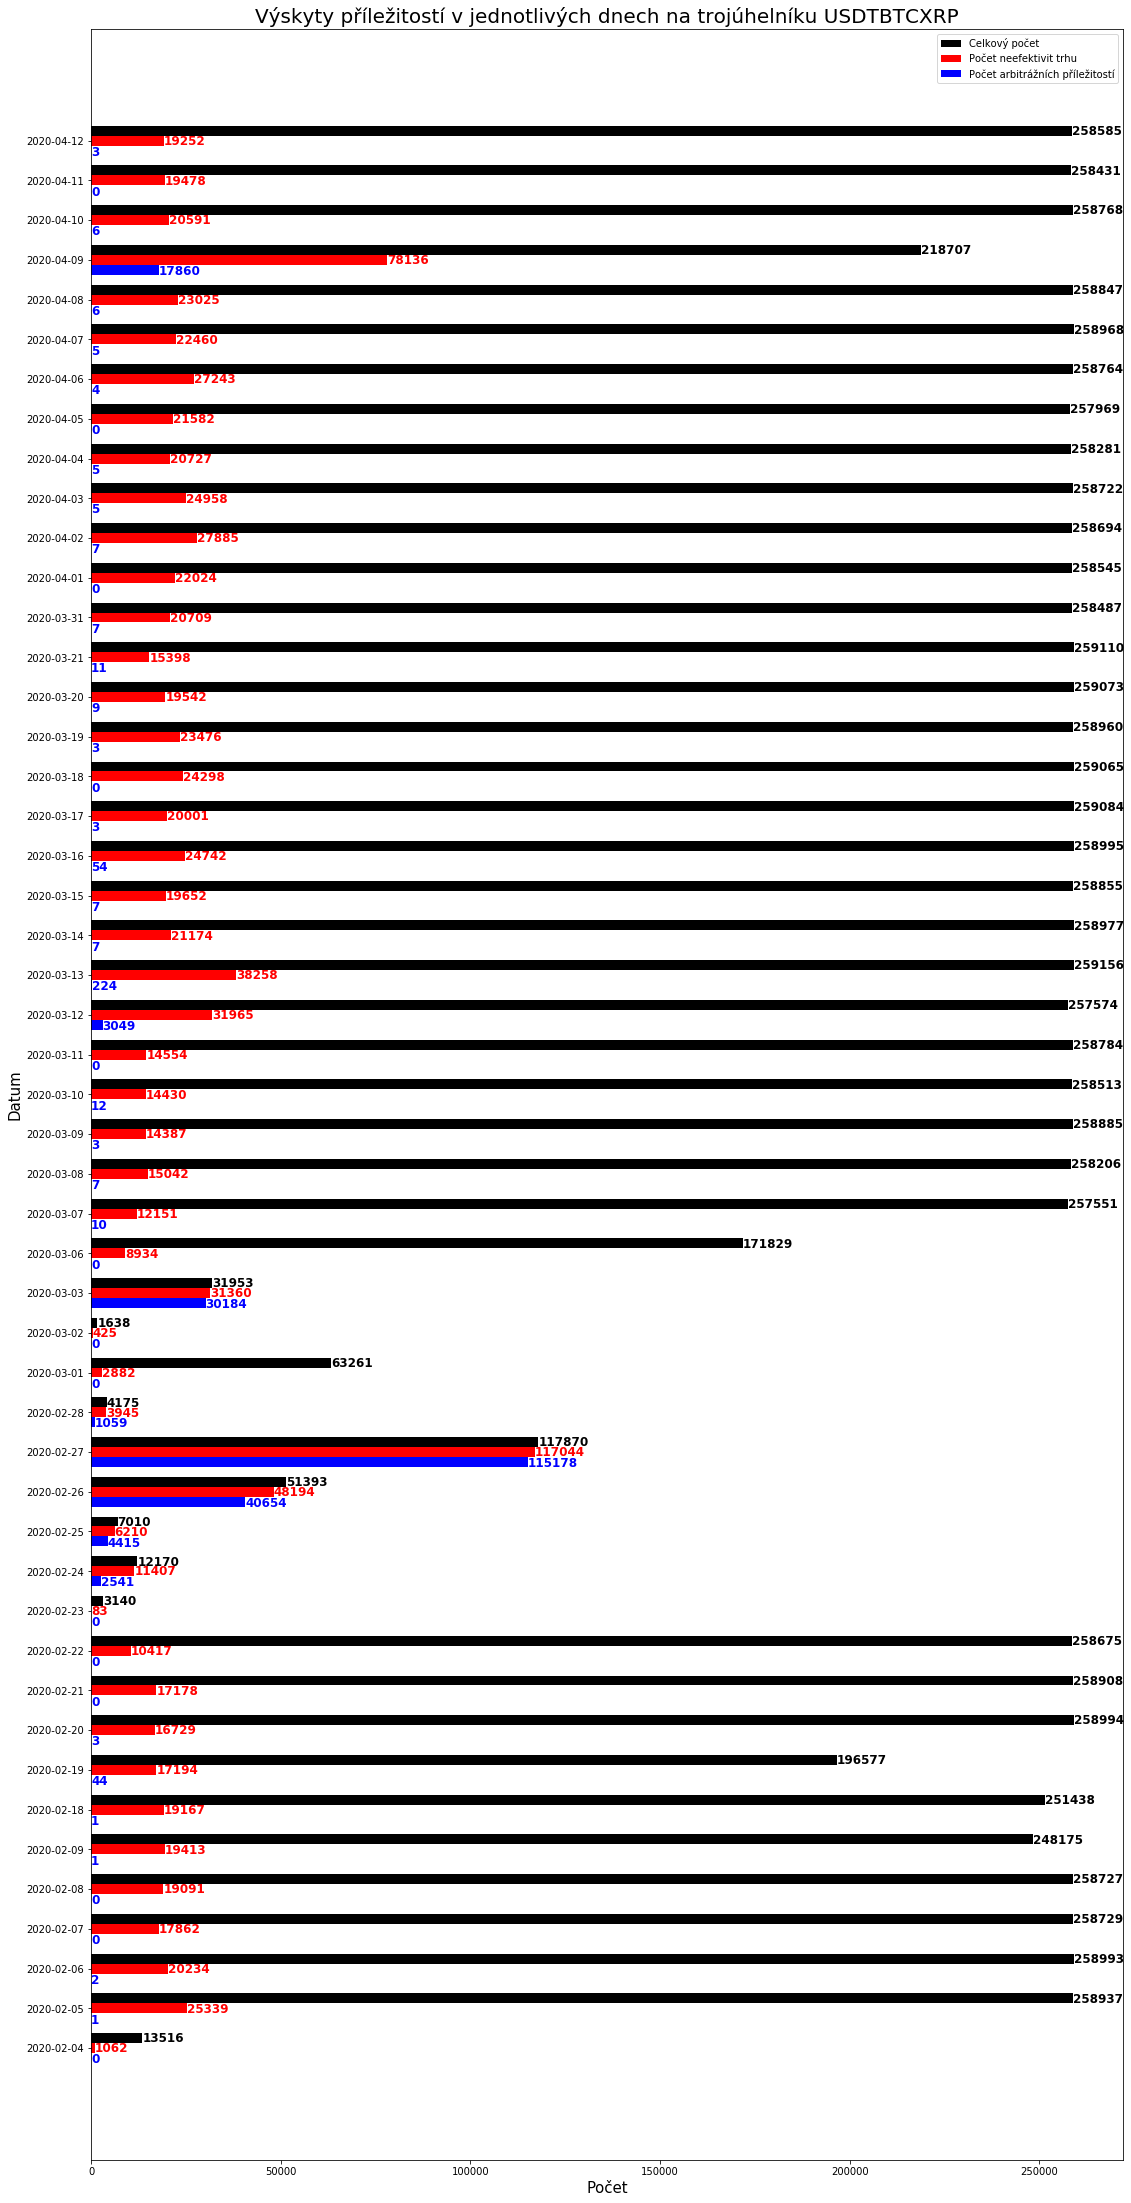

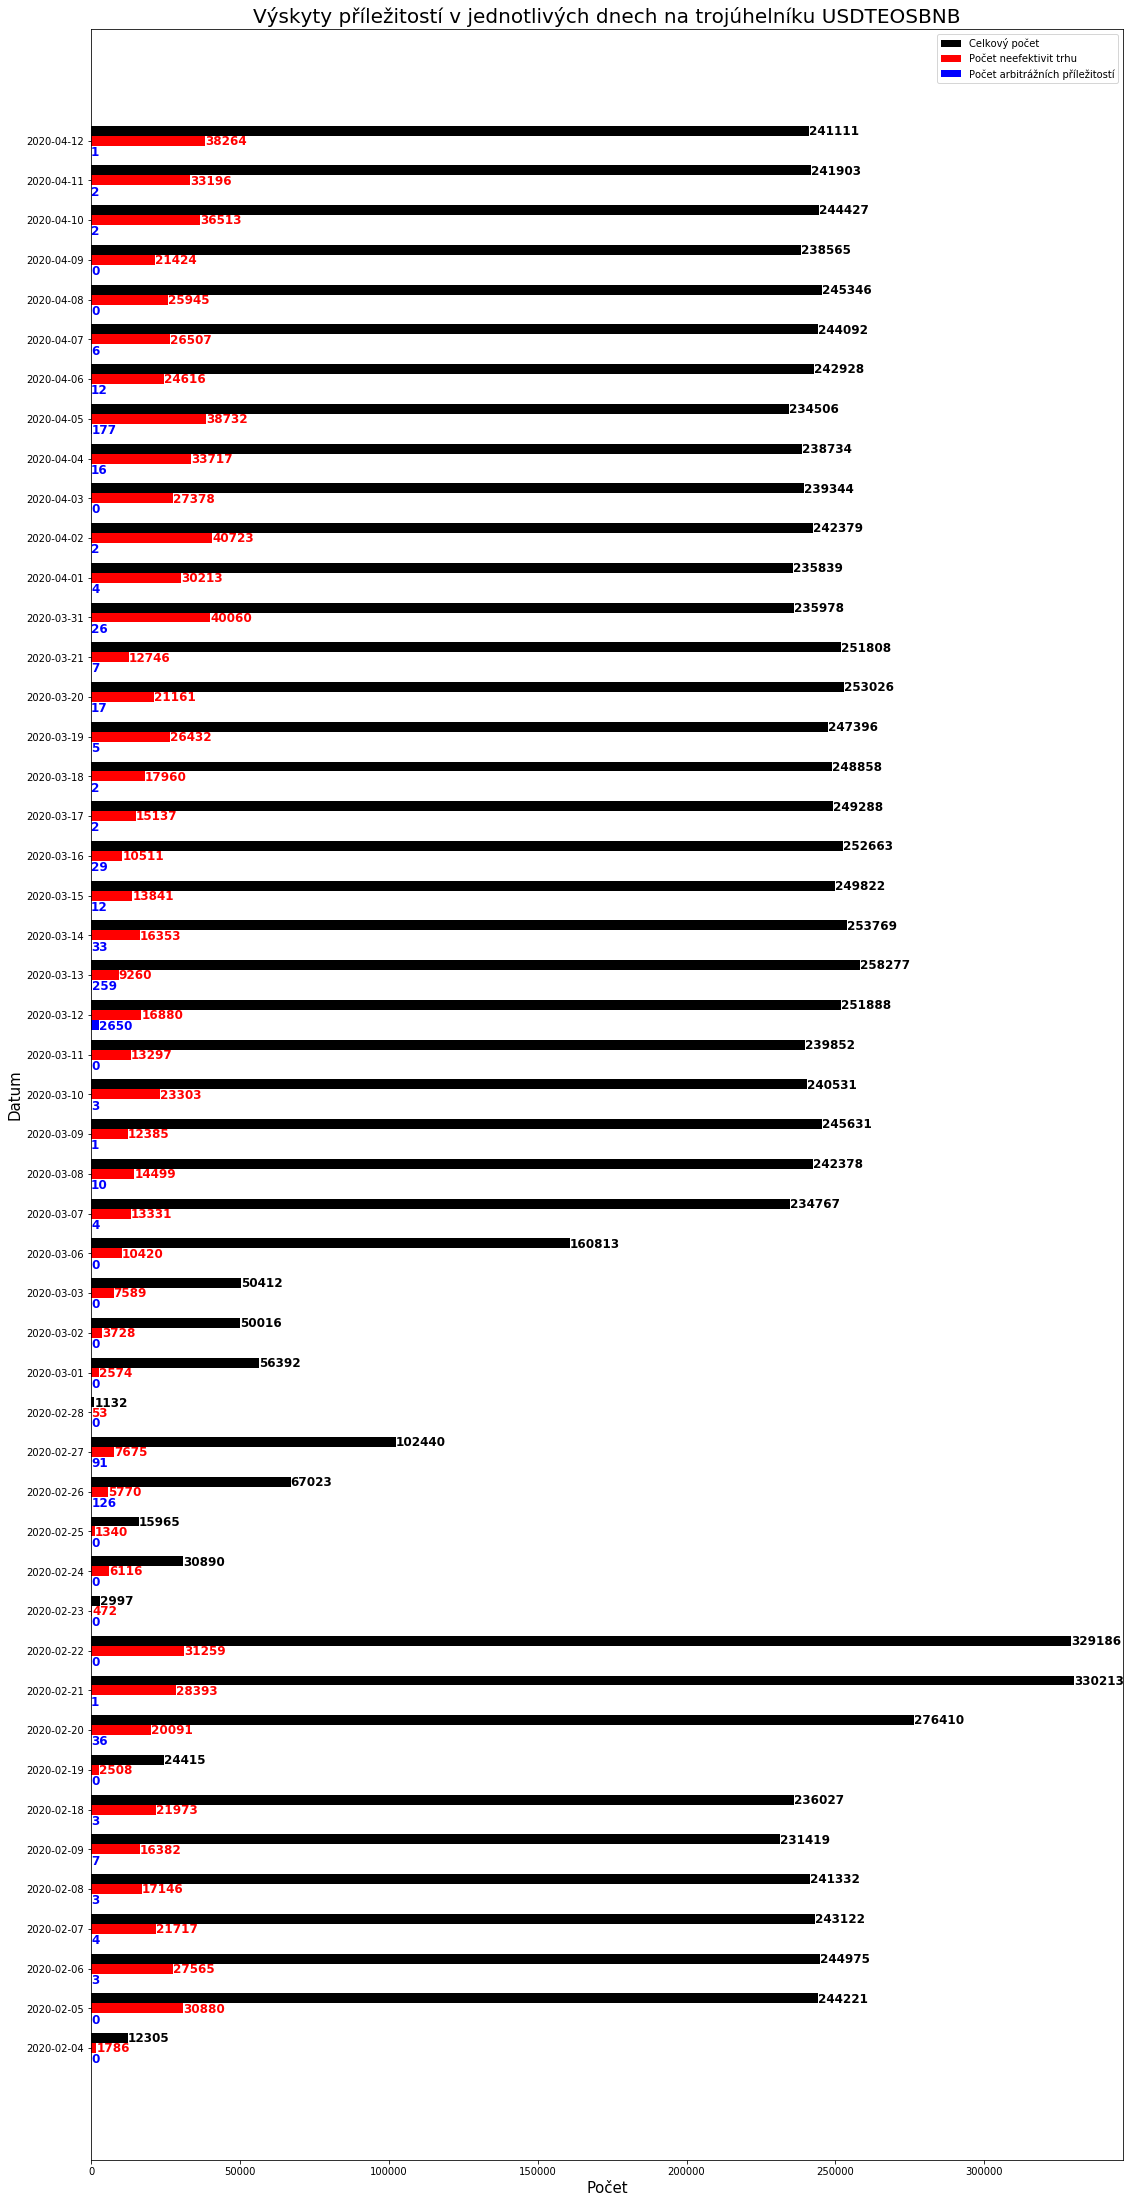

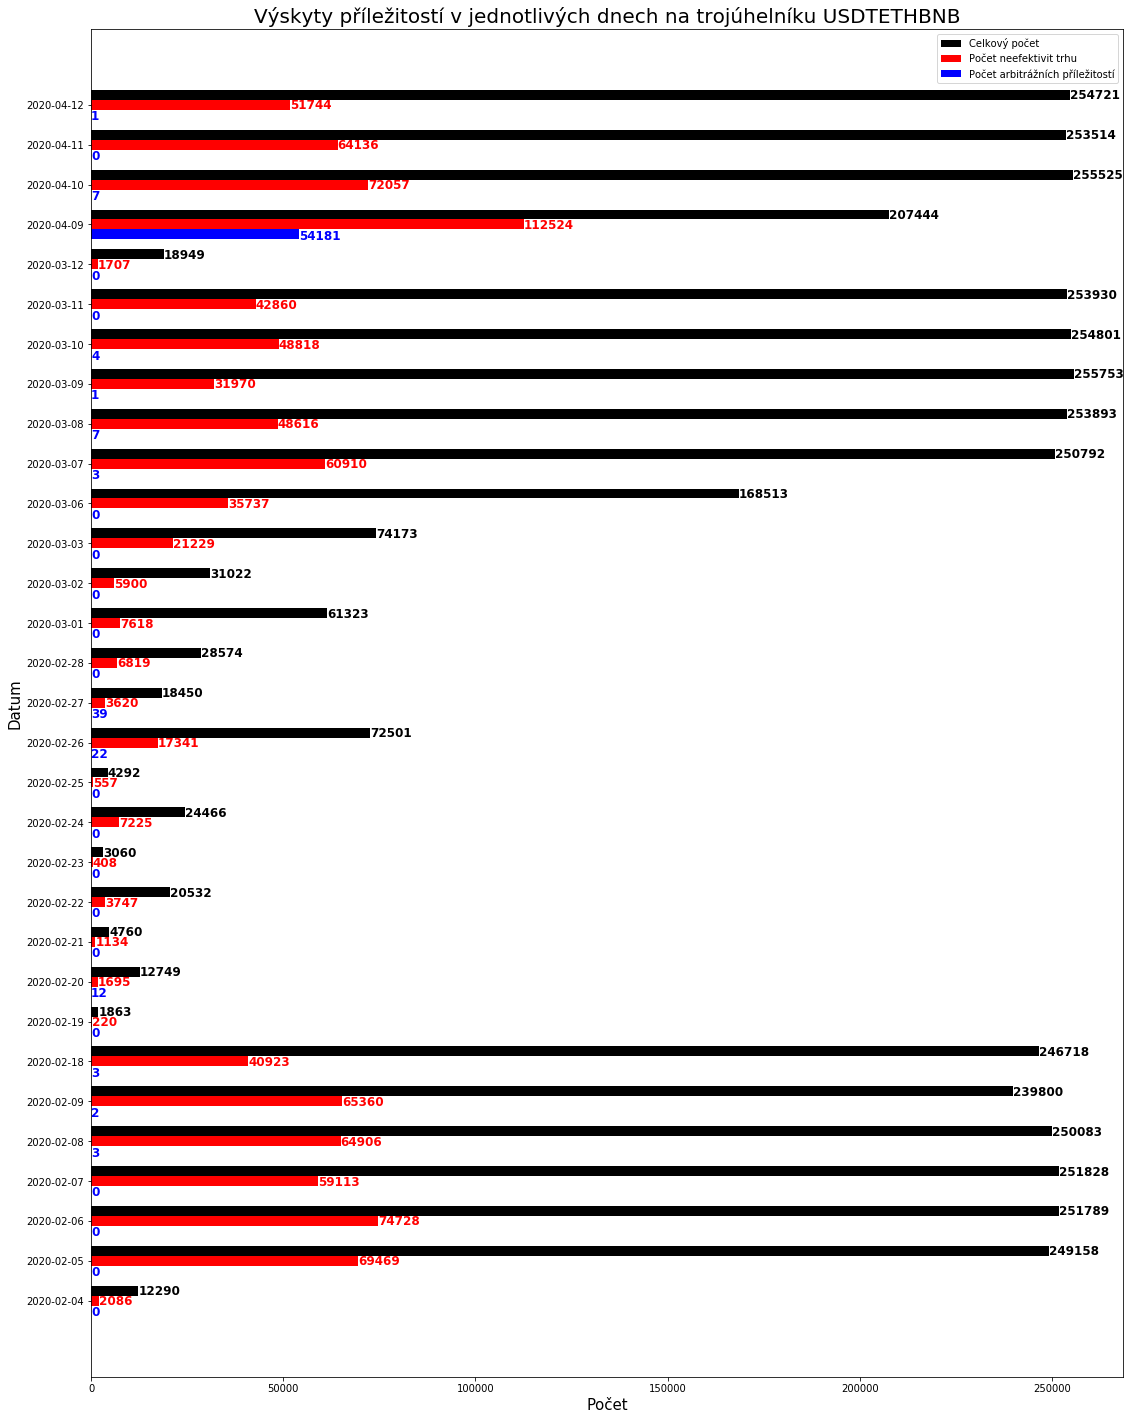

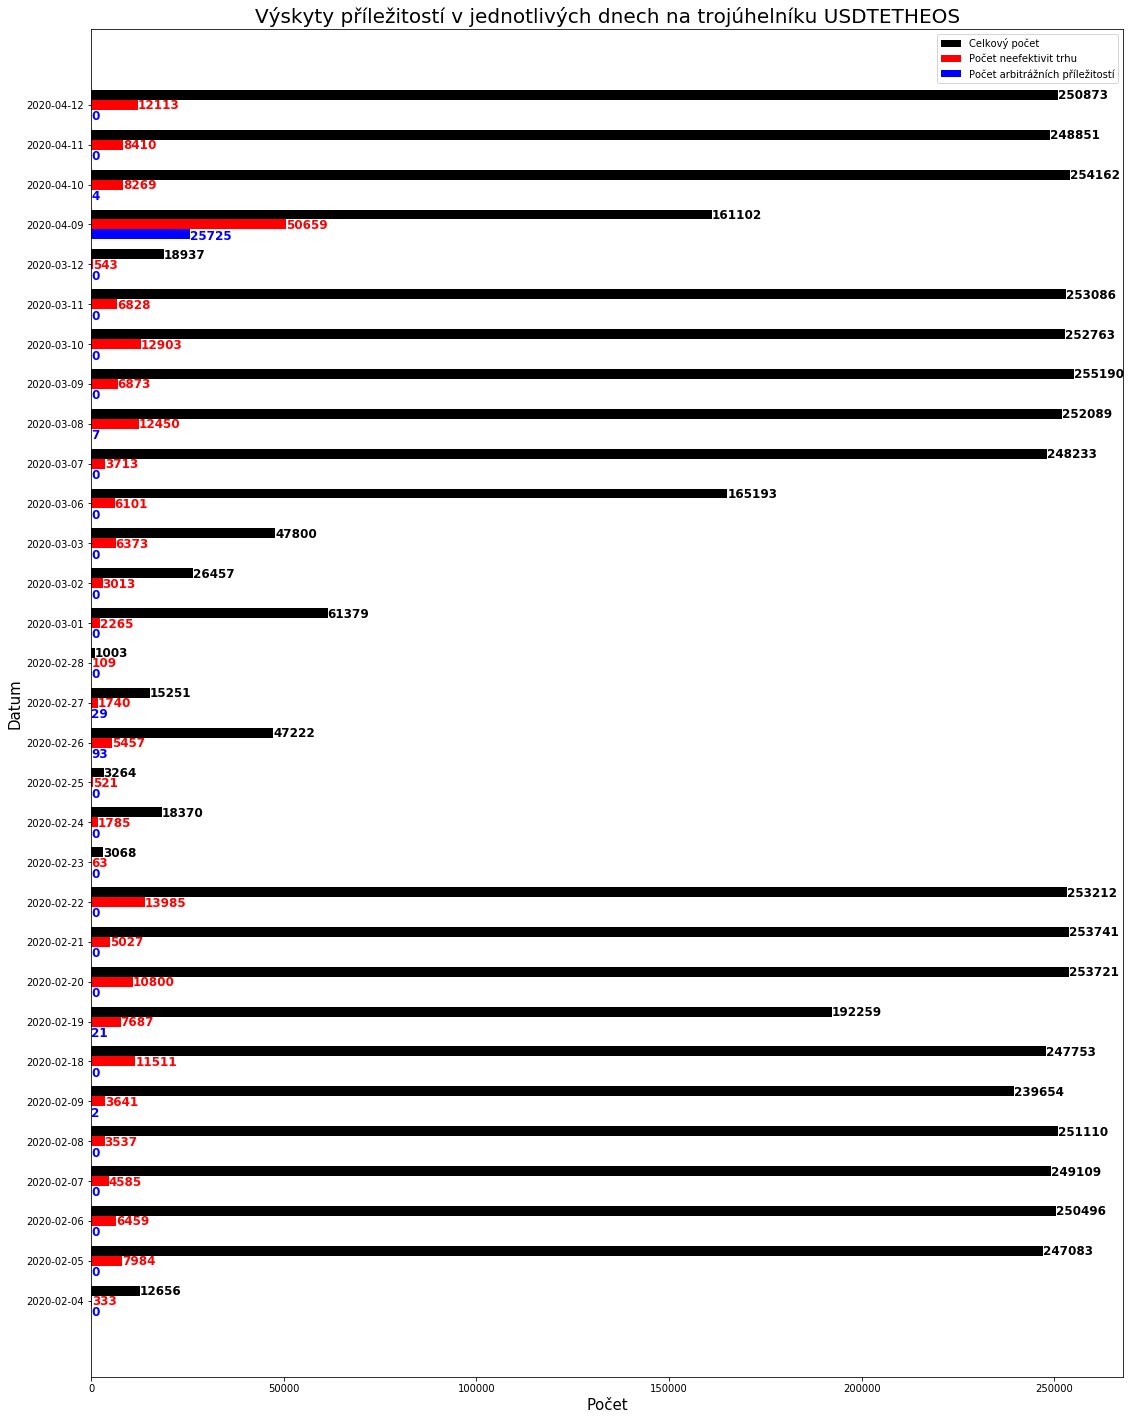

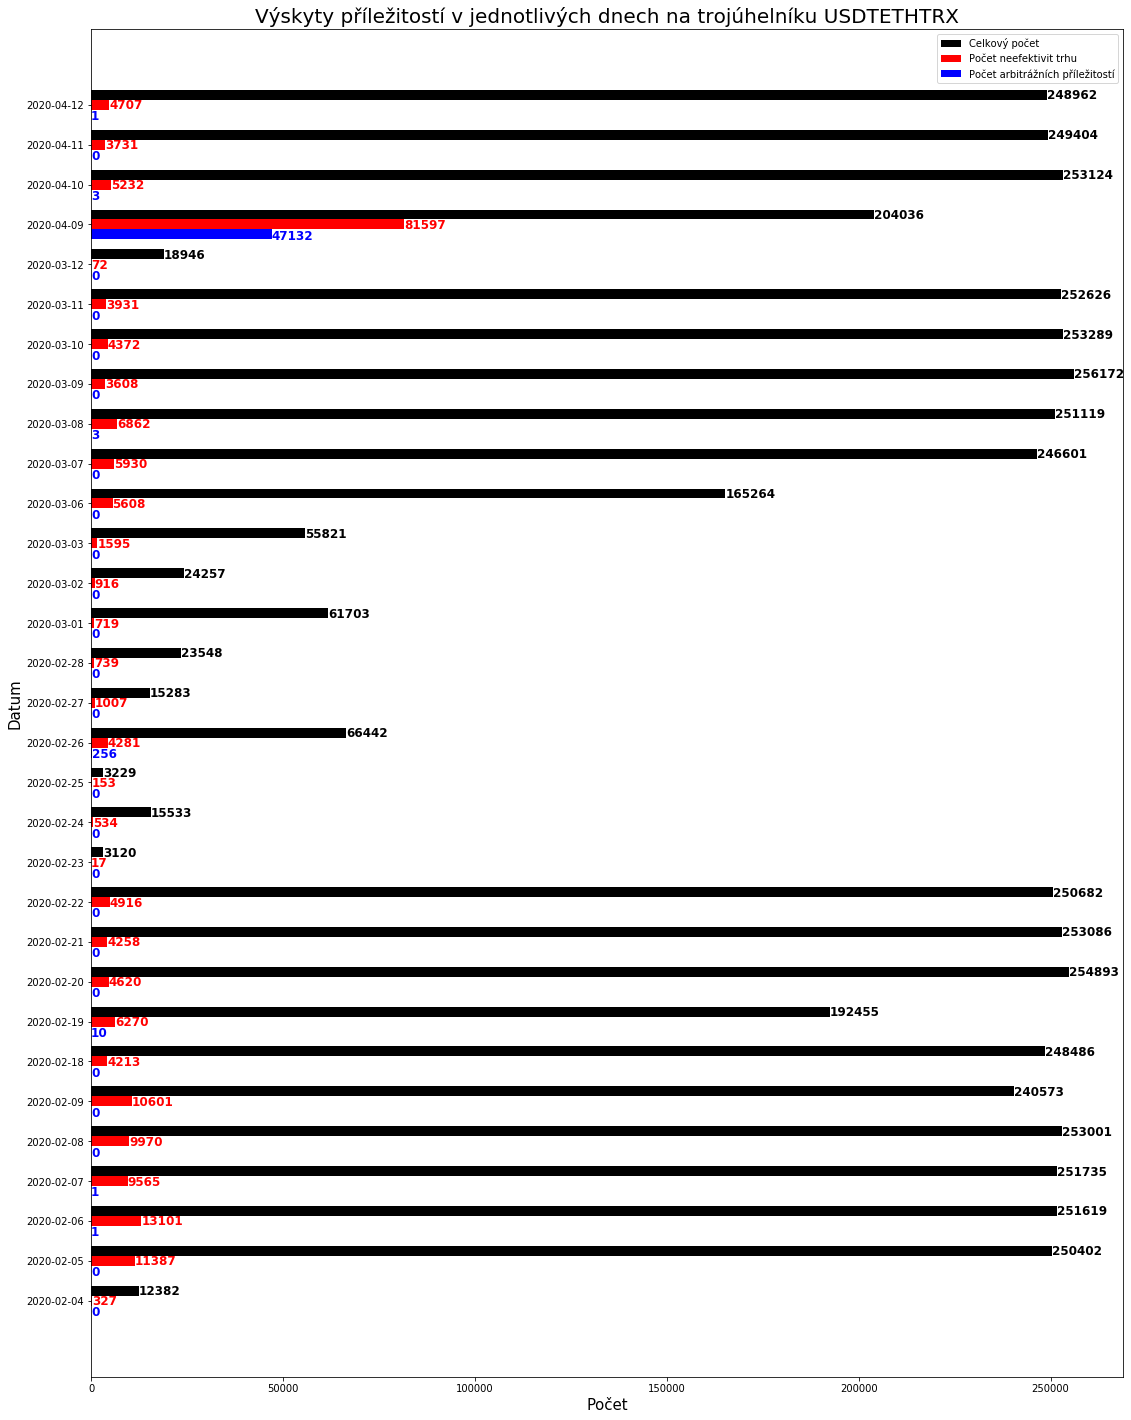

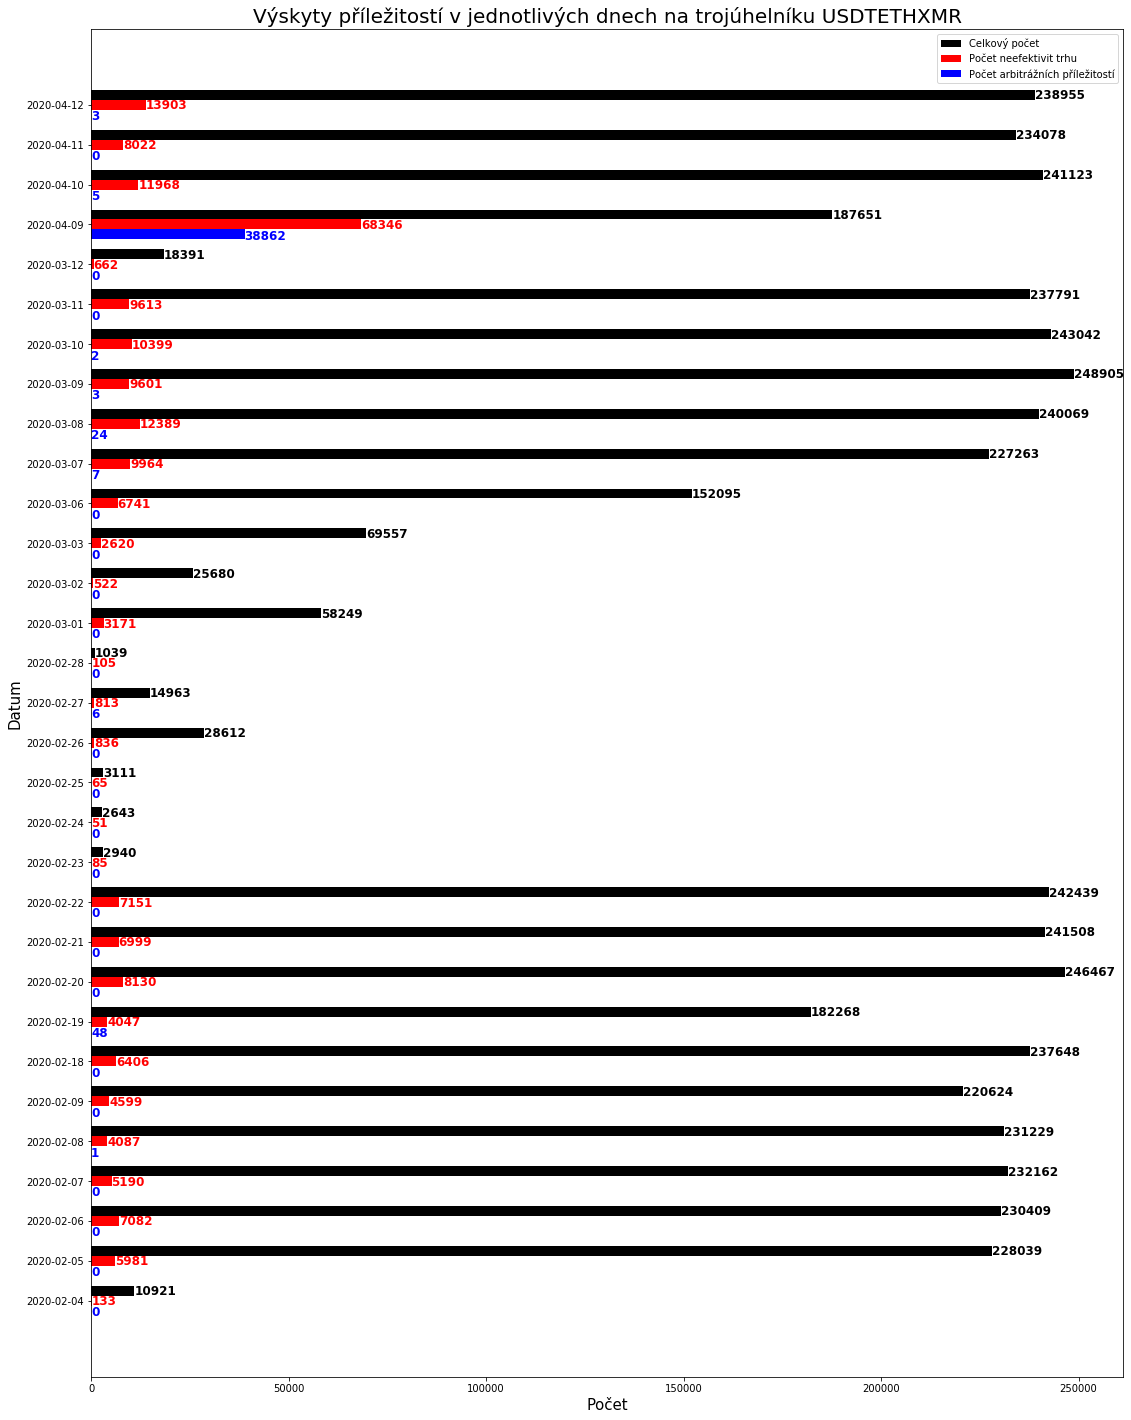

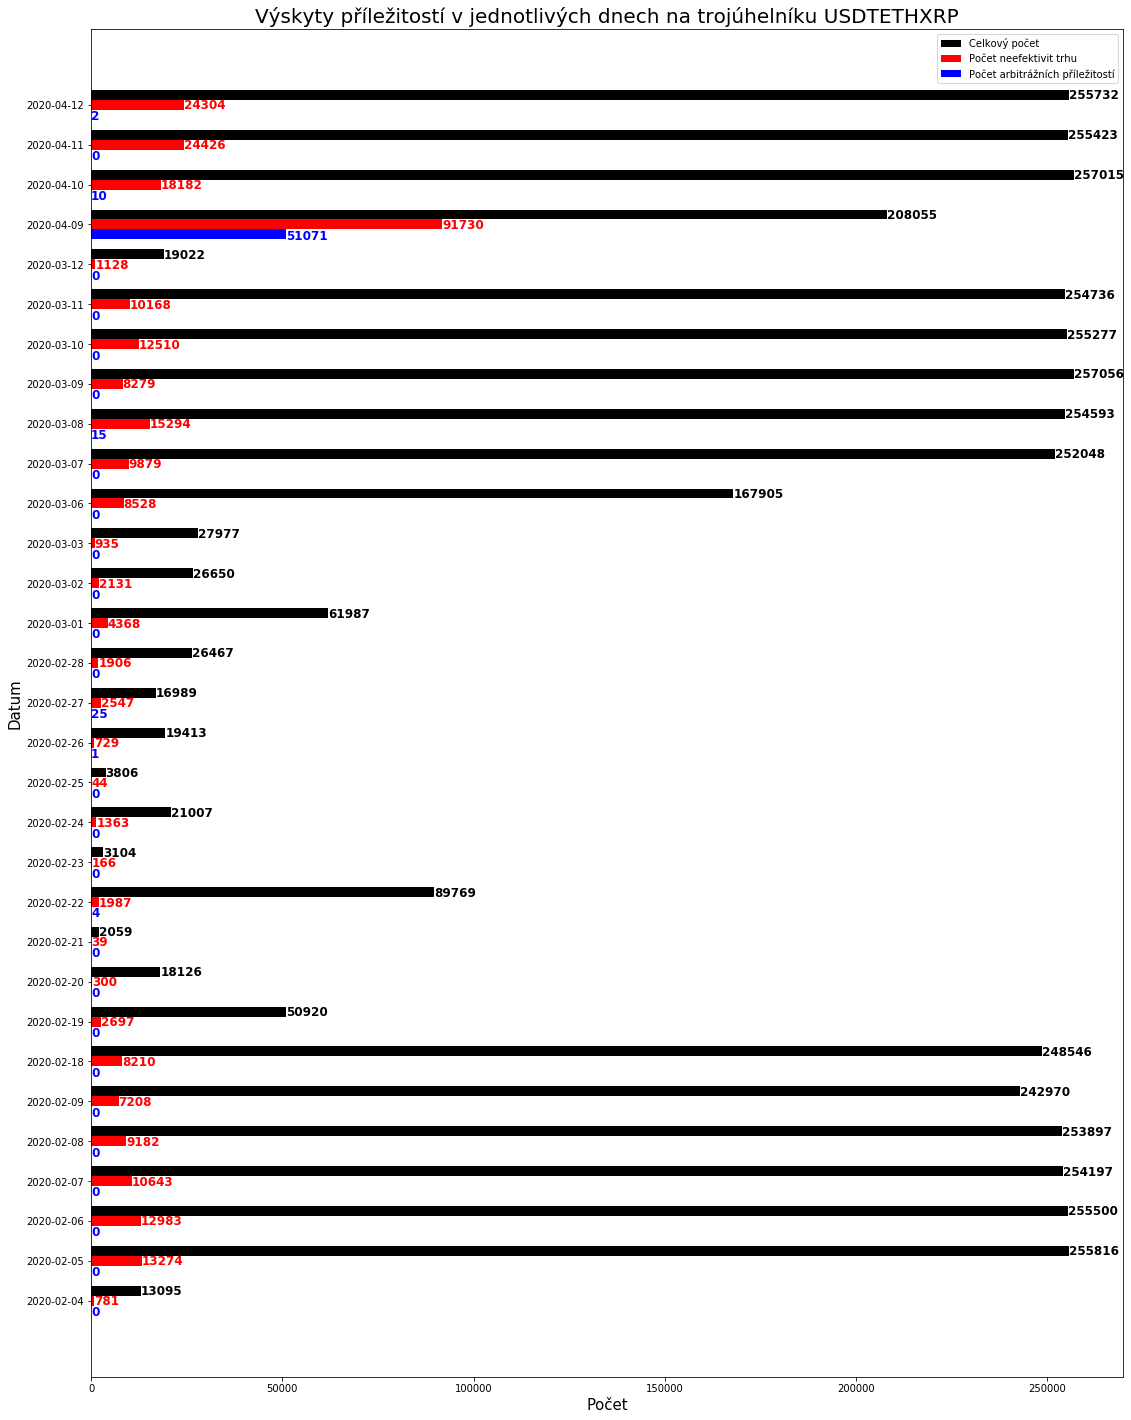

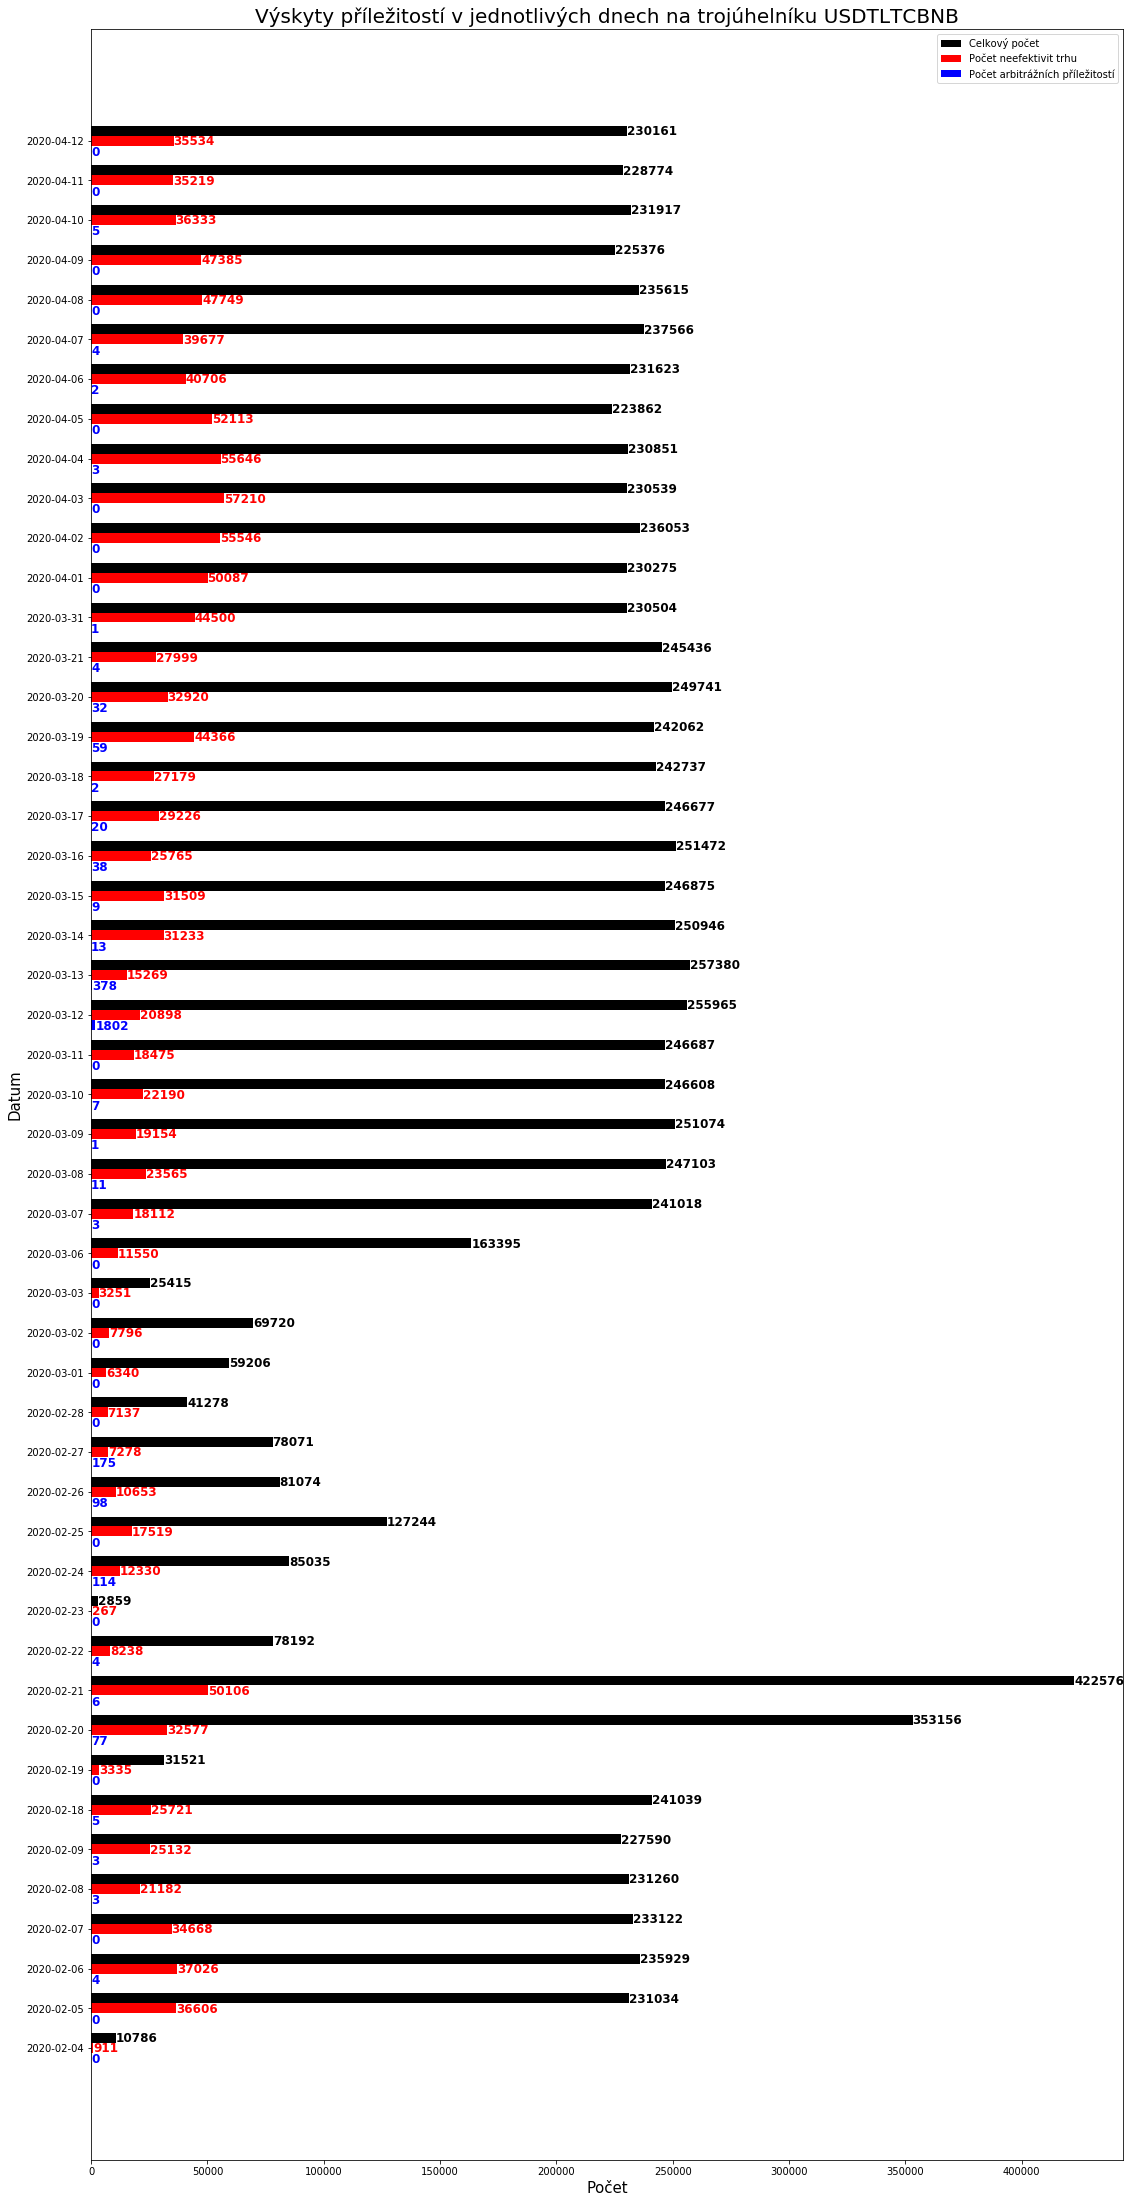

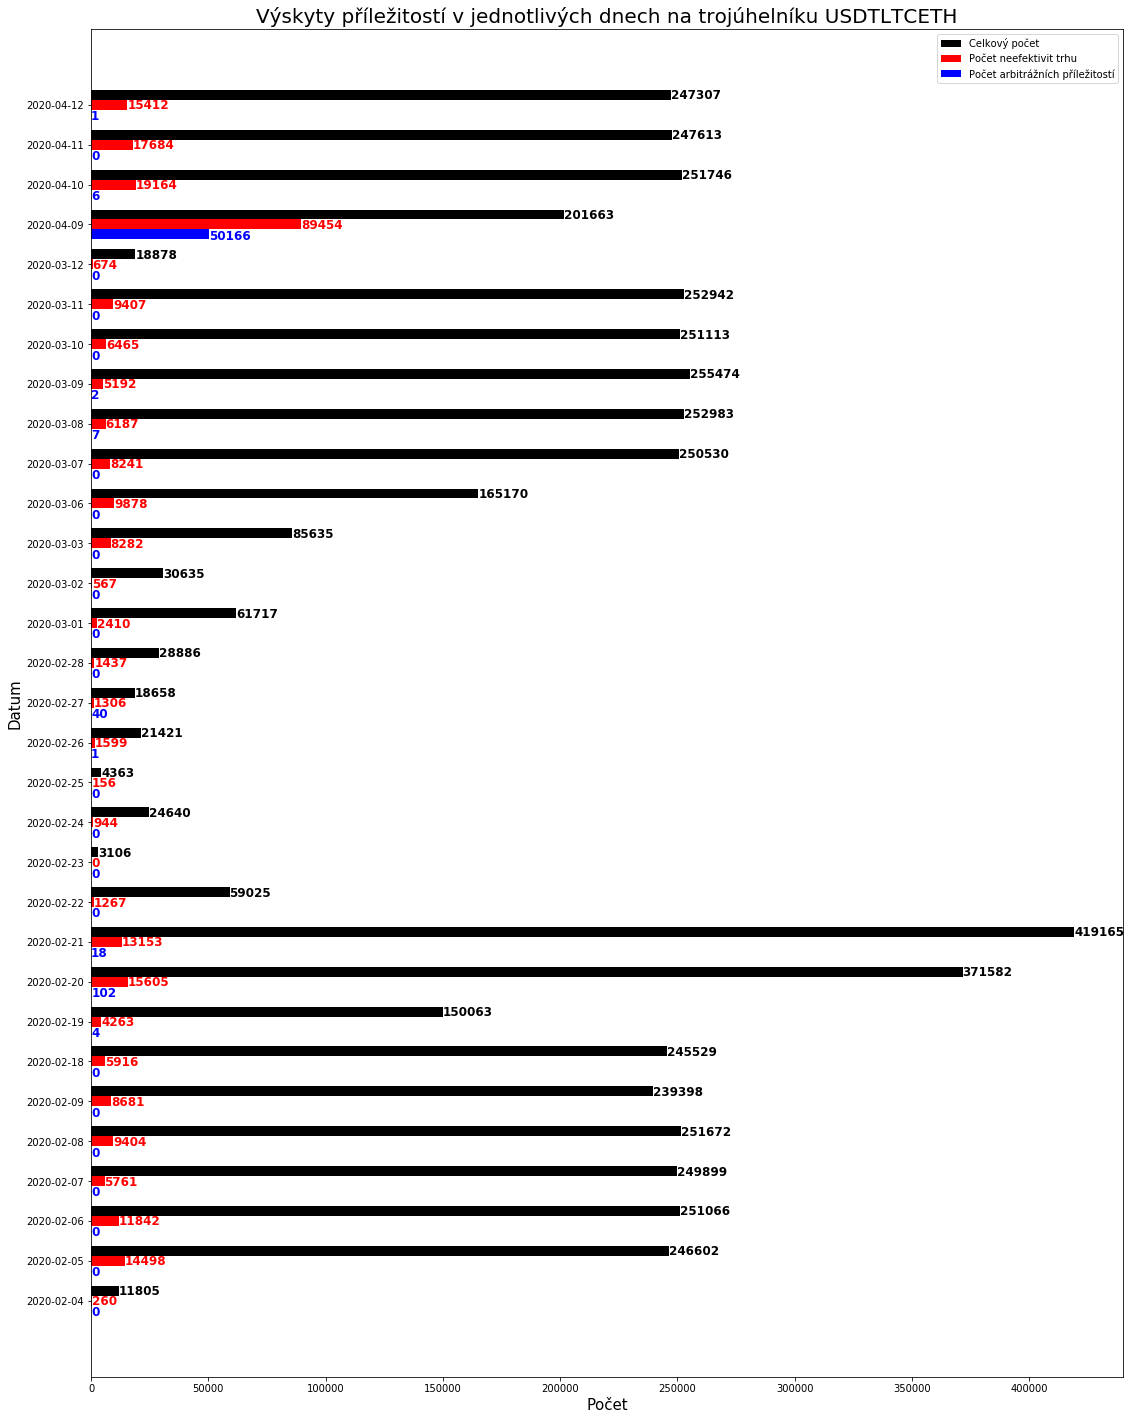

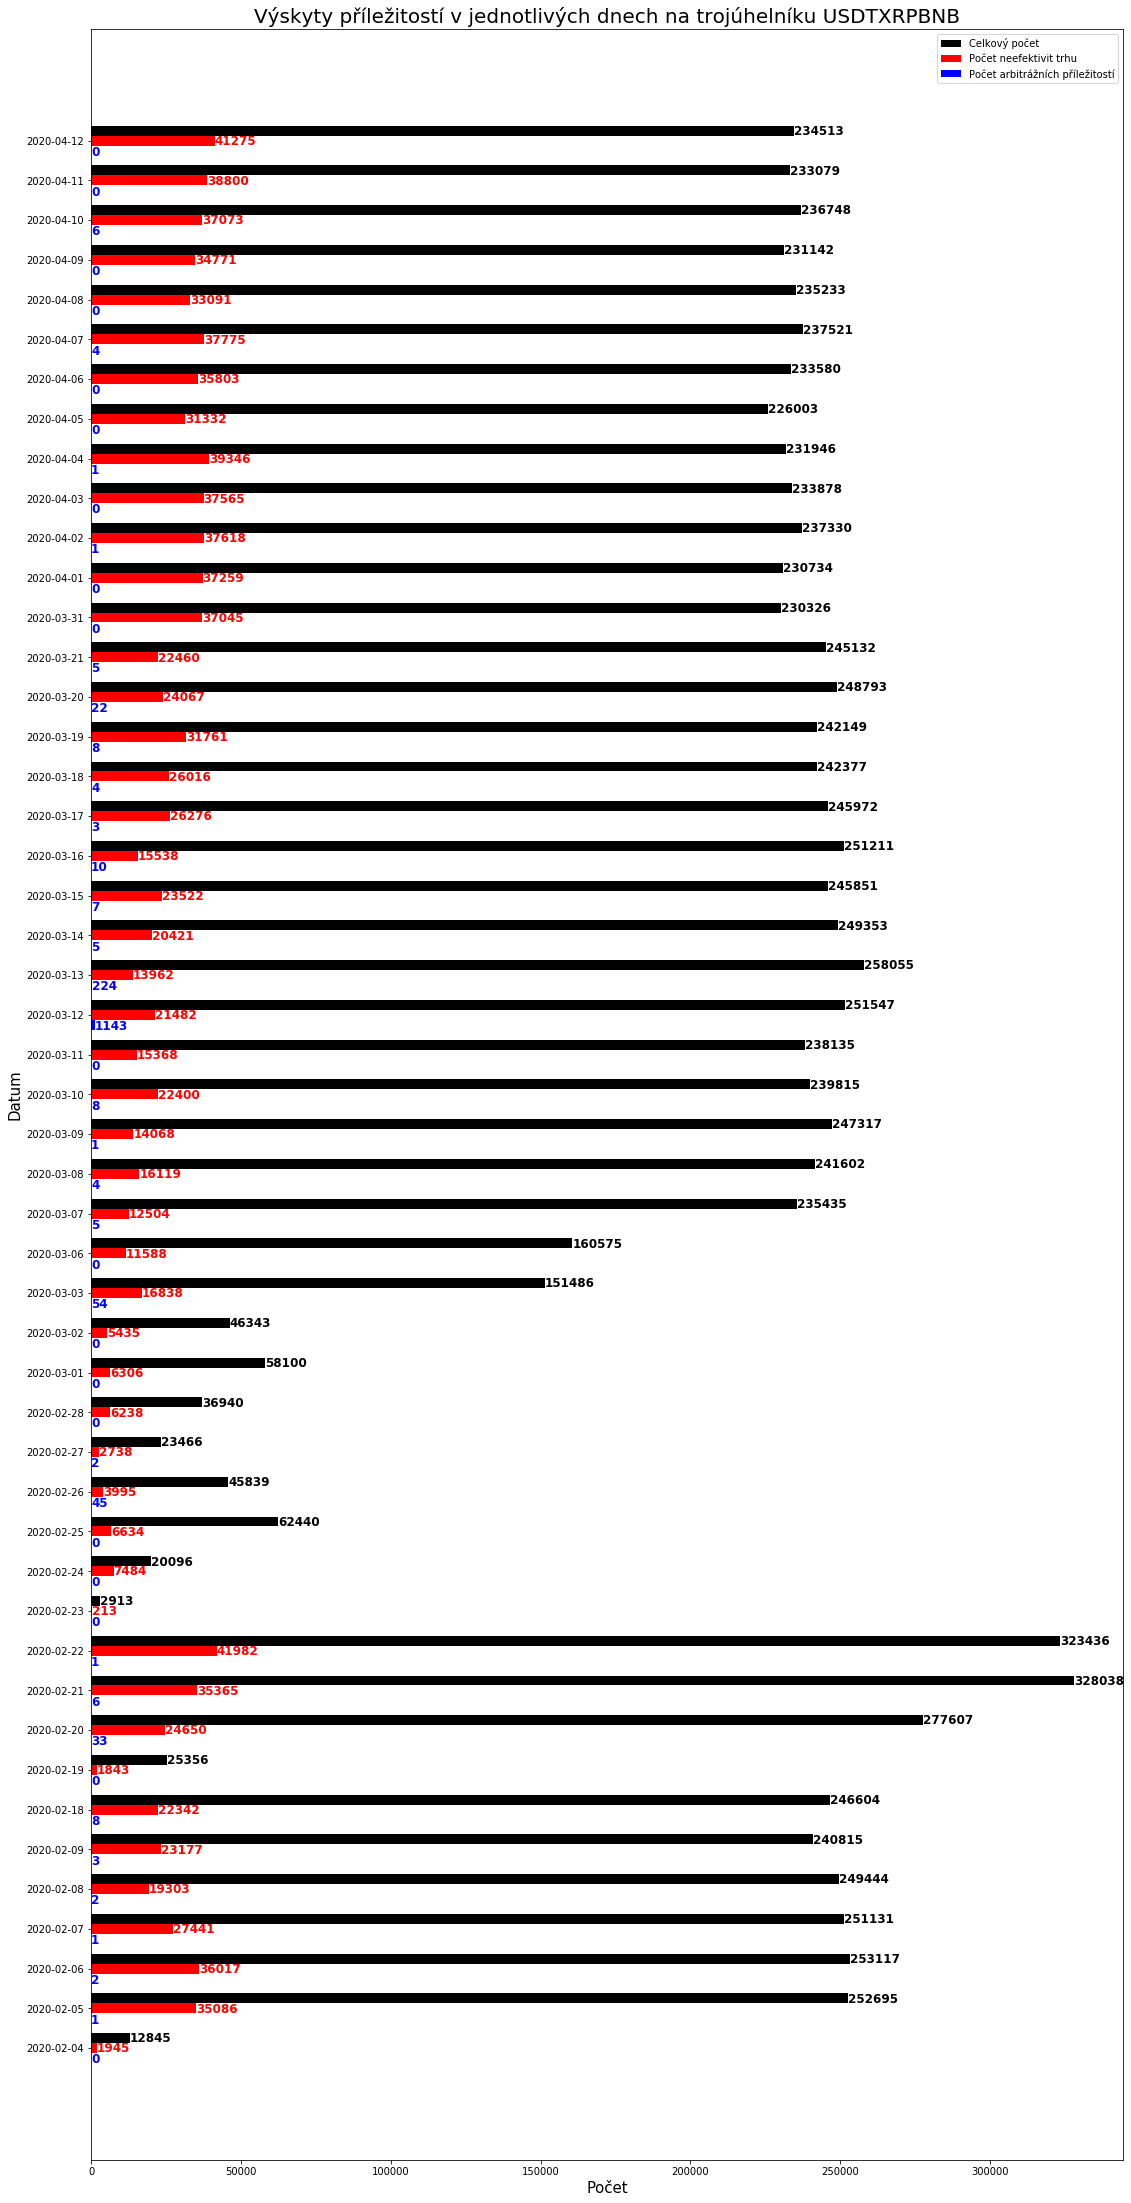

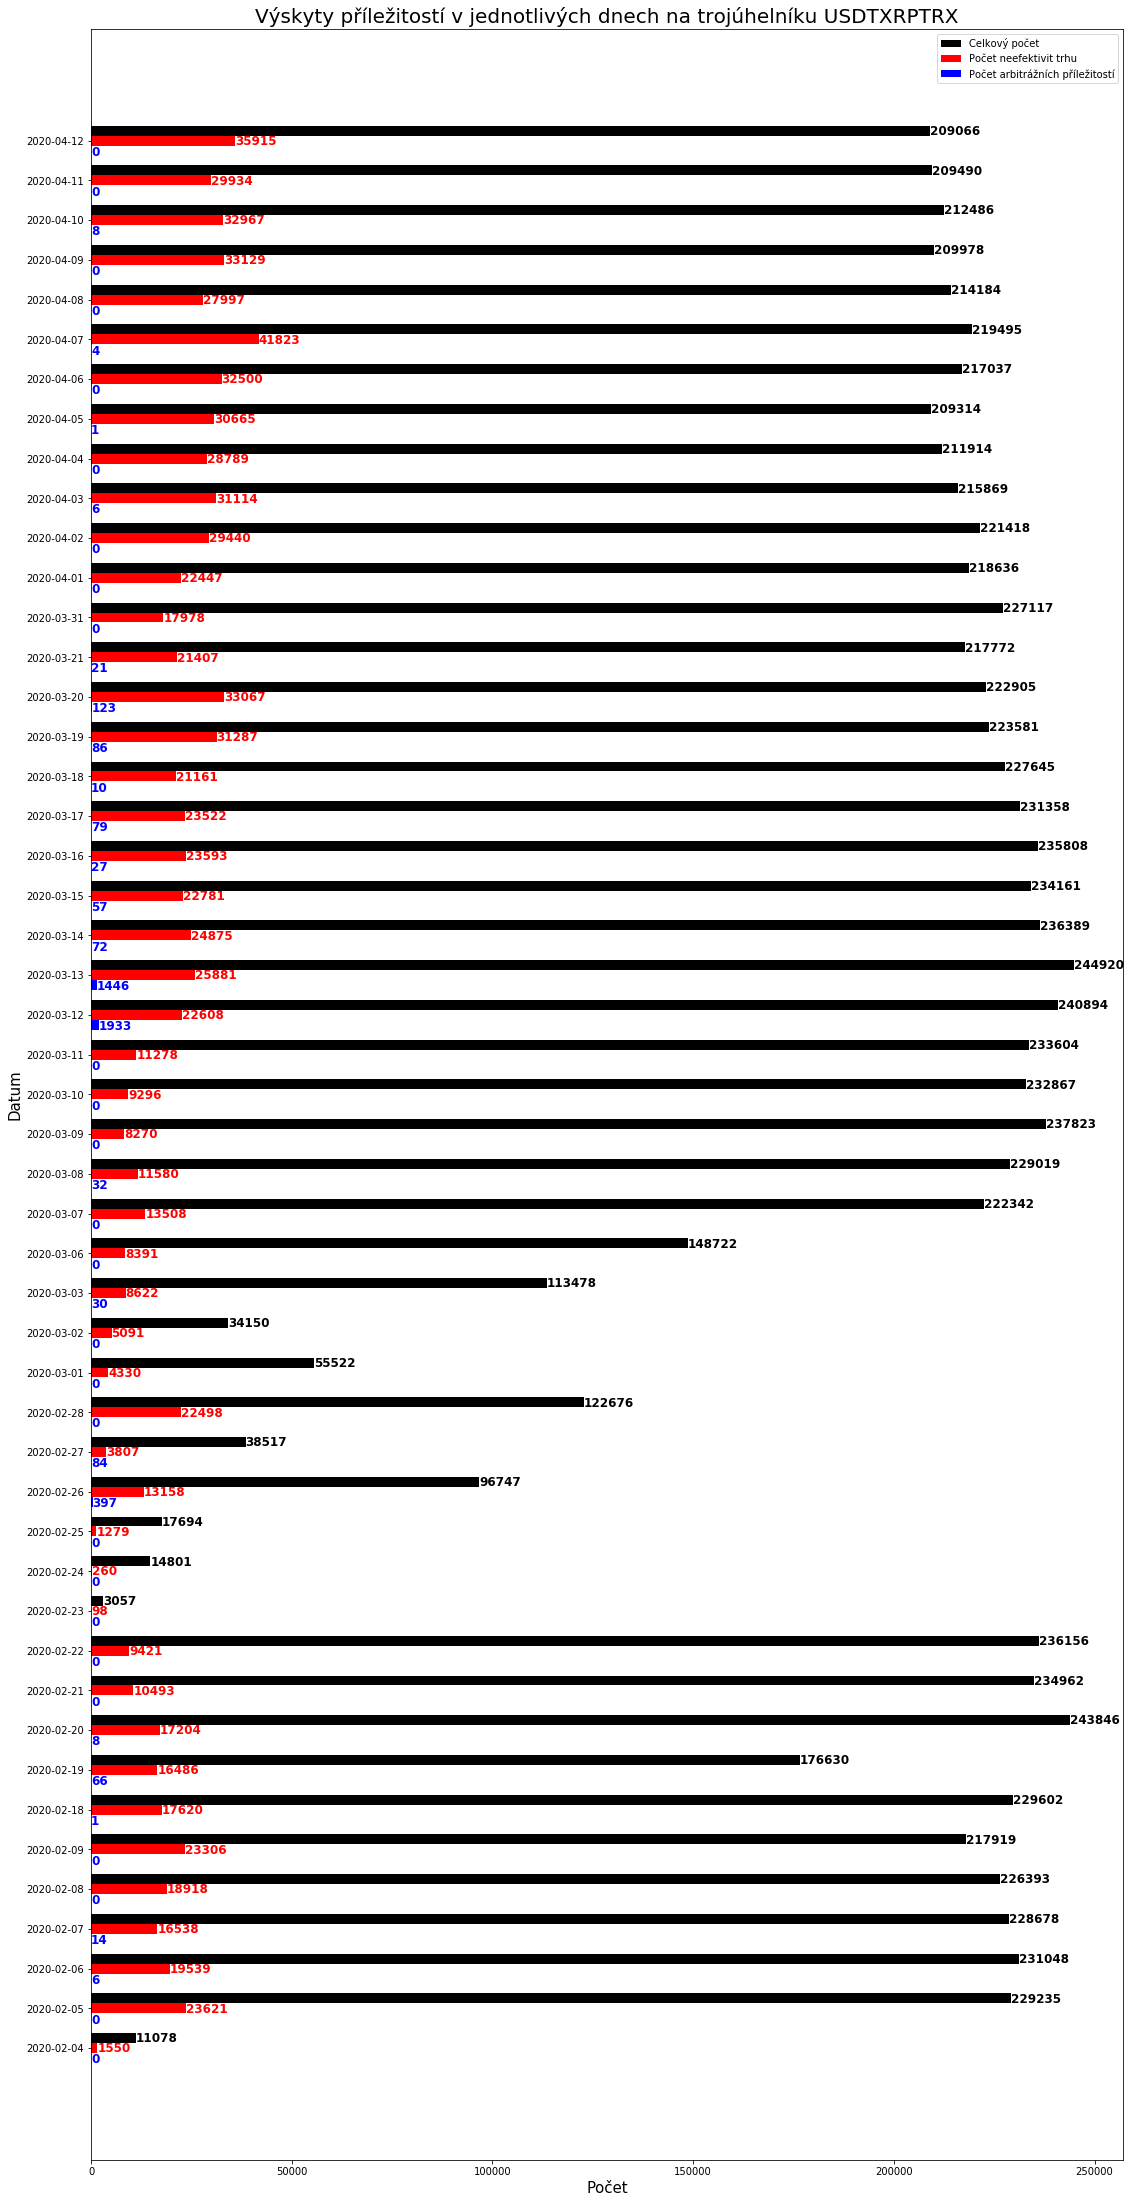

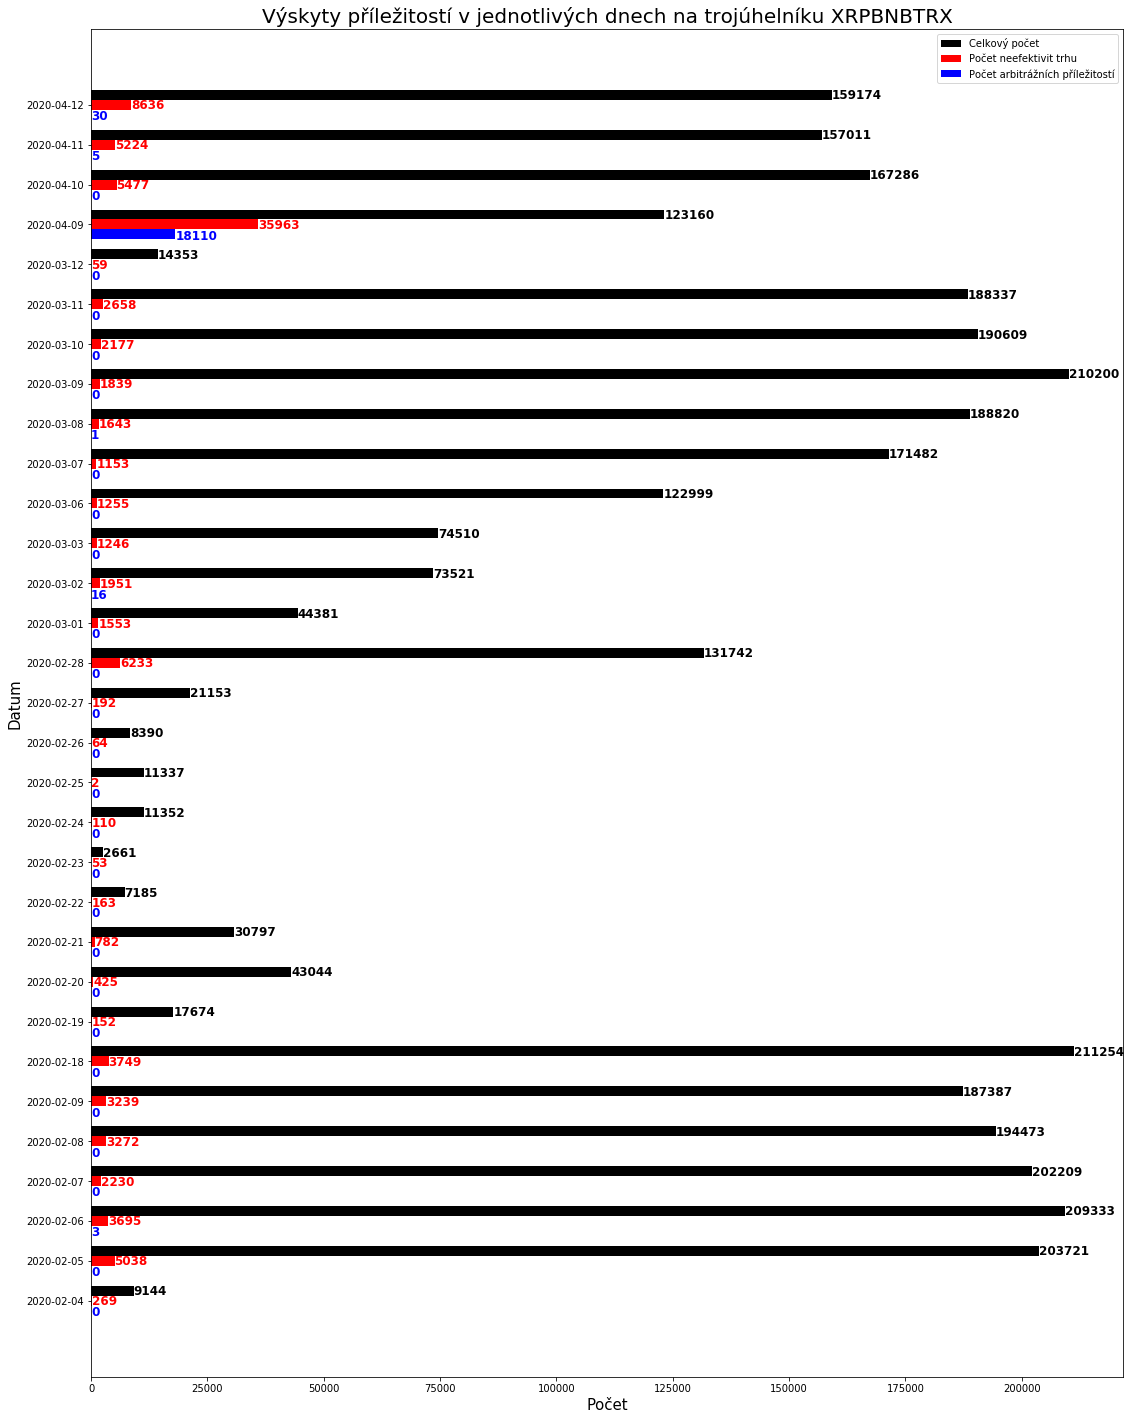

In [13]:
path = "./output_data/"    

count = 0
stop = 99
tr = None
for directory in fetch_directories(path):
    count += 1
    triangle = Triangle(fetch_files(directory), directory, directory[len(path):])
    arbitrages_counts, without_fees_count, all_count, dates = triangle.get_arbitrages_counts()
    
    # ---------------------------------------- plot
    fig, ax = plt.subplots()    
    width = 0.25  # the width of the bars 
    color = 'black'  # text color
    ind = np.arange(len(arbitrages_counts))  # the x locations for the groups
    ax.barh(np.arange(len(arbitrages_counts)) + width, all_count, height=width, align='center', color='black', label='Celkový počet')
    ax.barh(np.arange(len(arbitrages_counts)), without_fees_count, height=width, align='center', color='red', label='Počet neefektivit trhu')
    ax.barh(np.arange(len(arbitrages_counts)) - width, arbitrages_counts, height=width, align='center', color='blue', label='Počet arbitrážních příležitostí')
    ax.set_yticks(ind)
    ax.set_yticklabels(dates)
    plt.xlabel("Počet", fontsize=15)
    plt.ylabel("Datum", fontsize=15)
    plt.title("Výskyty příležitostí v jednotlivých dnech na trojúhelníku " + triangle.name, fontsize=title_font_size)
    ax.legend()
    fig.set_size_inches(18.5, width*3.2*len(dates))
    for i, v in enumerate(all_count):
        ax.text(v, i + width*0.6, str(v), color='black', fontweight='bold', fontsize=12)
    for i, v in enumerate(without_fees_count):
        ax.text(v, i - width*0.4, str(v), color='red', fontweight='bold', fontsize=12)
    for i, v in enumerate(arbitrages_counts):
        ax.text(v, i - width*1.5, str(v), color='blue', fontweight='bold', fontsize=12)
    plt.savefig(os.path.join('arbitrages_count/' + triangle.name + '.png'), dpi=300, format='png')
    plt.show()
    # !---------------------------------------- plot
    
    if count == stop:
        break

In [123]:
def bar_plot_from_pandas_dataframe(df, x, y, title='Nadpis', color='C0'):
    fig, ax = plt.subplots()
    df.plot(kind='bar', x=x, y=y, ax=ax, color=color)
    width = 0.4
    plt.title(title, fontsize=title_font_size)
    fig.set_size_inches(width * len(df['Average count']), 12)
    plt.show()

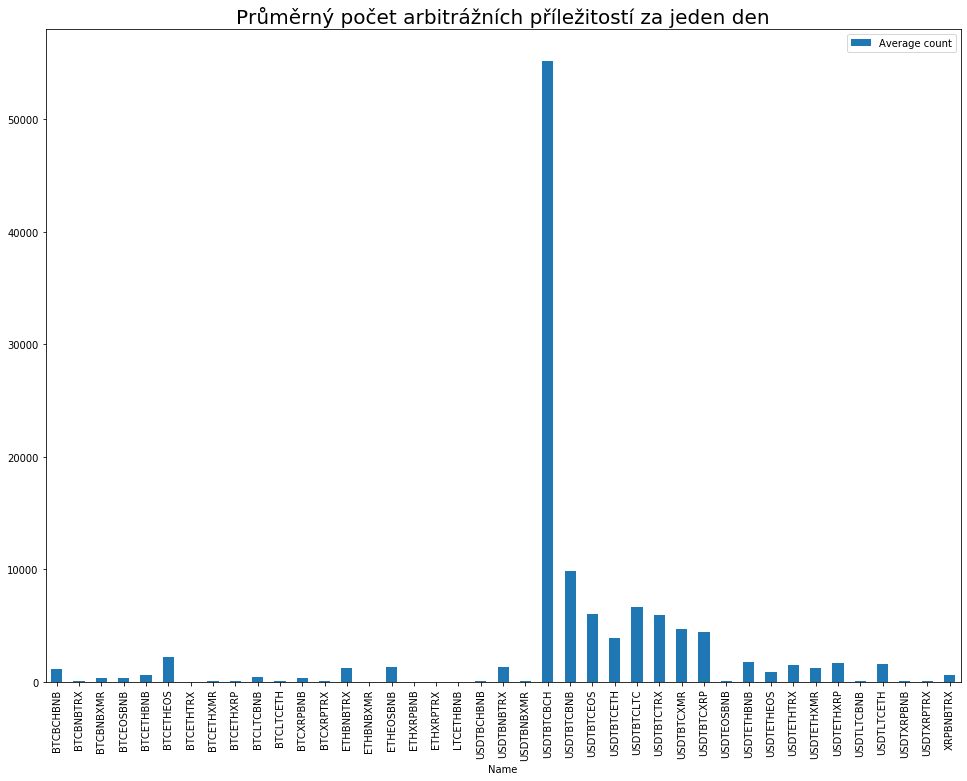

In [124]:
bar_plot_from_pandas_dataframe(stats_table, 'Name', 'Average count', "Průměrný počet arbitrážních příležitostí za jeden den")

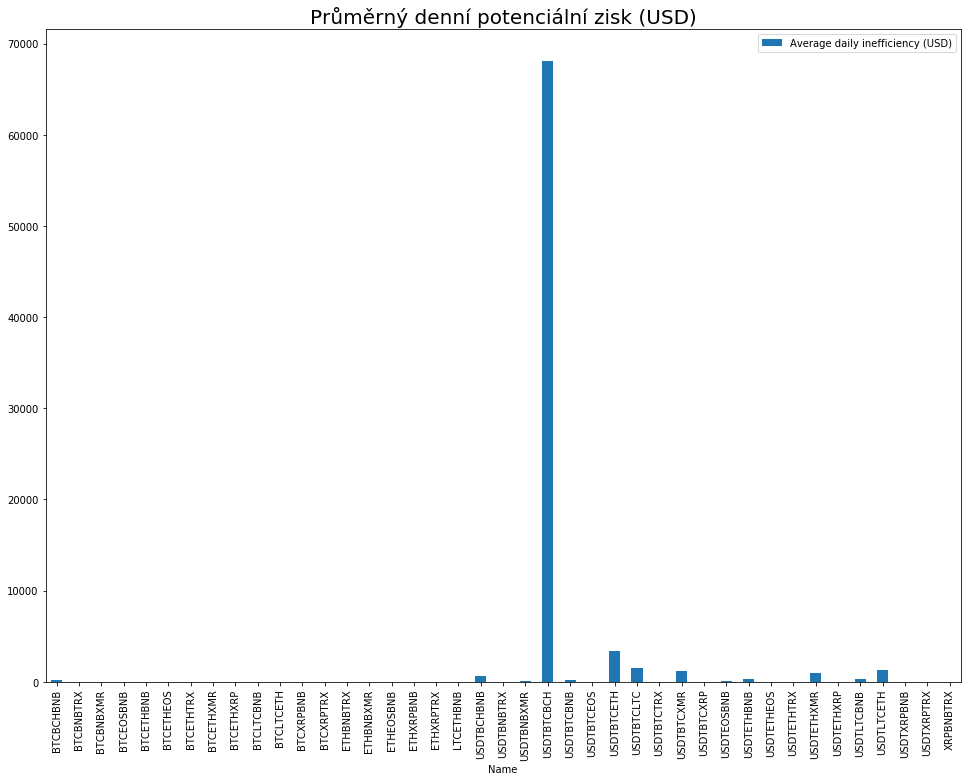

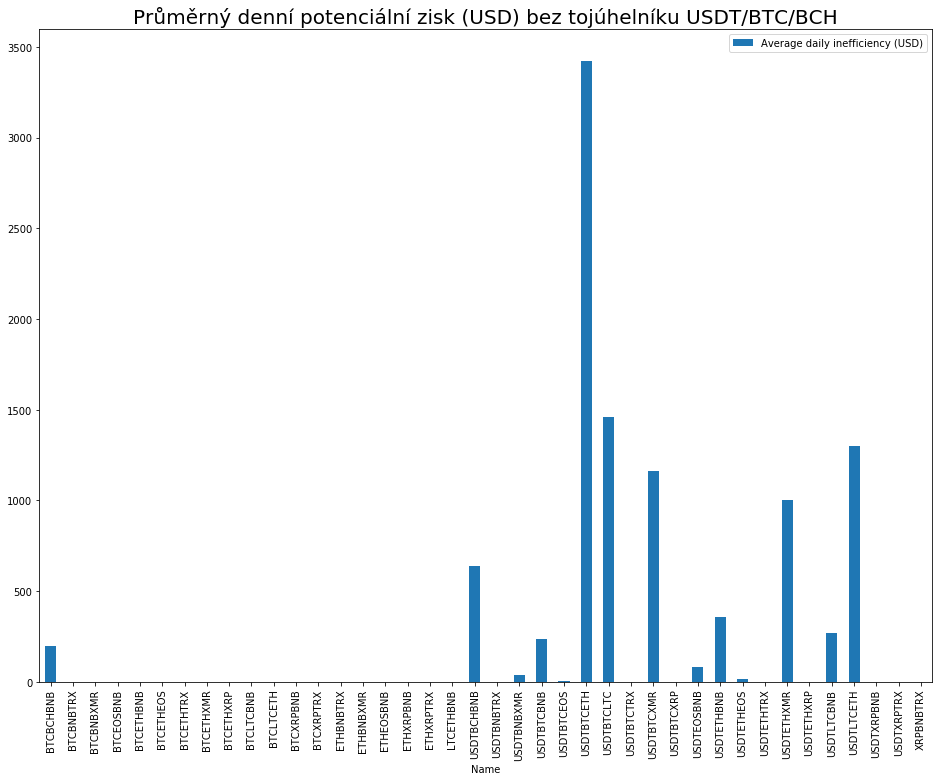

In [125]:
bar_plot_from_pandas_dataframe(stats_table, 'Name', 'Average daily inefficiency (USD)', "Průměrný denní potenciální zisk (USD)")
bar_plot_from_pandas_dataframe(stats_table.drop(22), 'Name', 'Average daily inefficiency (USD)', "Průměrný denní potenciální zisk (USD) bez tojúhelníku USDT/BTC/BCH")

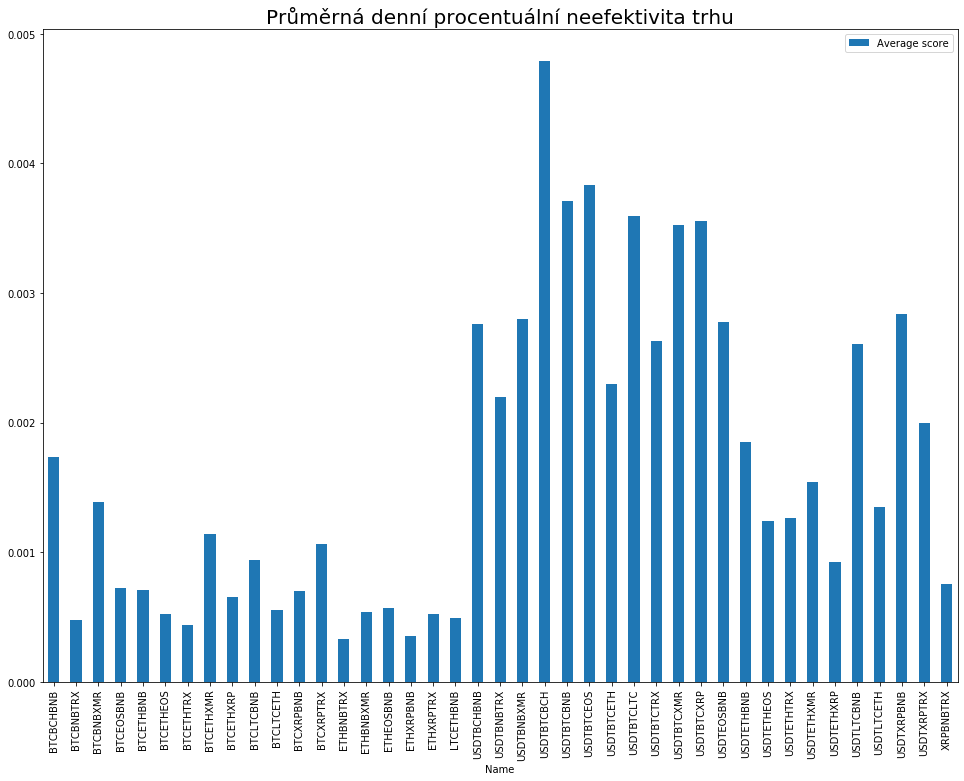

In [126]:
# bar_plot_from_pandas_dataframe(stats_table, 'Name', 'Average score', "Průměrný denní procentuální potenciální zisk")
df = deepcopy(stats_table)
df['Average score'] = df['Average score'].apply(lambda x: x - 1)
bar_plot_from_pandas_dataframe(df, 'Name', 'Average score', "Průměrná procentuální neefektivita trhu")
df = None

# Porovnání grafu trojúhelníku a vývoje jednotlivých dvojic
#### BCHBTC
![](images/BCHBTC.png)
#### USDTBTC
![](images/USDTBTC.png)
#### USDTBCH
![](images/USDTBCH.png)
#### Trojúhelník USDTBTCBCH
![](images/USDTBTCBCH.png)


In [3]:
df = None
df = pd.read_json("./output_data/USDTBTCBCH/USDTBTCBCH-2020-02-26.json")
df

arbitrage_stats  arbitrages_count  \
0      {'score': 1.00301, 'supply_gain_index': [0, 0,...             57770   
1      {'score': 1.00345, 'supply_gain_index': [0, 0,...             57770   
2      {'score': 1.00345, 'supply_gain_index': [0, 0,...             57770   
3      {'score': 1.00488, 'supply_gain_index': [1, 3,...             57770   
4      {'score': 1.00488, 'supply_gain_index': [1, 0,...             57770   
...                                                  ...               ...   
57765  {'score': 1.01725, 'supply_gain_index': [0, 0,...             57770   
57766  {'score': 1.01725, 'supply_gain_index': [0, 0,...             57770   
57767  {'score': 1.01725, 'supply_gain_index': [0, 0,...             57770   
57768  {'score': 1.01725, 'supply_gain_index': [0, 0,...             57770   
57769  {'score': 1.01725, 'supply_gain_index': [0, 0,...             57770   

       without_fees_count  all_count  
0                   65257      68626  
1                   65257      68626  
2                   65257      68626  
3                   65257      68626  
4                   65257      68626  
...                   ...        ...  
57765               65257      68626  
57766               65257      68626  
57767               65257      68626  
57768               65257      68626  
57769               65257      68626  

[57770 rows x 4 columns]

In [111]:
df = {}
with open("./output_data/USDTBTCBCH/USDTBTCBCH-2020-02-26.json") as f:
    df = json.loads(f.read())
df

{'arbitrage_stats': [{'score': 1.00301,
   'supply_gain_index': [0, 0, 0],
   'demand_gain_index': [0, 0, 0],
   'supply_gain': 1.76532e-07,
   'demand_gain': 0,
   'calculation_type_linear': 0,
   'pairs': [{'id': 330857177,
     'timestamp': 1582675273.883601,
     'currency': 'BCHUSDT'},
    {'id': 91640475, 'timestamp': 1582675251.477481, 'currency': 'BCHBTC'},
    {'id': 2251827135, 'timestamp': 2251821479.0, 'currency': 'BTCUSDT'}]},
  {'score': 1.00345,
   'supply_gain_index': [0, 0, 0],
   'demand_gain_index': [0, 0, 0],
   'supply_gain': 0,
   'demand_gain': 2.55761e-05,
   'calculation_type_linear': 0,
   'pairs': [{'id': 330868578,
     'timestamp': 1582675348.902344,
     'currency': 'BCHUSDT'},
    {'id': 91642704, 'timestamp': 1582675348.499431, 'currency': 'BCHBTC'},
    {'id': 2251827135, 'timestamp': 2251821479.0, 'currency': 'BTCUSDT'}]},
  {'score': 1.00345,
   'supply_gain_index': [0, 0, 0],
   'demand_gain_index': [0, 0, 0],
   'supply_gain': 0,
   'demand_gain': 2

In [124]:
from statistics import median
median([x['demand_gain'] for x in df['arbitrage_stats'] if x['demand_gain'] > 0]) * rate['BCH']

0.05085973118

In [125]:
median([x['demand_gain'] for x in df['arbitrage_stats'] if x['demand_gain'] > 0]) * df['arbitrages_count'] * rate['BCH']

2938.1666702686

In [126]:
sum([x['demand_gain'] for x in df['arbitrage_stats'] if x['demand_gain'] > 0]) * rate['BCH']

606.8191572544976

In [ ]:
# ts = []
# print("initializing")

# for i in range(stop):
#     ts.append(threading.Thread(target=basic_stats, args=(triangles[i], str(i),)))
# print("starting")
# for t in ts:
#     t.start()
# for t in ts:
#     t.join()
# print("done")